# Advanced Lane Detection Using Computer Vision

Identifying lanes on the road is a common task performed by all human drivers to ensure their vehicles are within lane constraints when driving, so as to make sure traffic is smooth and minimize chances of collisions with other cars in nearby lanes.

Similarly, it is a critical task for an autonomous vehicle to perform. It turns out that recognising lane markings on roads is possible using well known computer vision techniques. We will cover how to use various techniques to identify and draw the inside road lanes, lane curvature, and even estimate the vehicle position relative to the lane.

This is project 2 of Term 1 of the Udacity Self Driving Car Engineer Nanodegree.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import cv2
import glob

In [55]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        self.vehicle_center=None
        
        

#### Initialize Lines

In [56]:
left_line=Line()
right_line=Line()
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
small_img_size=(256, 144)

In [57]:
def get_obj_img_points_calibration(cal_img_path):
    cal_images=glob.glob(cal_img_path)
    objpoints=[]
    imgpoints=[]
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    #iterate through calibrated images
    for idx,imag in enumerate(cal_images):
        img=image.imread(imag)
        gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret,corners=cv2.findChessboardCorners(gray,(6,9),None)
        if ret==True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints,imgpoints

In [58]:
def get_camera_calibrated_image(image,objpoints,imgpoints):
    # Do camera calibration given object points and image points
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

In [59]:
def apply_gradient_color(image,color_thresh=(0,255),gradient_thresh=(0,255)):
    #convert to hls
    R=image[:,:,2]
    hls=cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    #get S channel
    #l_channel = hls[:,:,1]
    S=hls[:,:,2]
    #create binary image and apply threshold
    binary_img=np.zeros_like(S)
    binary_img[(S>=color_thresh[0])&(S<color_thresh[1])]=1
    #apply sobel to l-channel
    sobelx=cv2.Sobel(R,cv2.CV_64F,1,0)
    abs_sobel=np.absolute(sobelx)
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_sobel_grad=np.zeros_like(scaled_sobel)
    binary_sobel_grad[(scaled_sobel>=gradient_thresh[0])&(scaled_sobel<gradient_thresh[1]) | (S>=color_thresh[0])&(S<color_thresh[1])]=1
    #stack each channel
    #color_img=np.dstack((np.zeros_like(binary_sobel_grad),binary_sobel_grad,binary_img))*255
    return binary_sobel_grad

In [60]:
def perspective_transform(image):
    #source coordinates
    img_size=(image.shape[1],image.shape[0])
    
    src=np.float32(
        [[690, 450],
         [1110, 720],
         [175, 720],
         [595, 450]
        ])
    #desired coordinates
    dsrd=np.float32(
        [[980, 0],
         [980, 720],
         [300, 720],
         [300, 0]
        ])
    M=cv2.getPerspectiveTransform(src,dsrd)
    Minv=cv2.getPerspectiveTransform(dsrd,src)
    warped=cv2.warpPerspective(image,M,img_size,flags=cv2.INTER_LINEAR)
    
    return warped,Minv

In [61]:
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox>(left_fit[0]*(nonzeroy**2)+left_fit[1]*(nonzeroy)+left_fit[2]-margin)) & 
                       (nonzerox< (left_fit[0]*(nonzeroy**2)+left_fit[1]*(nonzeroy)+left_fit[2]+margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2)+right_fit[1]*(nonzeroy)+right_fit[2]-margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2)+right_fit[1]*(nonzeroy)+right_fit[2]+margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    y_max=binary_image.shape[0]
    #Add values to Line()
    left_Line.detected=True
    left_Line.current_fit=left_fitx
    right_Line.detected=True
    right_Line.current_fit=right_fitx
    left_Line.radius_of_curvature=calculate_curvature(y_max,left_fit_m)
    right_Line.radius_of_curvature=calculate_curvature(y_max,right_fit_m)
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

In [62]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]**ploty + left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]**ploty + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [63]:
def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    max_y=binary_warped.shape[0]
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzerox>=win_xleft_low)&(nonzerox<win_xleft_high)&(nonzeroy>=win_y_low)&(nonzeroy<win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox>=win_xright_low)&(nonzerox<win_xright_high)&(nonzeroy>=win_y_low)&(nonzeroy<win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit new polynomials
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    #Add values to Line()
    left_Line.detected=True
    left_Line.current_fit=left_fit
    right_Line.detected=True
    right_Line.current_fit=right_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    #getting x&y values in real world space
    
    #left_fitx_m=left_fit[0]*(ploty*ym_per_pix)**2+left_fit[1]*ploty*ym_per_pix+left_fit[2]
    #right_fit_m=right_fit[0]*(ploty*ym_per_pix)**2+right_fit[1]*ploty*ym_per_pix+right_fit[2]
    y_max=binary_image.shape[0]
    left_Line.radius_of_curvature=calculate_curvature(y_max,left_fit_m)
    right_Line.radius_of_curvature=calculate_curvature(y_max,right_fit_m)
    left_Line.vehicle_center=calc_vehicle_center(binary_warped,left_fit_m,right_fit_m)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

In [64]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
def fit_polynomial(binary_warped,previous_left_fit=None,previous_right_fit=None):
    result=find_lane_pixels(binary_warped)
    return result
    # Find our lane pixels first
    if previous_left_fit is None:
        print('no previous line')
        return find_lane_pixels(binary_warped)
    else:
        print('previous line')
        return search_around_poly(binary_warped)
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    #out_img=np.zeros_like(binary_warped)
    

In [65]:
def warp_lane_on_image(img,Minv):
    y_max=img.shape[0]
    ploty=np.linspace(0,y_max-1,y_max)
    color_warp=np.zeros_like(img).astype(np.uint8)
    print(left_Line.current_fit)
    left_fit=left_Line.current_fit
    right_fit=right_Line.current_fit
    #calculate points
    left_fitx=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    print(left_Line.radius_of_curvature)
    # Draw info of curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #color_warp = np.zeros_like(img).astype(np.uint8)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    output = cv2.addWeighted(img,1,newwarp,0.3,0)
    veh_center=left_Line.vehicle_center
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {} m'.format(round(left_Line.radius_of_curvature,2)), (50, 50), font, 2, fontColor, 2)
    cv2.putText(output, 'Right curvature: {} m'.format(round(right_Line.radius_of_curvature,2)), (50, 120), font, 2, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(veh_center), (50, 190), font, 2, fontColor, 2)
    
    
    #cv2.putText(output, 'Left curvature: {:.0f} m'.format(left_Line.radius_of_curvature),(10,50),font, 1,(255,255,255),2)
    #cv2.putText(output, 'Right curvature: {:.0f} m'.format(right_Line.radius_of_curvature),(10,100), font, 1,(255,255,255),2)
    return output

In [66]:
def calculate_curvature(y_max,fit):
    return((1+((2*fit[0]*y_max*ym_per_pix+fit[1])**2))**1.5)/np.absolute(2*fit[0])

In [67]:
def calc_vehicle_center(img,left_fit_m,right_fit_m):
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    return message

In [68]:
def draw_original_modified_images(original,modified):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(original)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(modified, cmap='gray')
    ax2.set_title('Thresholded S', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##### main function starts here

In [69]:
#Initialize left and right lines
left_Line=Line()
right_Line=Line()
calibration_image_path="camera_cal/calibration*.jpg"
objpoints,imgpoints=get_obj_img_points_calibration(calibration_image_path)
# Test undistortion on an image
img = cv2.imread('test_images/test2.jpg')
print('initial_shape',img.shape)

calibrated_image=get_camera_calibrated_image(img,objpoints,imgpoints)
cv2.imwrite('output_images/calibrated_image.jpg',calibrated_image)
print('shape after calibration',calibrated_image.shape)

initial_shape (720, 1280, 3)
shape after calibration (720, 1280, 3)


shape after color gradient (720, 1280)


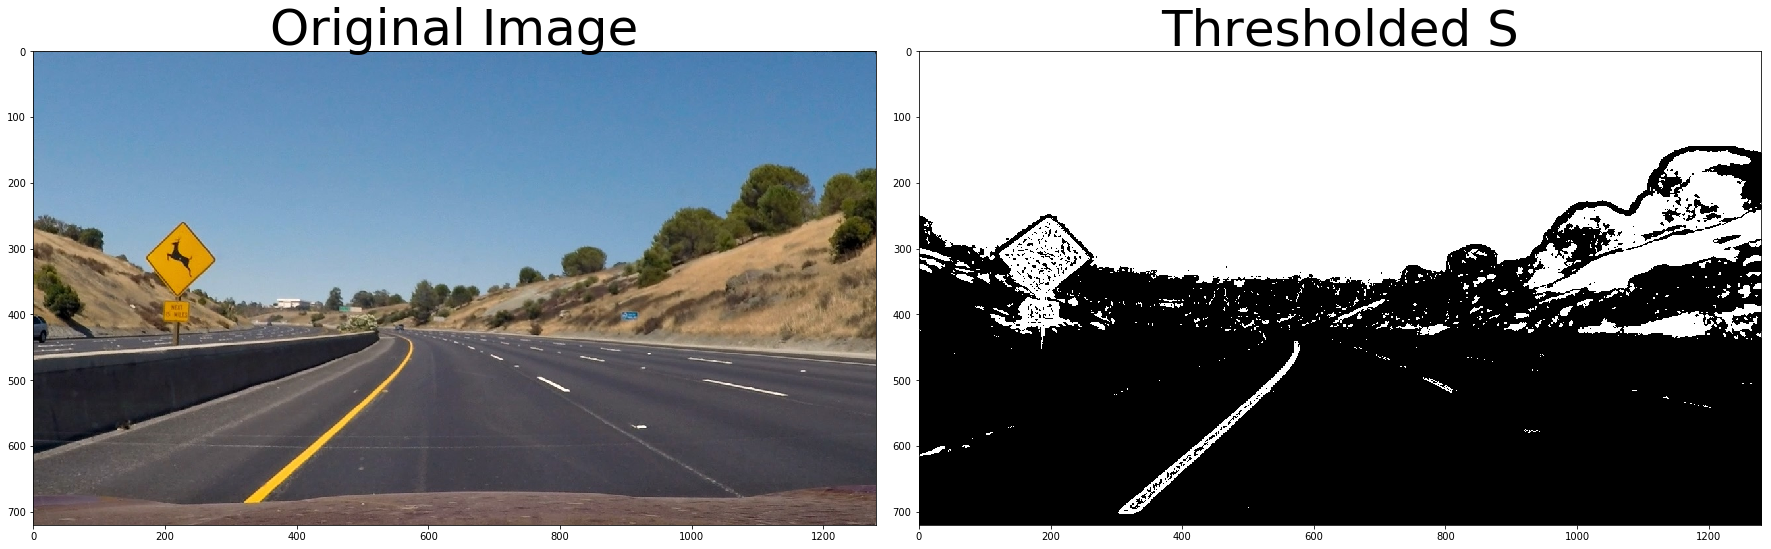

In [70]:
#do color treshold and gradient
binary_image=apply_gradient_color(calibrated_image,color_thresh=(80,255),gradient_thresh=(80,150))
print('shape after color gradient',binary_image.shape)
cv2.imwrite('output_images/color_gradient_image.jpg',binary_image)
draw_original_modified_images(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),binary_image)

shape after perspective transform (720, 1280)


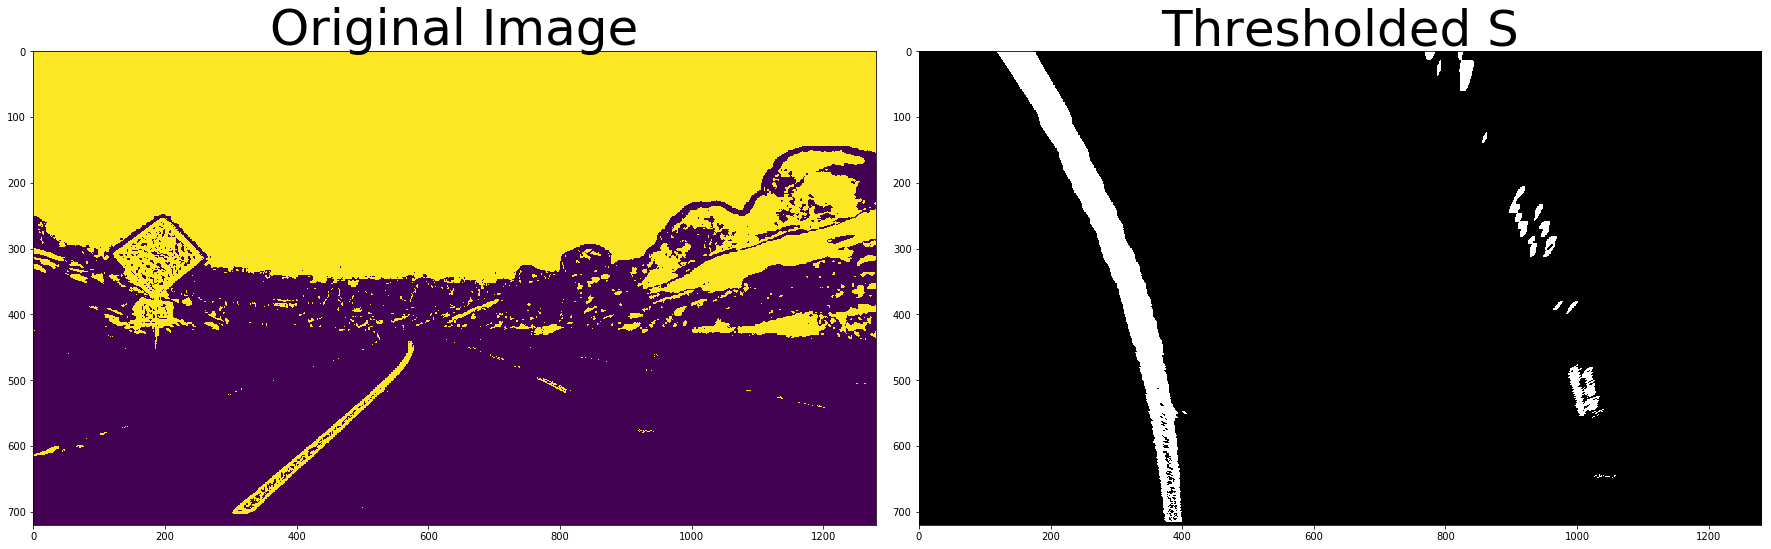

In [71]:
#do a perspective transform of image
transformed_image,Minv=perspective_transform(binary_image)
#gray=cv2.cvtColor(transformed_image,cv2.COLOR_RGB2GRAY)
cv2.imwrite('output_images/perspective_image.jpg',transformed_image)
print('shape after perspective transform',transformed_image.shape)
draw_original_modified_images(binary_image,transformed_image)

True

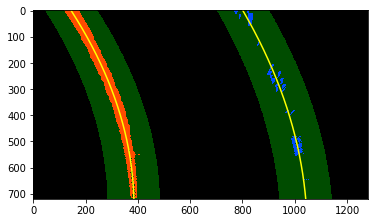

In [72]:
#draw_original_modified_images(img,gray)
imag=fit_polynomial(transformed_image,previous_left_fit=None,previous_right_fit=None)
plt.imshow(imag)
cv2.imwrite('output_images/polynomial_image.jpg',imag)

[-4.28532051e-04  6.41434906e-01  1.45210114e+02]
383.23639205328925


True

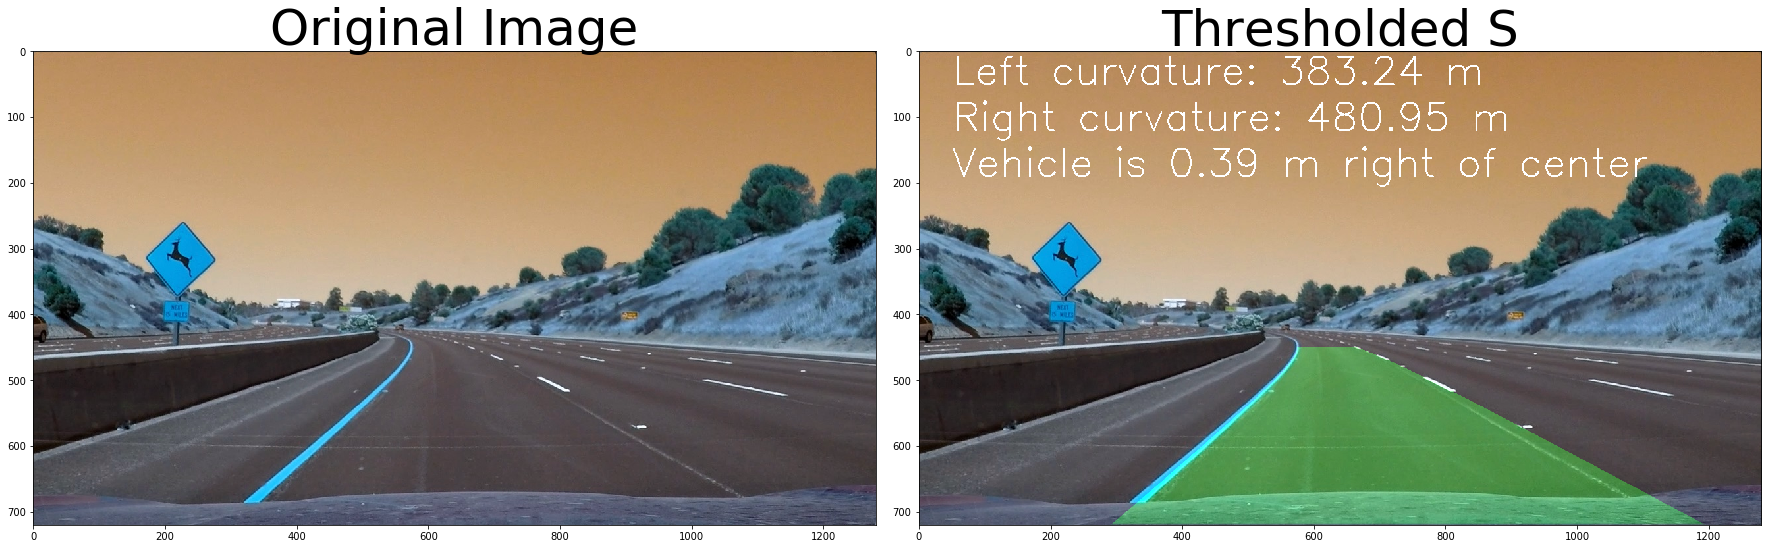

In [73]:
warp_img=warp_lane_on_image(img,Minv)
#lane_on_img=cv2.addWeighted(img,1,warp_img,0.3,0)
draw_original_modified_images(img,warp_img)
cv2.imwrite('output_images/final_image.jpg',warp_img)

Applying on Video

In [49]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [50]:
def pipeline(video_frame):
    #calibration_image_path="camera_cal/calibration*.jpg"
    #objpoints,imgpoints=get_obj_img_points_calibration(calibration_image_path)
    calibrated_image_video=get_camera_calibrated_image(video_frame,objpoints,imgpoints)
    #do color treshold and gradient
    binary_image_video=apply_gradient_color(calibrated_image_video,color_thresh=(80,255),gradient_thresh=(20,100))
    #do a perspective transform of image
    transformed_image_video,Minv=perspective_transform(binary_image_video)
    image_video=fit_polynomial(transformed_image_video)
    warp_img=warp_lane_on_image(video_frame,Minv)
    return warp_img

[-4.31893790e-04  6.20851694e-01  1.55182363e+02]
380.2479570255801
Moviepy - Building video modified_project_video.mp4.
Moviepy - Writing video modified_project_video.mp4



t:   0%|                                    | 0/1260 [00:00<?, ?it/s, now=None]

[-4.31893790e-04  6.20851694e-01  1.55182363e+02]
380.2479570255801


t:   0%|                            | 2/1260 [00:02<23:51,  1.14s/it, now=None]

[-4.72773638e-04  6.58998847e-01  1.48467146e+02]
347.3726039930881


t:   0%|                            | 3/1260 [00:05<34:56,  1.67s/it, now=None]

[-4.50451957e-04  6.46195922e-01  1.48724090e+02]
364.58216741249566


t:   0%|                            | 4/1260 [00:07<36:45,  1.76s/it, now=None]

[-4.21481066e-04  6.25841597e-01  1.51357856e+02]
389.6453661086729


t:   0%|                            | 5/1260 [00:08<35:44,  1.71s/it, now=None]

[-4.15333812e-04  6.26937784e-01  1.50090140e+02]
395.41694704195714


t:   0%|▏                           | 6/1260 [00:10<35:33,  1.70s/it, now=None]

[-4.03734105e-04  6.24666333e-01  1.48393613e+02]
406.7879170025726


t:   1%|▏                           | 7/1260 [00:12<35:07,  1.68s/it, now=None]

[-3.78279857e-04  6.11915658e-01  1.46774194e+02]
434.1881342144731


t:   1%|▏                           | 8/1260 [00:13<35:55,  1.72s/it, now=None]

[-3.90121060e-04  6.25635262e-01  1.43774573e+02]
421.0049414962163


t:   1%|▏                           | 9/1260 [00:15<37:33,  1.80s/it, now=None]

[-3.70809191e-04  6.15185308e-01  1.41606730e+02]
442.957948606271


t:   1%|▏                          | 10/1260 [00:17<37:46,  1.81s/it, now=None]

[-3.64617620e-04  6.16502445e-01  1.37854264e+02]
450.49902892628467


t:   1%|▏                          | 11/1260 [00:19<36:49,  1.77s/it, now=None]

[-3.88757652e-04  6.41670632e-01  1.31193237e+02]
422.50819086965504


t:   1%|▎                          | 12/1260 [00:21<35:59,  1.73s/it, now=None]

[-3.61577103e-04  6.23948816e-01  1.27557937e+02]
454.31254161185524


t:   1%|▎                          | 13/1260 [00:22<35:39,  1.72s/it, now=None]

[-3.47127839e-04  6.13489676e-01  1.28189074e+02]
473.24902543239295


t:   1%|▎                          | 14/1260 [00:24<36:36,  1.76s/it, now=None]

[-3.45108085e-04  6.05216667e-01  1.31203967e+02]
476.00505187716567


t:   1%|▎                          | 15/1260 [00:26<38:35,  1.86s/it, now=None]

[-3.69490269e-04  6.24059937e-01  1.29193909e+02]
444.55914281373856


t:   1%|▎                          | 16/1260 [00:28<38:45,  1.87s/it, now=None]

[-3.74860664e-04  6.29827544e-01  1.28195128e+02]
438.1864369449902


t:   1%|▎                          | 17/1260 [00:30<39:40,  1.91s/it, now=None]

[-3.72435568e-04  6.28376046e-01  1.27903069e+02]
441.04362172158204


t:   1%|▍                          | 18/1260 [00:32<40:16,  1.95s/it, now=None]

[-3.95469792e-04  6.48874226e-01  1.23643171e+02]
415.3331596907839


t:   2%|▍                          | 19/1260 [00:34<40:05,  1.94s/it, now=None]

[-3.95163430e-04  6.48517592e-01  1.21120433e+02]
415.65529342362925


t:   2%|▍                          | 20/1260 [00:36<38:38,  1.87s/it, now=None]

[-4.27330401e-04  6.77728046e-01  1.13142515e+02]
384.34463980702606


t:   2%|▍                          | 21/1260 [00:38<39:42,  1.92s/it, now=None]

[-4.11197846e-04  6.60815634e-01  1.14315692e+02]
399.4316451400829


t:   2%|▍                          | 22/1260 [00:40<42:33,  2.06s/it, now=None]

[-4.21990880e-04  6.64319270e-01  1.12606982e+02]
389.2014208350628


t:   2%|▍                          | 23/1260 [00:43<45:58,  2.23s/it, now=None]

[-4.14382855e-04  6.57679802e-01  1.12619588e+02]
396.35197449464306


t:   2%|▌                          | 24/1260 [00:46<50:33,  2.45s/it, now=None]

[-4.42836464e-04  6.74890404e-01  1.12174279e+02]
370.8642533449075


t:   2%|▌                          | 25/1260 [00:48<51:49,  2.52s/it, now=None]

[-4.66412363e-04  6.93038270e-01  1.09663125e+02]
352.1101842273922


t:   2%|▌                          | 26/1260 [00:50<48:11,  2.34s/it, now=None]

[-4.49984431e-04  6.74417056e-01  1.12106491e+02]
364.9670670078162


t:   2%|▌                          | 27/1260 [00:52<45:32,  2.22s/it, now=None]

[-4.56512762e-04  6.80737173e-01  1.10215412e+02]
359.74654734034027


t:   2%|▌                          | 28/1260 [00:54<44:06,  2.15s/it, now=None]

[-4.18584611e-04  6.46212273e-01  1.14891781e+02]
392.3560659908468


t:   2%|▌                          | 29/1260 [00:57<50:43,  2.47s/it, now=None]

[-4.30457674e-04  6.51156380e-01  1.17428516e+02]
381.52557081301387


t:   2%|▋                          | 30/1260 [00:59<47:38,  2.32s/it, now=None]

[-5.10659324e-04  7.16558321e-01  1.08984033e+02]
321.60017201997


t:   2%|▋                          | 31/1260 [01:01<43:32,  2.13s/it, now=None]

[-5.68775808e-04  7.69536862e-01  1.00095329e+02]
288.75426498823145


t:   3%|▋                          | 32/1260 [01:03<40:35,  1.98s/it, now=None]

[-5.87954891e-04  7.86258585e-01  9.99308356e+01]
279.343177719208


t:   3%|▋                          | 33/1260 [01:04<37:53,  1.85s/it, now=None]

[-5.27120083e-04  7.37034640e-01  1.06618906e+02]
311.5583220952757


t:   3%|▋                          | 34/1260 [01:06<36:30,  1.79s/it, now=None]

[-5.60067021e-04  7.66077850e-01  1.02630140e+02]
293.2384823184917


t:   3%|▊                          | 35/1260 [01:08<35:30,  1.74s/it, now=None]

[-5.74277696e-04  7.83180534e-01  9.89955828e+01]
285.98416050759346


t:   3%|▊                          | 36/1260 [01:09<34:24,  1.69s/it, now=None]

[-5.55022612e-04  7.78761321e-01  9.75285686e+01]
295.8949501110123


t:   3%|▊                          | 37/1260 [01:11<33:48,  1.66s/it, now=None]

[-5.67177148e-04  7.90024353e-01  9.54105983e+01]
289.5560157359182


t:   3%|▊                          | 38/1260 [01:12<33:32,  1.65s/it, now=None]

[-6.10146589e-04  8.31275590e-01  8.81517408e+01]
269.17401881419636


t:   3%|▊                          | 39/1260 [01:14<33:36,  1.65s/it, now=None]

[-6.16353055e-04  8.41388360e-01  8.59174568e+01]
266.4628207856503


t:   3%|▊                          | 40/1260 [01:16<33:51,  1.67s/it, now=None]

[-5.93876889e-04  8.29375680e-01  8.44665886e+01]
276.537730082567


t:   3%|▉                          | 41/1260 [01:17<33:56,  1.67s/it, now=None]

[-5.82903801e-04  8.22867306e-01  8.51334438e+01]
281.7408422297146


t:   3%|▉                          | 42/1260 [01:19<33:44,  1.66s/it, now=None]

[-5.49525893e-04  7.97840887e-01  8.83123134e+01]
298.8519694139562


t:   3%|▉                          | 43/1260 [01:21<34:01,  1.68s/it, now=None]

[-5.32082332e-04  7.93344702e-01  8.54673589e+01]
308.65457869435147


t:   3%|▉                          | 44/1260 [01:23<35:12,  1.74s/it, now=None]

[-4.47221873e-04  7.20188921e-01  9.72457372e+01]
367.2667842071564


t:   4%|▉                          | 45/1260 [01:24<35:41,  1.76s/it, now=None]

[-4.27577513e-04  7.06387336e-01  9.77445924e+01]
384.1626779803366


t:   4%|▉                          | 46/1260 [01:26<35:14,  1.74s/it, now=None]

[-4.27613229e-04  7.05134152e-01  9.74885324e+01]
384.12841370815147


t:   4%|█                          | 47/1260 [01:28<34:44,  1.72s/it, now=None]

[-3.88861715e-04  6.77314398e-01  9.89068006e+01]
422.46721377614915


t:   4%|█                          | 48/1260 [01:30<34:54,  1.73s/it, now=None]

[-3.66380241e-04  6.58431188e-01  1.02006721e+02]
448.4264750489435


t:   4%|█                          | 49/1260 [01:31<34:36,  1.71s/it, now=None]

[-3.54804590e-04  6.49563563e-01  1.00735535e+02]
463.08007391876566


t:   4%|█                          | 50/1260 [01:33<33:44,  1.67s/it, now=None]

[-3.64482549e-04  6.60443051e-01  9.76985654e+01]
450.7749752966894


t:   4%|█                          | 51/1260 [01:35<33:52,  1.68s/it, now=None]

[-3.66655542e-04  6.61907837e-01  9.67697489e+01]
448.098596772406


t:   4%|█                          | 52/1260 [01:36<33:44,  1.68s/it, now=None]

[-3.76433790e-04  6.67063375e-01  9.75785520e+01]
436.43444204359645


t:   4%|█▏                         | 53/1260 [01:38<33:48,  1.68s/it, now=None]

[-3.74848287e-04  6.64320771e-01  9.81496277e+01]
438.2792245706332


t:   4%|█▏                         | 54/1260 [01:40<35:42,  1.78s/it, now=None]

[-3.81918458e-04  6.68363417e-01  9.79992891e+01]
430.15020787506353


t:   4%|█▏                         | 55/1260 [01:41<34:38,  1.73s/it, now=None]

[-3.60488911e-04  6.43249275e-01  1.03499525e+02]
455.73614923738154


t:   4%|█▏                         | 56/1260 [01:43<33:52,  1.69s/it, now=None]

[-3.61101906e-04  6.43131070e-01  1.02550543e+02]
454.95978877268624


t:   5%|█▏                         | 57/1260 [01:45<33:13,  1.66s/it, now=None]

[-3.60714810e-04  6.39021470e-01  1.04064743e+02]
455.4385455910497


t:   5%|█▏                         | 58/1260 [01:47<34:16,  1.71s/it, now=None]

[-3.61775088e-04  6.38110873e-01  1.03407969e+02]
454.097437655226


t:   5%|█▎                         | 59/1260 [01:48<32:38,  1.63s/it, now=None]

[-3.92433271e-04  6.54722050e-01  1.05569812e+02]
418.5643233787052


t:   5%|█▎                         | 60/1260 [01:49<31:40,  1.58s/it, now=None]

[-3.77137230e-04  6.34267093e-01  1.13645852e+02]
435.543562567468


t:   5%|█▎                         | 61/1260 [01:51<31:18,  1.57s/it, now=None]

[-4.40762996e-04  6.79670320e-01  1.08945861e+02]
372.6146381659692


t:   5%|█▎                         | 62/1260 [01:52<31:08,  1.56s/it, now=None]

[-4.31433864e-04  6.65037764e-01  1.14933698e+02]
380.67091269718276


t:   5%|█▎                         | 63/1260 [01:54<30:32,  1.53s/it, now=None]

[-4.16045148e-04  6.46516329e-01  1.19098863e+02]
394.7543638748405


t:   5%|█▎                         | 64/1260 [01:55<29:57,  1.50s/it, now=None]

[-4.31733833e-04  6.51817758e-01  1.21916907e+02]
380.3971589029463


t:   5%|█▍                         | 65/1260 [01:57<29:34,  1.48s/it, now=None]

[-4.18564699e-04  6.36198187e-01  1.24286429e+02]
392.36745644877755


t:   5%|█▍                         | 66/1260 [01:58<30:27,  1.53s/it, now=None]

[-4.13096714e-04  6.28664656e-01  1.27556021e+02]
397.5612766558313


t:   5%|█▍                         | 67/1260 [02:00<30:10,  1.52s/it, now=None]

[-4.37115927e-04  6.40871167e-01  1.27510144e+02]
375.70638348255255


t:   5%|█▍                         | 68/1260 [02:01<29:12,  1.47s/it, now=None]

[-4.27259009e-04  6.28748498e-01  1.29558343e+02]
384.3744546559174


t:   5%|█▍                         | 69/1260 [02:03<29:31,  1.49s/it, now=None]

[-4.06156291e-04  6.14846307e-01  1.31627622e+02]
404.35244706963124


t:   6%|█▌                         | 70/1260 [02:04<29:18,  1.48s/it, now=None]

[-3.97301535e-04  6.05602206e-01  1.31985573e+02]
413.36656894540727


t:   6%|█▌                         | 71/1260 [02:06<29:38,  1.50s/it, now=None]

[-3.94275437e-04  6.01991181e-01  1.33657002e+02]
416.53970124868715


t:   6%|█▌                         | 72/1260 [02:07<29:41,  1.50s/it, now=None]

[-3.57224206e-04  5.74569032e-01  1.35348351e+02]
459.77029214983065


t:   6%|█▌                         | 73/1260 [02:09<29:27,  1.49s/it, now=None]

[-3.65366316e-04  5.88326448e-01  1.28615131e+02]
449.52710870821545


t:   6%|█▌                         | 74/1260 [02:10<29:25,  1.49s/it, now=None]

[-3.68483079e-04  5.90434179e-01  1.27755873e+02]
445.72172054669187


t:   6%|█▌                         | 75/1260 [02:12<28:53,  1.46s/it, now=None]

[-3.39466338e-04  5.69551644e-01  1.27417344e+02]
483.855214287267


t:   6%|█▋                         | 76/1260 [02:13<28:33,  1.45s/it, now=None]

[-3.47819851e-04  5.71595817e-01  1.29081050e+02]
472.2173332421856


t:   6%|█▋                         | 77/1260 [02:15<28:24,  1.44s/it, now=None]

[-2.86870506e-04  5.20560174e-01  1.33183895e+02]
572.6364662536022


t:   6%|█▋                         | 78/1260 [02:16<28:04,  1.43s/it, now=None]

[-2.88367095e-04  5.16742915e-01  1.34005468e+02]
569.6473958163676


t:   6%|█▋                         | 79/1260 [02:17<28:47,  1.46s/it, now=None]

[-2.69459293e-04  4.96568595e-01  1.36645807e+02]
609.6410191442078


t:   6%|█▋                         | 80/1260 [02:19<29:35,  1.50s/it, now=None]

[-2.83661653e-04  5.04069305e-01  1.35247481e+02]
579.0805860364123


t:   6%|█▋                         | 81/1260 [02:21<30:26,  1.55s/it, now=None]

[-3.19000282e-04  5.25598156e-01  1.35166079e+02]
514.871394227525


t:   7%|█▊                         | 82/1260 [02:22<30:50,  1.57s/it, now=None]

[-3.32532601e-04  5.37674546e-01  1.30978556e+02]
493.90780236196747


t:   7%|█▊                         | 83/1260 [02:24<31:02,  1.58s/it, now=None]

[-3.33844781e-04  5.35721144e-01  1.30964285e+02]
491.9612988137097


t:   7%|█▊                         | 84/1260 [02:25<30:26,  1.55s/it, now=None]

[-3.31756321e-04  5.35842051e-01  1.25890624e+02]
495.0625025727024


t:   7%|█▊                         | 85/1260 [02:27<30:52,  1.58s/it, now=None]

[-3.63251206e-04  5.53780800e-01  1.25750300e+02]
452.11264284935453


t:   7%|█▊                         | 86/1260 [02:29<31:16,  1.60s/it, now=None]

[-3.51274812e-04  5.42561220e-01  1.29627971e+02]
467.53159688250156


t:   7%|█▊                         | 87/1260 [02:30<31:33,  1.61s/it, now=None]

[-3.99419859e-04  5.63989058e-01  1.37675959e+02]
411.16438794130903


t:   7%|█▉                         | 88/1260 [02:32<31:58,  1.64s/it, now=None]

[-4.51913018e-04  6.02764765e-01  1.36454683e+02]
363.4236020414615


t:   7%|█▉                         | 89/1260 [02:34<30:55,  1.58s/it, now=None]

[-4.88310201e-04  6.31798724e-01  1.35228814e+02]
336.3577465568451


t:   7%|█▉                         | 90/1260 [02:35<30:55,  1.59s/it, now=None]

[-4.99215243e-04  6.40628934e-01  1.38512533e+02]
329.01838968582337


t:   7%|█▉                         | 91/1260 [02:37<30:48,  1.58s/it, now=None]

[-5.05893868e-04  6.53006727e-01  1.33006636e+02]
324.67148395064623


t:   7%|█▉                         | 92/1260 [02:38<30:57,  1.59s/it, now=None]

[-5.11670000e-04  6.55831474e-01  1.33491163e+02]
321.0129966642139


t:   7%|█▉                         | 93/1260 [02:40<32:21,  1.66s/it, now=None]

[-5.21629736e-04  6.65553661e-01  1.33771290e+02]
314.88958425146996


t:   7%|██                         | 94/1260 [02:42<33:23,  1.72s/it, now=None]

[-5.09217475e-04  6.59191437e-01  1.35044469e+02]
322.5507601182887


t:   8%|██                         | 95/1260 [02:44<33:02,  1.70s/it, now=None]

[-5.01895083e-04  6.54565687e-01  1.34481163e+02]
327.2499603784195


t:   8%|██                         | 96/1260 [02:45<33:22,  1.72s/it, now=None]

[-4.92073509e-04  6.48266958e-01  1.35286524e+02]
333.7736077867195


t:   8%|██                         | 97/1260 [02:47<33:11,  1.71s/it, now=None]

[-4.95849353e-04  6.57833374e-01  1.31671629e+02]
331.22810868236064


t:   8%|██                         | 98/1260 [02:49<31:25,  1.62s/it, now=None]

[-4.71300678e-04  6.35469862e-01  1.35178414e+02]
348.4699551037108


t:   8%|██                         | 99/1260 [02:50<30:08,  1.56s/it, now=None]

[-4.96340366e-04  6.59609169e-01  1.31163368e+02]
330.8994849931447


t:   8%|██                        | 100/1260 [02:51<29:44,  1.54s/it, now=None]

[-5.03779446e-04  6.65088900e-01  1.29919819e+02]
326.0179993422282


t:   8%|██                        | 101/1260 [02:53<29:02,  1.50s/it, now=None]

[-4.98107070e-04  6.62667136e-01  1.30515831e+02]
329.72539050215613


t:   8%|██                        | 102/1260 [02:54<28:22,  1.47s/it, now=None]

[-5.08892457e-04  6.74453073e-01  1.28414960e+02]
322.74053736484854


t:   8%|██▏                       | 103/1260 [02:56<28:27,  1.48s/it, now=None]

[-5.32059092e-04  6.96644031e-01  1.24169935e+02]
308.69858200427893


t:   8%|██▏                       | 104/1260 [02:57<28:01,  1.45s/it, now=None]

[-5.42871267e-04  7.04000621e-01  1.24643981e+02]
302.5591736349922


t:   8%|██▏                       | 105/1260 [02:59<27:51,  1.45s/it, now=None]

[-5.08740608e-04  6.76806230e-01  1.26530253e+02]
322.83458218964716


t:   8%|██▏                       | 106/1260 [03:00<27:33,  1.43s/it, now=None]

[-5.07485159e-04  6.76561730e-01  1.26419240e+02]
323.6318875647256


t:   8%|██▏                       | 107/1260 [03:01<27:49,  1.45s/it, now=None]

[-5.13083093e-04  6.89342432e-01  1.20962587e+02]
320.09715645746144


t:   9%|██▏                       | 108/1260 [03:03<27:36,  1.44s/it, now=None]

[-5.07178857e-04  6.83942258e-01  1.25547170e+02]
323.8211882419604


t:   9%|██▏                       | 109/1260 [03:04<27:19,  1.42s/it, now=None]

[-5.11974824e-04  6.91631035e-01  1.23454516e+02]
320.7872086325127


t:   9%|██▎                       | 110/1260 [03:06<27:20,  1.43s/it, now=None]

[-5.09538877e-04  6.85110814e-01  1.26305534e+02]
322.3230012719254


t:   9%|██▎                       | 111/1260 [03:07<27:13,  1.42s/it, now=None]

[-5.44069288e-04  7.16621364e-01  1.20711873e+02]
301.8814712342245


t:   9%|██▎                       | 112/1260 [03:09<27:12,  1.42s/it, now=None]

[-5.20687260e-04  6.97820438e-01  1.21690546e+02]
315.42433638573357


t:   9%|██▎                       | 113/1260 [03:10<27:49,  1.46s/it, now=None]

[-5.61092671e-04  7.29599832e-01  1.19647130e+02]
292.7343129364421


t:   9%|██▎                       | 114/1260 [03:12<27:49,  1.46s/it, now=None]

[-5.38980755e-04  7.14799786e-01  1.22204037e+02]
304.7263519898028


t:   9%|██▎                       | 115/1260 [03:13<27:29,  1.44s/it, now=None]

[-5.73959401e-04  7.45997327e-01  1.18800994e+02]
286.174282364625


t:   9%|██▍                       | 116/1260 [03:14<27:12,  1.43s/it, now=None]

[-5.75531365e-04  7.47253579e-01  1.18908923e+02]
285.3937711623878


t:   9%|██▍                       | 117/1260 [03:16<27:11,  1.43s/it, now=None]

[-5.61060717e-04  7.33557002e-01  1.22058933e+02]
292.7466647982959


t:   9%|██▍                       | 118/1260 [03:17<26:52,  1.41s/it, now=None]

[-5.57113015e-04  7.40995291e-01  1.17258988e+02]
294.8084022863013


t:   9%|██▍                       | 119/1260 [03:19<27:24,  1.44s/it, now=None]

[-5.66004621e-04  7.54308544e-01  1.13566153e+02]
290.1766973888366


t:  10%|██▍                       | 120/1260 [03:20<29:10,  1.54s/it, now=None]

[-5.55789713e-04  7.47832178e-01  1.16739792e+02]
295.5032301345574


t:  10%|██▍                       | 121/1260 [03:22<29:25,  1.55s/it, now=None]

[-5.23900236e-04  7.25303978e-01  1.19633199e+02]
313.47587852118085


t:  10%|██▌                       | 122/1260 [03:24<29:54,  1.58s/it, now=None]

[-5.22550598e-04  7.24216843e-01  1.20582168e+02]
314.2851477298902


t:  10%|██▌                       | 123/1260 [03:25<29:30,  1.56s/it, now=None]

[-5.36722369e-04  7.40426909e-01  1.17928646e+02]
305.98855472040987


t:  10%|██▌                       | 124/1260 [03:27<29:56,  1.58s/it, now=None]

[-4.98485662e-04  7.08778252e-01  1.24079737e+02]
329.45190429813925


t:  10%|██▌                       | 125/1260 [03:28<29:46,  1.57s/it, now=None]

[-5.07176968e-04  7.22654594e-01  1.20138370e+02]
323.80602980594796


t:  10%|██▌                       | 126/1260 [03:30<30:36,  1.62s/it, now=None]

[-4.72553103e-04  6.97607695e-01  1.20778459e+02]
347.5331960150557


t:  10%|██▌                       | 127/1260 [03:32<30:30,  1.62s/it, now=None]

[-4.69804249e-04  6.91746492e-01  1.24205224e+02]
349.56611479944445


t:  10%|██▋                       | 128/1260 [03:33<30:25,  1.61s/it, now=None]

[-4.59788819e-04  6.88572489e-01  1.21690716e+02]
357.18464406438164


t:  10%|██▋                       | 129/1260 [03:35<30:54,  1.64s/it, now=None]

[-5.03206127e-04  7.27905752e-01  1.16230544e+02]
326.3608304319657


t:  10%|██▋                       | 130/1260 [03:37<32:36,  1.73s/it, now=None]

[-4.90454869e-04  7.14911742e-01  1.18256608e+02]
334.8463520536462


t:  10%|██▋                       | 131/1260 [03:39<31:54,  1.70s/it, now=None]

[-4.87149000e-04  7.10078924e-01  1.20572198e+02]
337.1186615660241


t:  10%|██▋                       | 132/1260 [03:40<32:50,  1.75s/it, now=None]

[-4.64644197e-04  6.94828197e-01  1.24144395e+02]
353.45185473051714


t:  11%|██▋                       | 133/1260 [03:42<32:25,  1.73s/it, now=None]

[-4.74169634e-04  6.99127889e-01  1.24341642e+02]
346.3481658216949


t:  11%|██▊                       | 134/1260 [03:44<32:40,  1.74s/it, now=None]

[-4.62270885e-04  6.83930165e-01  1.30461086e+02]
355.2636642708537


t:  11%|██▊                       | 135/1260 [03:46<34:35,  1.84s/it, now=None]

[-4.48981752e-04  6.68798057e-01  1.34330687e+02]
365.7803266418012


t:  11%|██▊                       | 136/1260 [03:48<37:58,  2.03s/it, now=None]

[-4.45268209e-04  6.64425664e-01  1.34684711e+02]
368.8313347440231


t:  11%|██▊                       | 137/1260 [03:50<37:37,  2.01s/it, now=None]

[-4.25094771e-04  6.45686738e-01  1.38224997e+02]
386.340176460785


t:  11%|██▊                       | 138/1260 [03:52<37:58,  2.03s/it, now=None]

[-3.84032822e-04  6.08386087e-01  1.43494944e+02]
427.6688737634109


t:  11%|██▊                       | 139/1260 [03:54<37:34,  2.01s/it, now=None]

[-3.80411660e-04  6.06132500e-01  1.42687764e+02]
431.7433894009218


t:  11%|██▉                       | 140/1260 [03:56<35:23,  1.90s/it, now=None]

[-3.57329904e-04  5.85796932e-01  1.44072507e+02]
459.65044013354145


t:  11%|██▉                       | 141/1260 [03:57<32:49,  1.76s/it, now=None]

[-3.88861766e-04  6.02108761e-01  1.45046354e+02]
422.3448627040948


t:  11%|██▉                       | 142/1260 [03:59<31:03,  1.67s/it, now=None]

[-3.74729412e-04  5.83630674e-01  1.50836988e+02]
438.27466808031875


t:  11%|██▉                       | 143/1260 [04:00<29:51,  1.60s/it, now=None]

[-4.03904082e-04  6.07326717e-01  1.48511001e+02]
406.6048192359565


t:  11%|██▉                       | 144/1260 [04:02<29:15,  1.57s/it, now=None]

[-4.31077118e-04  6.30303014e-01  1.44262277e+02]
380.96916178121575


t:  12%|██▉                       | 145/1260 [04:03<29:26,  1.58s/it, now=None]

[-4.19574452e-04  6.19204395e-01  1.46129455e+02]
391.4147295904771


t:  12%|███                       | 146/1260 [04:05<29:48,  1.61s/it, now=None]

[-4.10412029e-04  6.11537684e-01  1.49200425e+02]
400.15493756342534


t:  12%|███                       | 147/1260 [04:07<29:03,  1.57s/it, now=None]

[-4.14410992e-04  6.11062847e-01  1.50065663e+02]
396.2914633555193


t:  12%|███                       | 148/1260 [04:08<28:10,  1.52s/it, now=None]

[-4.50557851e-04  6.36008429e-01  1.51753982e+02]
364.4978674215208


t:  12%|███                       | 149/1260 [04:09<27:42,  1.50s/it, now=None]

[-4.76434315e-04  6.56454487e-01  1.49124491e+02]
344.70691454621397


t:  12%|███                       | 150/1260 [04:11<27:32,  1.49s/it, now=None]

[-4.69888211e-04  6.50423209e-01  1.49044424e+02]
349.5074943967047


t:  12%|███                       | 151/1260 [04:12<27:22,  1.48s/it, now=None]

[-4.50569339e-04  6.33922150e-01  1.50957877e+02]
364.4890864182223


t:  12%|███▏                      | 152/1260 [04:14<27:22,  1.48s/it, now=None]

[-4.46232322e-04  6.29324637e-01  1.50153384e+02]
368.03121269387196


t:  12%|███▏                      | 153/1260 [04:15<26:47,  1.45s/it, now=None]

[-4.56379995e-04  6.41830679e-01  1.46632317e+02]
359.84851113404056


t:  12%|███▏                      | 154/1260 [04:17<27:06,  1.47s/it, now=None]

[-4.36960710e-04  6.32123491e-01  1.42930390e+02]
375.83873390872117


t:  12%|███▏                      | 155/1260 [04:18<27:19,  1.48s/it, now=None]

[-3.98661093e-04  6.04955613e-01  1.43760847e+02]
411.9551937149334


t:  12%|███▏                      | 156/1260 [04:20<27:53,  1.52s/it, now=None]

[-4.31198424e-04  6.32824061e-01  1.37649765e+02]
380.86244942892336


t:  12%|███▏                      | 157/1260 [04:22<28:51,  1.57s/it, now=None]

[-4.26050590e-04  6.33454334e-01  1.34198551e+02]
385.4666720229141


t:  13%|███▎                      | 158/1260 [04:23<28:47,  1.57s/it, now=None]

[-4.48093939e-04  6.50261386e-01  1.32908423e+02]
366.5008870901083


t:  13%|███▎                      | 159/1260 [04:25<28:48,  1.57s/it, now=None]

[-4.40962774e-04  6.50369232e-01  1.28392905e+02]
372.42977032816447


t:  13%|███▎                      | 160/1260 [04:26<28:50,  1.57s/it, now=None]

[-4.56551112e-04  6.67203151e-01  1.23777091e+02]
359.7124195521305


t:  13%|███▎                      | 161/1260 [04:28<28:56,  1.58s/it, now=None]

[-4.28060619e-04  6.40413184e-01  1.26819568e+02]
383.658304477511


t:  13%|███▎                      | 162/1260 [04:29<28:59,  1.58s/it, now=None]

[-4.37411396e-04  6.55990501e-01  1.19620329e+02]
375.4575958524691


t:  13%|███▎                      | 163/1260 [04:31<29:50,  1.63s/it, now=None]

[-4.30836249e-04  6.52916656e-01  1.17106152e+02]
381.19103888944846


t:  13%|███▍                      | 164/1260 [04:33<30:03,  1.65s/it, now=None]

[-4.53299442e-04  6.74873911e-01  1.12971383e+02]
362.29620337349513


t:  13%|███▍                      | 165/1260 [04:34<29:31,  1.62s/it, now=None]

[-4.61831926e-04  6.80467786e-01  1.14128536e+02]
355.6005145611947


t:  13%|███▍                      | 166/1260 [04:36<29:19,  1.61s/it, now=None]

[-4.77730481e-04  6.98364945e-01  1.07404971e+02]
343.76529159701204


t:  13%|███▍                      | 167/1260 [04:38<29:20,  1.61s/it, now=None]

[-5.03178219e-04  7.17111950e-01  1.06469771e+02]
326.3792855465642


t:  13%|███▍                      | 168/1260 [04:39<29:22,  1.61s/it, now=None]

[-4.79606759e-04  7.00424098e-01  1.05560291e+02]
342.4203342324309


t:  13%|███▍                      | 169/1260 [04:41<31:06,  1.71s/it, now=None]

[-4.96328056e-04  7.19841409e-01  9.78694751e+01]
330.8836344878228


t:  13%|███▌                      | 170/1260 [04:43<31:38,  1.74s/it, now=None]

[-4.25140789e-04  6.59647919e-01  1.05290491e+02]
386.30885268140685


t:  14%|███▌                      | 171/1260 [04:45<30:41,  1.69s/it, now=None]

[-4.46595634e-04  6.74751350e-01  1.02174918e+02]
367.7391500594361


t:  14%|███▌                      | 172/1260 [04:46<30:37,  1.69s/it, now=None]

[-4.64660700e-04  6.91785012e-01  9.72414738e+01]
353.4380353058984


t:  14%|███▌                      | 173/1260 [04:48<30:51,  1.70s/it, now=None]

[-4.77757435e-04  7.02190157e-01  9.52221984e+01]
343.7466716494966


t:  14%|███▌                      | 174/1260 [04:50<30:21,  1.68s/it, now=None]

[-5.53202201e-04  7.65371652e-01  8.54358334e+01]
296.87263570989944


t:  14%|███▌                      | 175/1260 [04:51<28:50,  1.60s/it, now=None]

[-5.72759768e-04  7.81670008e-01  8.29191398e+01]
286.7416697541489


t:  14%|███▋                      | 176/1260 [04:53<29:02,  1.61s/it, now=None]

[-6.07148281e-04  8.15506073e-01  7.50116977e+01]
270.5112283860433


t:  14%|███▋                      | 177/1260 [04:54<28:07,  1.56s/it, now=None]

[-5.47127366e-04  7.65120563e-01  8.05513031e+01]
300.1655327584214


t:  14%|███▋                      | 178/1260 [04:56<27:47,  1.54s/it, now=None]

[-5.35568008e-04  7.53929478e-01  8.19165608e+01]
306.64249775776057


t:  14%|███▋                      | 179/1260 [04:57<27:10,  1.51s/it, now=None]

[-5.35816842e-04  7.51900694e-01  8.27964130e+01]
306.50074526101895


t:  14%|███▋                      | 180/1260 [04:58<26:45,  1.49s/it, now=None]

[-5.50231385e-04  7.63631212e-01  8.02684600e+01]
298.4744183148229


t:  14%|███▋                      | 181/1260 [05:00<25:59,  1.44s/it, now=None]

[-6.04708610e-04  8.02695452e-01  7.94152046e+01]
271.610327785885


t:  14%|███▊                      | 182/1260 [05:01<25:24,  1.41s/it, now=None]

[-5.82795254e-04  7.80491169e-01  8.27417060e+01]
281.8149278468608


t:  15%|███▊                      | 183/1260 [05:03<25:28,  1.42s/it, now=None]

[-6.05437370e-04  7.93808036e-01  8.48245767e+01]
271.29289940395535


t:  15%|███▊                      | 184/1260 [05:04<25:50,  1.44s/it, now=None]

[-6.39938726e-04  8.27448744e-01  7.94762354e+01]
256.683642693668


t:  15%|███▊                      | 185/1260 [05:06<26:03,  1.45s/it, now=None]

[-6.35598536e-04  8.23536935e-01  8.20248547e+01]
258.43369967151557


t:  15%|███▊                      | 186/1260 [05:07<26:31,  1.48s/it, now=None]

[-6.85366503e-04  8.66137771e-01  7.90541585e+01]
239.70323796235


t:  15%|███▊                      | 187/1260 [05:09<26:35,  1.49s/it, now=None]

[-6.84248247e-04  8.65663391e-01  8.04682436e+01]
240.09339845438936


t:  15%|███▉                      | 188/1260 [05:10<26:09,  1.46s/it, now=None]

[-6.99043972e-04  8.84088809e-01  7.78436115e+01]
235.01562075869916


t:  15%|███▉                      | 189/1260 [05:12<26:22,  1.48s/it, now=None]

[-6.57780671e-04  8.53435208e-01  8.24448162e+01]
249.72090485796605


t:  15%|███▉                      | 190/1260 [05:13<26:03,  1.46s/it, now=None]

[-6.49355512e-04  8.52203331e-01  8.20080427e+01]
252.94919042900037


t:  15%|███▉                      | 191/1260 [05:15<28:43,  1.61s/it, now=None]

[-6.83557802e-04  8.86493421e-01  7.66341127e+01]
240.30838140744171


t:  15%|███▉                      | 192/1260 [05:17<32:03,  1.80s/it, now=None]

[-6.71783028e-04  8.80676694e-01  7.63365198e+01]
244.5082913623342


t:  15%|███▉                      | 193/1260 [05:19<30:49,  1.73s/it, now=None]

[-6.81919902e-04  8.99036058e-01  7.20090663e+01]
240.86991751050957


t:  15%|████                      | 194/1260 [05:20<29:04,  1.64s/it, now=None]

[-6.60904663e-04  8.79528852e-01  7.64439816e+01]
248.5190173447549


t:  15%|████                      | 195/1260 [05:22<28:45,  1.62s/it, now=None]

[-6.70637732e-04  8.83930019e-01  7.72226112e+01]
244.9209729865059


t:  16%|████                      | 196/1260 [05:23<28:47,  1.62s/it, now=None]

[-5.96683081e-04  8.19940787e-01  8.35011149e+01]
275.2430050183254


t:  16%|████                      | 197/1260 [05:25<29:09,  1.65s/it, now=None]

[-5.28614719e-04  7.59488921e-01  8.96354602e+01]
310.67379059801084


t:  16%|████                      | 198/1260 [05:27<28:23,  1.60s/it, now=None]

[-4.29083837e-04  6.76663652e-01  9.81270805e+01]
382.77001117188433


t:  16%|████                      | 199/1260 [05:28<28:31,  1.61s/it, now=None]

[-3.57073499e-04  6.21779401e-01  1.00380055e+02]
460.0526818882441


t:  16%|████▏                     | 200/1260 [05:30<28:20,  1.60s/it, now=None]

[-3.76566662e-04  6.38824658e-01  9.67758593e+01]
436.2141255548748


t:  16%|████▏                     | 201/1260 [05:31<28:20,  1.61s/it, now=None]

[-3.82676354e-04  6.39784531e-01  9.53407802e+01]
429.2346188825182


t:  16%|████▏                     | 202/1260 [05:33<28:59,  1.64s/it, now=None]

[-4.37366195e-04  6.83745903e-01  8.91252186e+01]
375.51658597530223


t:  16%|████▏                     | 203/1260 [05:35<28:27,  1.62s/it, now=None]

[-4.69562631e-04  7.02414981e-01  8.93995482e+01]
349.74984503386287


t:  16%|████▏                     | 204/1260 [05:36<28:38,  1.63s/it, now=None]

[-4.69687760e-04  7.07857095e-01  8.54883268e+01]
349.65923315261847


t:  16%|████▏                     | 205/1260 [05:38<28:30,  1.62s/it, now=None]

[-5.31138880e-04  7.57225752e-01  8.04897749e+01]
309.19776874675335


t:  16%|████▎                     | 206/1260 [05:40<28:11,  1.60s/it, now=None]

[-5.40724138e-04  7.66579006e-01  7.95663866e+01]
303.71735272255256


t:  16%|████▎                     | 207/1260 [05:41<28:36,  1.63s/it, now=None]

[-5.79780045e-04  7.98926863e-01  7.86519601e+01]
283.26578908745057


t:  17%|████▎                     | 208/1260 [05:43<29:39,  1.69s/it, now=None]

[-5.95088546e-04  8.12708117e-01  7.78746013e+01]
275.9832626581574


t:  17%|████▎                     | 209/1260 [05:45<30:51,  1.76s/it, now=None]

[-5.66750384e-04  7.92137254e-01  7.90626374e+01]
289.7730847150808


t:  17%|████▎                     | 210/1260 [05:47<31:53,  1.82s/it, now=None]

[-5.38184004e-04  7.68228772e-01  8.13577950e+01]
305.1501095756971


t:  17%|████▎                     | 211/1260 [05:49<30:58,  1.77s/it, now=None]

[-4.86942430e-04  7.24228095e-01  8.68502538e+01]
337.26539191273383


t:  17%|████▎                     | 212/1260 [05:50<30:08,  1.73s/it, now=None]

[-4.90284304e-04  7.27060950e-01  8.72668035e+01]
334.9658191193883


t:  17%|████▍                     | 213/1260 [05:52<28:50,  1.65s/it, now=None]

[-4.73430548e-04  7.16491180e-01  8.75338279e+01]
346.89674086141423


t:  17%|████▍                     | 214/1260 [05:53<28:12,  1.62s/it, now=None]

[-4.99071064e-04  7.40794546e-01  8.21633073e+01]
329.068704507642


t:  17%|████▍                     | 215/1260 [05:55<27:33,  1.58s/it, now=None]

[-4.59507952e-04  7.09987359e-01  8.52936937e+01]
357.41704332904123


t:  17%|████▍                     | 216/1260 [05:56<27:20,  1.57s/it, now=None]

[-4.53233543e-04  7.10558772e-01  8.20846653e+01]
362.3739252205985


t:  17%|████▍                     | 217/1260 [05:58<26:58,  1.55s/it, now=None]

[-4.52335085e-04  7.14067065e-01  8.02546480e+01]
363.09877222174595


t:  17%|████▍                     | 218/1260 [05:59<26:01,  1.50s/it, now=None]

[-4.25793755e-04  6.96246569e-01  7.87849804e+01]
385.7597807389056


t:  17%|████▌                     | 219/1260 [06:01<26:41,  1.54s/it, now=None]

[-4.50707947e-04  7.20141650e-01  7.48946558e+01]
364.41953395030777


t:  17%|████▌                     | 220/1260 [06:02<26:16,  1.52s/it, now=None]

[-4.28758348e-04  7.03628062e-01  7.35090504e+01]
383.0973690104102


t:  18%|████▌                     | 221/1260 [06:04<26:13,  1.51s/it, now=None]

[-3.93847195e-04  6.75724743e-01  7.78624018e+01]
417.0995064121114


t:  18%|████▌                     | 222/1260 [06:05<25:46,  1.49s/it, now=None]

[-3.67634009e-04  6.50967468e-01  8.23518196e+01]
446.8719423012152


t:  18%|████▌                     | 223/1260 [06:07<25:07,  1.45s/it, now=None]

[-3.67809300e-04  6.51497031e-01  8.10222148e+01]
446.6596996352636


t:  18%|████▌                     | 224/1260 [06:08<25:13,  1.46s/it, now=None]

[-4.12059866e-04  6.84247629e-01  7.94698614e+01]
398.6301116584114


t:  18%|████▋                     | 225/1260 [06:09<25:04,  1.45s/it, now=None]

[-4.00646364e-04  6.74608703e-01  7.90929532e+01]
409.9988575570918


t:  18%|████▋                     | 226/1260 [06:11<25:30,  1.48s/it, now=None]

[-4.23021658e-04  6.88746673e-01  7.92432953e+01]
388.28234850461865


t:  18%|████▋                     | 227/1260 [06:13<25:33,  1.48s/it, now=None]

[-4.13077690e-04  6.74315372e-01  8.24788065e+01]
397.6292502183472


t:  18%|████▋                     | 228/1260 [06:14<25:28,  1.48s/it, now=None]

[-3.92342113e-04  6.59244618e-01  8.15818676e+01]
418.67022196690704


t:  18%|████▋                     | 229/1260 [06:15<25:12,  1.47s/it, now=None]

[-4.13290836e-04  6.76220725e-01  7.84190239e+01]
397.4266430760622


t:  18%|████▋                     | 230/1260 [06:17<25:11,  1.47s/it, now=None]

[-3.90809317e-04  6.58575245e-01  7.77467324e+01]
420.315256654689


t:  18%|████▊                     | 231/1260 [06:18<24:57,  1.46s/it, now=None]

[-4.15976651e-04  6.78453102e-01  7.40090097e+01]
394.8580974858055


t:  18%|████▊                     | 232/1260 [06:20<24:46,  1.45s/it, now=None]

[-4.16229671e-04  6.76300038e-01  7.13184513e+01]
394.6143196378785


t:  18%|████▊                     | 233/1260 [06:21<25:14,  1.47s/it, now=None]

[-4.04080325e-04  6.70411451e-01  6.98308451e+01]
406.4978961259134


t:  19%|████▊                     | 234/1260 [06:23<25:48,  1.51s/it, now=None]

[-4.08863273e-04  6.71799854e-01  6.91879774e+01]
401.73347011709427


t:  19%|████▊                     | 235/1260 [06:24<25:28,  1.49s/it, now=None]

[-4.26028116e-04  6.81881703e-01  6.68701712e+01]
385.52684330736156


t:  19%|████▊                     | 236/1260 [06:26<26:13,  1.54s/it, now=None]

[-4.65616164e-04  7.12611663e-01  6.47416836e+01]
352.72349655699344


t:  19%|████▉                     | 237/1260 [06:28<26:47,  1.57s/it, now=None]

[-4.59959956e-04  7.02349315e-01  6.75188319e+01]
357.0594995927752


t:  19%|████▉                     | 238/1260 [06:29<26:52,  1.58s/it, now=None]

[-4.90644372e-04  7.26648054e-01  6.42675536e+01]
334.7196889875193


t:  19%|████▉                     | 239/1260 [06:31<27:41,  1.63s/it, now=None]

[-4.99585612e-04  7.30646042e-01  6.50494723e+01]
328.7268966936937


t:  19%|████▉                     | 240/1260 [06:33<27:21,  1.61s/it, now=None]

[-4.86133846e-04  7.18840107e-01  6.61014257e+01]
337.82492262841066


t:  19%|████▉                     | 241/1260 [06:34<27:30,  1.62s/it, now=None]

[-4.90206863e-04  7.22785159e-01  6.54912369e+01]
335.0174579748086


t:  19%|████▉                     | 242/1260 [06:36<26:51,  1.58s/it, now=None]

[-4.48043551e-04  6.90514132e-01  6.63711182e+01]
366.56006456827373


t:  19%|█████                     | 243/1260 [06:37<26:44,  1.58s/it, now=None]

[-4.86071722e-04  7.14435045e-01  6.72790609e+01]
337.86692764487714


t:  19%|█████                     | 244/1260 [06:39<26:35,  1.57s/it, now=None]

[-4.71410794e-04  7.03590322e-01  6.74686117e+01]
348.378015294008


t:  19%|█████                     | 245/1260 [06:41<27:25,  1.62s/it, now=None]

[-4.82891837e-04  7.09208619e-01  6.87793081e+01]
340.09166001489683


t:  20%|█████                     | 246/1260 [06:42<27:20,  1.62s/it, now=None]

[-4.97244892e-04  7.12281167e-01  7.26785044e+01]
330.2734432075751


t:  20%|█████                     | 247/1260 [06:44<28:03,  1.66s/it, now=None]

[-4.80865247e-04  7.02015680e-01  7.15930135e+01]
341.5241395466608


t:  20%|█████                     | 248/1260 [06:46<27:56,  1.66s/it, now=None]

[-5.12686106e-04  7.25053467e-01  7.14610774e+01]
320.3274229987053


t:  20%|█████▏                    | 249/1260 [06:47<27:19,  1.62s/it, now=None]

[-5.06461503e-04  7.20867262e-01  6.97498602e+01]
324.26355787863105


t:  20%|█████▏                    | 250/1260 [06:49<26:50,  1.59s/it, now=None]

[-5.06713496e-04  7.15506835e-01  7.35303384e+01]
324.10331090927065


t:  20%|█████▏                    | 251/1260 [06:50<26:05,  1.55s/it, now=None]

[-4.85534089e-04  6.97265941e-01  7.51554630e+01]
338.2393631538933


t:  20%|█████▏                    | 252/1260 [06:52<26:33,  1.58s/it, now=None]

[-4.6397813e-04  6.7686492e-01  7.8759756e+01]
353.9542466723508


t:  20%|█████▏                    | 253/1260 [06:53<26:12,  1.56s/it, now=None]

[-4.65671178e-04  6.75846655e-01  8.07774576e+01]
352.6669571996645


t:  20%|█████▏                    | 254/1260 [06:55<25:28,  1.52s/it, now=None]

[-4.03822474e-04  6.23270231e-01  8.87004851e+01]
406.6976268132295


t:  20%|█████▎                    | 255/1260 [06:56<25:07,  1.50s/it, now=None]

[-4.33333272e-04  6.44336924e-01  8.91508136e+01]
378.9885912339765


t:  20%|█████▎                    | 256/1260 [06:58<24:39,  1.47s/it, now=None]

[-4.43688395e-04  6.45800387e-01  9.21490306e+01]
370.14020780828673


t:  20%|█████▎                    | 257/1260 [06:59<24:20,  1.46s/it, now=None]

[-4.34044246e-04  6.28715654e-01  1.00426072e+02]
378.36414657056963


t:  20%|█████▎                    | 258/1260 [07:00<24:40,  1.48s/it, now=None]

[-4.53624280e-04  6.37466812e-01  1.03626095e+02]
362.0346566951749


t:  21%|█████▎                    | 259/1260 [07:02<24:13,  1.45s/it, now=None]

[-4.24185067e-04  6.08447880e-01  1.10719836e+02]
387.15825241785404


t:  21%|█████▎                    | 260/1260 [07:03<24:12,  1.45s/it, now=None]

[-4.34116145e-04  6.09696828e-01  1.15917801e+02]
378.3035310722617


t:  21%|█████▍                    | 261/1260 [07:05<24:33,  1.47s/it, now=None]

[-3.89687919e-04  5.78012627e-01  1.17801005e+02]
421.4342963080783


t:  21%|█████▍                    | 262/1260 [07:06<24:32,  1.47s/it, now=None]

[-4.14446276e-04  5.92958814e-01  1.19209585e+02]
396.25590776659465


t:  21%|█████▍                    | 263/1260 [07:08<24:06,  1.45s/it, now=None]

[-4.05285339e-04  5.74107308e-01  1.27107159e+02]
405.2134856362356


t:  21%|█████▍                    | 264/1260 [07:09<24:09,  1.46s/it, now=None]

[-4.04718515e-04  5.68502082e-01  1.29776795e+02]
405.78211871516606


t:  21%|█████▍                    | 265/1260 [07:11<23:53,  1.44s/it, now=None]

[-3.71308836e-04  5.43783689e-01  1.33100942e+02]
442.2923424806783


t:  21%|█████▍                    | 266/1260 [07:12<23:51,  1.44s/it, now=None]

[-3.73419638e-04  5.51731355e-01  1.26938952e+02]
439.7934328318033


t:  21%|█████▌                    | 267/1260 [07:13<23:37,  1.43s/it, now=None]

[-3.61508472e-04  5.27607791e-01  1.38534914e+02]
454.2823633915268


t:  21%|█████▌                    | 268/1260 [07:15<23:51,  1.44s/it, now=None]

[-3.90328272e-04  5.52684859e-01  1.33599116e+02]
420.740919372568


t:  21%|█████▌                    | 269/1260 [07:16<24:16,  1.47s/it, now=None]

[-3.60141677e-04  5.28645026e-01  1.35678059e+02]
456.0070016797201


t:  21%|█████▌                    | 270/1260 [07:18<23:46,  1.44s/it, now=None]

[-3.28893522e-04  4.99108938e-01  1.42615964e+02]
499.33882523923387


t:  22%|█████▌                    | 271/1260 [07:19<23:47,  1.44s/it, now=None]

[-3.41990714e-04  4.92418987e-01  1.52919574e+02]
480.20814575773784


t:  22%|█████▌                    | 272/1260 [07:21<23:35,  1.43s/it, now=None]

[-3.69666736e-04  5.06307439e-01  1.58702771e+02]
444.26342188812106


t:  22%|█████▋                    | 273/1260 [07:22<23:46,  1.45s/it, now=None]

[-3.46292433e-04  4.84326205e-01  1.64399713e+02]
474.24524965303175


t:  22%|█████▋                    | 274/1260 [07:24<24:38,  1.50s/it, now=None]

[-4.00756248e-04  5.23033187e-01  1.64127714e+02]
409.82096084011636


t:  22%|█████▋                    | 275/1260 [07:25<24:59,  1.52s/it, now=None]

[-3.72543961e-04  4.99727818e-01  1.68092019e+02]
440.8394547268016


t:  22%|█████▋                    | 276/1260 [07:27<25:31,  1.56s/it, now=None]

[-3.57276627e-04  4.89188397e-01  1.68344496e+02]
459.6697623309793


t:  22%|█████▋                    | 277/1260 [07:29<26:07,  1.59s/it, now=None]

[-3.27454477e-04  4.63061535e-01  1.73378969e+02]
501.5262358933838


t:  22%|█████▋                    | 278/1260 [07:30<25:47,  1.58s/it, now=None]

[-3.02478291e-04  4.44037980e-01  1.75114968e+02]
542.9381744079249


t:  22%|█████▊                    | 279/1260 [07:32<25:53,  1.58s/it, now=None]

[-3.06493104e-04  4.40346968e-01  1.81522486e+02]
535.8252056740109


t:  22%|█████▊                    | 280/1260 [07:33<25:25,  1.56s/it, now=None]

[-2.68450688e-04  4.05112103e-01  1.90177533e+02]
611.7625968612978


t:  22%|█████▊                    | 281/1260 [07:35<26:04,  1.60s/it, now=None]

[-2.83803953e-04  4.17086509e-01  1.89414991e+02]
578.6635638712592


t:  22%|█████▊                    | 282/1260 [07:37<26:13,  1.61s/it, now=None]

[-3.07274548e-04  4.30387954e-01  1.92626931e+02]
534.4643968256088


t:  22%|█████▊                    | 283/1260 [07:38<27:02,  1.66s/it, now=None]

[-2.62979421e-04  3.94516744e-01  1.97896896e+02]
624.4888629302466


t:  23%|█████▊                    | 284/1260 [07:40<27:06,  1.67s/it, now=None]

[-2.76063541e-04  3.96553922e-01  2.04011755e+02]
594.887430971313


t:  23%|█████▉                    | 285/1260 [07:42<27:10,  1.67s/it, now=None]

[-2.46658085e-04  3.75177291e-01  2.06534730e+02]
665.8136124726702


t:  23%|█████▉                    | 286/1260 [07:43<26:51,  1.65s/it, now=None]

[-2.35070882e-04  3.58724978e-01  2.11345336e+02]
698.6333090278179


t:  23%|█████▉                    | 287/1260 [07:45<27:50,  1.72s/it, now=None]

[-2.19266225e-04  3.39181970e-01  2.18152211e+02]
748.9931667013999


t:  23%|█████▉                    | 288/1260 [07:47<28:45,  1.78s/it, now=None]

[-2.15937842e-04  3.38619414e-01  2.17162069e+02]
760.5418292231448


t:  23%|█████▉                    | 289/1260 [07:49<27:40,  1.71s/it, now=None]

[-2.14959357e-04  3.22738342e-01  2.30425357e+02]
763.9928749768794


t:  23%|█████▉                    | 290/1260 [07:50<26:27,  1.64s/it, now=None]

[-1.94345401e-04  3.02062031e-01  2.35149401e+02]
845.0350798179061


t:  23%|██████                    | 291/1260 [07:52<26:49,  1.66s/it, now=None]

[-1.72049161e-04  2.71724619e-01  2.48609552e+02]
954.546968627419


t:  23%|██████                    | 292/1260 [07:53<26:05,  1.62s/it, now=None]

[-1.88908244e-04  2.83295343e-01  2.49407461e+02]
869.34919374837


t:  23%|██████                    | 293/1260 [07:55<25:26,  1.58s/it, now=None]

[-1.75265503e-04  2.66712423e-01  2.54055047e+02]
937.0214779571595


t:  23%|██████                    | 294/1260 [07:56<24:39,  1.53s/it, now=None]

[-1.40768020e-04  2.38891269e-01  2.60268446e+02]
1166.6848566355848


t:  23%|██████                    | 295/1260 [07:58<24:27,  1.52s/it, now=None]

[-1.80097620e-04  2.67661114e-01  2.56646035e+02]
911.8776846295258


t:  23%|██████                    | 296/1260 [07:59<23:40,  1.47s/it, now=None]

[-1.86267624e-04  2.70790513e-01  2.58021219e+02]
881.6709503622715


t:  24%|██████▏                   | 297/1260 [08:01<23:13,  1.45s/it, now=None]

[-1.51481247e-04  2.42496741e-01  2.61327209e+02]
1084.154529117892


t:  24%|██████▏                   | 298/1260 [08:02<23:19,  1.45s/it, now=None]

[-1.74400036e-04  2.65269996e-01  2.55118518e+02]
941.6713549123167


t:  24%|██████▏                   | 299/1260 [08:03<23:00,  1.44s/it, now=None]

[-1.72694663e-04  2.67571350e-01  2.52875412e+02]
950.9740419037232


t:  24%|██████▏                   | 300/1260 [08:05<22:49,  1.43s/it, now=None]

[-1.78920015e-04  2.77782285e-01  2.46884341e+02]
917.8868818640008


t:  24%|██████▏                   | 301/1260 [08:06<22:36,  1.41s/it, now=None]

[-1.8406618e-04  2.7548737e-01  2.5047625e+02]
892.2179951474616


t:  24%|██████▏                   | 302/1260 [08:08<22:32,  1.41s/it, now=None]

[-1.49566976e-04  2.57228945e-01  2.46258338e+02]
1098.0610470349518


t:  24%|██████▎                   | 303/1260 [08:09<22:36,  1.42s/it, now=None]

[-1.63619042e-04  2.70225174e-01  2.43667560e+02]
1003.7430502065607


t:  24%|██████▎                   | 304/1260 [08:11<23:04,  1.45s/it, now=None]

[-1.31064987e-04  2.34760379e-01  2.52776419e+02]
1253.0816129563211


t:  24%|██████▎                   | 305/1260 [08:12<23:11,  1.46s/it, now=None]

[-1.14950820e-04  2.25180886e-01  2.51209084e+02]
1428.7921870860253


t:  24%|██████▎                   | 306/1260 [08:14<23:24,  1.47s/it, now=None]

[-1.34839134e-04  2.26480441e-01  2.60327316e+02]
1217.976276417097


t:  24%|██████▎                   | 307/1260 [08:15<23:15,  1.46s/it, now=None]

[-1.15823758e-04  2.22282576e-01  2.55420022e+02]
1418.0073129674959


t:  24%|██████▎                   | 308/1260 [08:17<23:33,  1.49s/it, now=None]

[-1.12727284e-04  1.98717450e-01  2.73725680e+02]
1456.8964169298747


t:  25%|██████▍                   | 309/1260 [08:18<23:14,  1.47s/it, now=None]

[-1.03668762e-04  1.88223802e-01  2.77245097e+02]
1584.2066173077483


t:  25%|██████▍                   | 310/1260 [08:19<23:14,  1.47s/it, now=None]

[-5.76198944e-05  1.39100999e-01  2.91643377e+02]
2850.3907832186624


t:  25%|██████▍                   | 311/1260 [08:21<23:02,  1.46s/it, now=None]

[-6.48439787e-05  1.23937991e-01  3.05606768e+02]
2532.7013088746985


t:  25%|██████▍                   | 312/1260 [08:22<23:26,  1.48s/it, now=None]

[-5.24066722e-05  1.10303707e-01  3.09269800e+02]
3133.7906252453945


t:  25%|██████▍                   | 313/1260 [08:24<24:10,  1.53s/it, now=None]

[-4.21228102e-05  8.49641771e-02  3.25456803e+02]
3898.815589059343


t:  25%|██████▍                   | 314/1260 [08:26<24:34,  1.56s/it, now=None]

[-1.97540636e-05  6.60583233e-02  3.28229389e+02]
8313.850694011007


t:  25%|██████▌                   | 315/1260 [08:27<24:20,  1.55s/it, now=None]

[-1.61555239e-05  5.40970774e-02  3.34401538e+02]
10165.59390535224


t:  25%|██████▌                   | 316/1260 [08:29<24:52,  1.58s/it, now=None]

[-2.39037668e-05  5.99011822e-02  3.32939777e+02]
6870.436033321605


t:  25%|██████▌                   | 317/1260 [08:30<25:09,  1.60s/it, now=None]

[-2.49137012e-05  6.63851959e-02  3.29587561e+02]
6591.971834658944


t:  25%|██████▌                   | 318/1260 [08:32<25:19,  1.61s/it, now=None]

[-5.55948945e-05  7.30409097e-02  3.39389570e+02]
2953.992870092198


t:  25%|██████▌                   | 319/1260 [08:34<24:59,  1.59s/it, now=None]

[-4.09637041e-05  6.17701661e-02  3.40778683e+02]
4009.079768940361


t:  25%|██████▌                   | 320/1260 [08:35<24:46,  1.58s/it, now=None]

[-3.02674186e-05  3.58323375e-02  3.54524775e+02]
5425.866240798308


t:  25%|██████▌                   | 321/1260 [08:37<24:36,  1.57s/it, now=None]

[-2.09607138e-05  3.19929358e-02  3.53122171e+02]
7834.9784054080155


t:  26%|██████▋                   | 322/1260 [08:38<24:47,  1.59s/it, now=None]

[-1.26296251e-05  2.56250027e-02  3.53475530e+02]
13003.311275227343


t:  26%|██████▋                   | 323/1260 [08:40<24:42,  1.58s/it, now=None]

[-2.01468428e-05  2.71592754e-02  3.55938439e+02]
8151.48765713096


t:  26%|██████▋                   | 324/1260 [08:42<25:16,  1.62s/it, now=None]

[-6.48854367e-05  7.31702744e-02  3.41579827e+02]
2531.0510802217036


t:  26%|██████▋                   | 325/1260 [08:43<24:23,  1.56s/it, now=None]

[-2.71903897e-05  3.91705815e-02  3.49909648e+02]
6039.881315946906


t:  26%|██████▋                   | 326/1260 [08:45<25:07,  1.61s/it, now=None]

[-9.24135869e-06  1.86226375e-02  3.55501045e+02]
17770.85428902428


t:  26%|██████▋                   | 327/1260 [08:46<24:44,  1.59s/it, now=None]

[-3.05662427e-05  4.06320076e-02  3.48062260e+02]
5372.8151547439875


t:  26%|██████▊                   | 328/1260 [08:48<24:37,  1.59s/it, now=None]

[-3.49326956e-05  4.18301813e-02  3.47953885e+02]
4701.240729060696


t:  26%|██████▊                   | 329/1260 [08:50<24:36,  1.59s/it, now=None]

[-4.89062434e-05  6.70839357e-02  3.34177758e+02]
3357.9919375954837


t:  26%|██████▊                   | 330/1260 [08:51<24:39,  1.59s/it, now=None]

[-1.87159094e-05  3.16863598e-02  3.47116749e+02]
8774.717395076177


t:  26%|██████▊                   | 331/1260 [08:53<24:59,  1.61s/it, now=None]

[-7.70246842e-06  1.35675552e-02  3.56141533e+02]
21321.314420753504


t:  26%|██████▊                   | 332/1260 [08:54<23:50,  1.54s/it, now=None]

[-3.06952711e-05  1.66237053e-02  3.66131510e+02]
5350.32713176306


t:  26%|██████▊                   | 333/1260 [08:56<22:54,  1.48s/it, now=None]

[-3.95117393e-05  1.61503757e-02  3.70558120e+02]
4156.569954881269


t:  27%|██████▉                   | 334/1260 [08:57<22:47,  1.48s/it, now=None]

[-4.26189519e-05  2.22733186e-02  3.67805198e+02]
3853.5153849592743


t:  27%|██████▉                   | 335/1260 [08:58<22:44,  1.48s/it, now=None]

[-3.66066889e-05  1.79249975e-02  3.68777490e+02]
4486.380208239877


t:  27%|██████▉                   | 336/1260 [09:00<23:54,  1.55s/it, now=None]

[-8.02877438e-06  9.80343087e-03  3.59813447e+02]
20454.770709022614


t:  27%|██████▉                   | 337/1260 [09:02<23:02,  1.50s/it, now=None]

[-3.81332418e-05  3.29973318e-02  3.56358565e+02]
4306.705199076411


t:  27%|██████▉                   | 338/1260 [09:03<22:50,  1.49s/it, now=None]

[-1.85256351e-05  2.15757877e-02  3.56582112e+02]
8864.842084929654


t:  27%|██████▉                   | 339/1260 [09:04<22:41,  1.48s/it, now=None]

[-1.12578168e-05  1.33782261e-02  3.59532594e+02]
14587.79809239288


t:  27%|███████                   | 340/1260 [09:06<22:17,  1.45s/it, now=None]

[-3.11902845e-05  1.66681730e-02  3.66891904e+02]
5265.418133528087


t:  27%|███████                   | 341/1260 [09:07<22:01,  1.44s/it, now=None]

[-4.27203415e-05  2.96698846e-02  3.64029517e+02]
3844.3219724720666


t:  27%|███████                   | 342/1260 [09:09<21:47,  1.42s/it, now=None]

[-6.12206515e-05  2.84065071e-02  3.74423613e+02]
2682.7692349391154


t:  27%|███████                   | 343/1260 [09:10<22:24,  1.47s/it, now=None]

[-3.45100036e-05  1.79631060e-02  3.69527001e+02]
4758.930782514297


t:  27%|███████                   | 344/1260 [09:12<22:20,  1.46s/it, now=None]

[-4.87498876e-05  3.80020305e-02  3.60762388e+02]
3368.8454406660485


t:  27%|███████                   | 345/1260 [09:13<21:59,  1.44s/it, now=None]

[-4.25533998e-05  4.22294067e-02  3.55739045e+02]
3859.3429822402272


t:  27%|███████▏                  | 346/1260 [09:15<21:54,  1.44s/it, now=None]

[-5.11387194e-05  5.30019567e-02  3.50363709e+02]
3211.4299509474217


t:  28%|███████▏                  | 347/1260 [09:16<21:57,  1.44s/it, now=None]

[-1.06208188e-04  9.61593611e-02  3.46450716e+02]
1546.3921473940197


t:  28%|███████▏                  | 348/1260 [09:17<21:41,  1.43s/it, now=None]

[-7.88041906e-05  8.18577469e-02  3.43362683e+02]
2084.034987418693


t:  28%|███████▏                  | 349/1260 [09:19<21:34,  1.42s/it, now=None]

[-7.45888064e-05  6.72673032e-02  3.51433450e+02]
2201.846660637745


t:  28%|███████▏                  | 350/1260 [09:20<21:31,  1.42s/it, now=None]

[-7.49521806e-05  8.00262461e-02  3.42739719e+02]
2191.127893076059


t:  28%|███████▏                  | 351/1260 [09:22<21:52,  1.44s/it, now=None]

[-6.64191157e-05  7.31774479e-02  3.44319331e+02]
2472.61237775137


t:  28%|███████▎                  | 352/1260 [09:23<21:41,  1.43s/it, now=None]

[-6.77088846e-05  7.86786618e-02  3.41763345e+02]
2425.503418802648


t:  28%|███████▎                  | 353/1260 [09:25<21:56,  1.45s/it, now=None]

[-7.05878590e-05  9.20977113e-02  3.32999969e+02]
2326.562819351428


t:  28%|███████▎                  | 354/1260 [09:26<22:38,  1.50s/it, now=None]

[-2.85886387e-05  5.78283724e-02  3.39757502e+02]
5744.513714171379


t:  28%|███████▎                  | 355/1260 [09:28<23:21,  1.55s/it, now=None]

[3.83648669e-06 3.49440405e-02 3.41702978e+02]
42808.233748375635


t:  28%|███████▎                  | 356/1260 [09:29<23:25,  1.55s/it, now=None]

[-3.40846049e-06  3.42488159e-02  3.44538097e+02]
48183.08442455058


t:  28%|███████▎                  | 357/1260 [09:31<23:49,  1.58s/it, now=None]

[ 6.51698006e-05 -3.22631127e-02  3.62831248e+02]
2520.212721164167


t:  28%|███████▍                  | 358/1260 [09:33<23:37,  1.57s/it, now=None]

[ 6.68353902e-05 -2.96906316e-02  3.59681465e+02]
2457.4448534998414


t:  28%|███████▍                  | 359/1260 [09:34<23:47,  1.58s/it, now=None]

[ 1.00430942e-04 -6.90782987e-02  3.73779374e+02]
1635.445676979237


t:  29%|███████▍                  | 360/1260 [09:36<23:43,  1.58s/it, now=None]

[ 1.32193956e-04 -9.32574025e-02  3.75978905e+02]
1242.5992192401854


t:  29%|███████▍                  | 361/1260 [09:37<23:49,  1.59s/it, now=None]

[ 1.06259113e-04 -7.65951632e-02  3.75508450e+02]
1545.748618751055


t:  29%|███████▍                  | 362/1260 [09:39<24:07,  1.61s/it, now=None]

[ 1.53967839e-04 -1.20814407e-01  3.86781036e+02]
1066.8922072591454


t:  29%|███████▍                  | 363/1260 [09:41<23:54,  1.60s/it, now=None]

[ 1.49139275e-04 -1.16872393e-01  3.85961580e+02]
1101.4182152445485


t:  29%|███████▌                  | 364/1260 [09:42<23:45,  1.59s/it, now=None]

[ 1.57739192e-04 -1.44172728e-01  4.01791757e+02]
1041.3012549126377


t:  29%|███████▌                  | 365/1260 [09:44<24:02,  1.61s/it, now=None]

[ 1.48155082e-04 -1.34341041e-01  3.97420430e+02]
1108.6455335859225


t:  29%|███████▌                  | 366/1260 [09:46<25:22,  1.70s/it, now=None]

[ 1.14551256e-04 -1.08308783e-01  3.93944148e+02]
1433.763819009277


t:  29%|███████▌                  | 367/1260 [09:48<26:16,  1.77s/it, now=None]

[ 7.94051750e-05 -8.36113364e-02  3.89599073e+02]
2068.259038191533


t:  29%|███████▌                  | 368/1260 [09:49<25:29,  1.71s/it, now=None]

[ 7.89306908e-05 -7.88696831e-02  3.84320319e+02]
2080.7055339252775


t:  29%|███████▌                  | 369/1260 [09:51<25:06,  1.69s/it, now=None]

[ 7.09380849e-05 -9.09744807e-02  3.95520591e+02]
2315.0783122728362


t:  29%|███████▋                  | 370/1260 [09:53<25:09,  1.70s/it, now=None]

[ 6.61606700e-05 -8.04803761e-02  3.88764541e+02]
2482.2540964527116


t:  29%|███████▋                  | 371/1260 [09:54<24:27,  1.65s/it, now=None]

[ 5.31209237e-05 -7.32117868e-02  3.88231364e+02]
3091.5646437162595


t:  30%|███████▋                  | 372/1260 [09:56<23:49,  1.61s/it, now=None]

[ 3.42381358e-05 -5.17597509e-02  3.79227512e+02]
4796.60316599463


t:  30%|███████▋                  | 373/1260 [09:57<23:18,  1.58s/it, now=None]

[ 1.18062527e-06 -2.63157466e-02  3.74113954e+02]
139103.51884920735


t:  30%|███████▋                  | 374/1260 [09:59<23:01,  1.56s/it, now=None]

[-2.92969488e-06 -2.79369468e-02  3.77176143e+02]
56057.31395686724


t:  30%|███████▋                  | 375/1260 [10:00<22:13,  1.51s/it, now=None]

[ 3.30383626e-06 -4.18028323e-02  3.83481036e+02]
49709.53592688271


t:  30%|███████▊                  | 376/1260 [10:02<21:46,  1.48s/it, now=None]

[-5.68190677e-05 -9.98775696e-03  3.88889088e+02]
2890.933407927126


t:  30%|███████▊                  | 377/1260 [10:03<21:30,  1.46s/it, now=None]

[-7.36289092e-05  4.10143648e-03  3.85842097e+02]
2231.0246535614488


t:  30%|███████▊                  | 378/1260 [10:04<21:31,  1.46s/it, now=None]

[-1.55240348e-04  7.20586383e-02  3.75667437e+02]
1058.472953712467


t:  30%|███████▊                  | 379/1260 [10:06<21:17,  1.45s/it, now=None]

[-1.03391090e-04  4.01060949e-02  3.75835880e+02]
1588.8568005689663


t:  30%|███████▊                  | 380/1260 [10:07<20:58,  1.43s/it, now=None]

[-1.40443360e-04  7.11889862e-02  3.69990119e+02]
1169.829702624347


t:  30%|███████▊                  | 381/1260 [10:09<21:28,  1.47s/it, now=None]

[-1.00584570e-04  5.19776605e-02  3.66653144e+02]
1633.0627507178865


t:  30%|███████▉                  | 382/1260 [10:10<21:17,  1.46s/it, now=None]

[-8.47158559e-05  4.37351635e-02  3.66240617e+02]
1938.8460721039296


t:  30%|███████▉                  | 383/1260 [10:12<21:17,  1.46s/it, now=None]

[-8.85654916e-05  4.84301917e-02  3.67081907e+02]
1854.577113782874


t:  30%|███████▉                  | 384/1260 [10:13<21:13,  1.45s/it, now=None]

[-8.61871733e-05  5.11332185e-02  3.65045885e+02]
1905.7109414853508


t:  31%|███████▉                  | 385/1260 [10:15<21:06,  1.45s/it, now=None]

[-8.40561508e-05  5.02812689e-02  3.64820586e+02]
1954.010199337832


t:  31%|███████▉                  | 386/1260 [10:16<20:54,  1.44s/it, now=None]

[-7.48552930e-05  5.25722648e-02  3.58881974e+02]
2194.0841860926002


t:  31%|███████▉                  | 387/1260 [10:17<20:51,  1.43s/it, now=None]

[-4.10789316e-05  3.73178437e-02  3.54338335e+02]
3997.8794650208283


t:  31%|████████                  | 388/1260 [10:19<20:29,  1.41s/it, now=None]

[-7.50950582e-05  6.43594041e-02  3.51604019e+02]
2187.0190689273377


t:  31%|████████                  | 389/1260 [10:20<20:31,  1.41s/it, now=None]

[-8.70934893e-05  8.39848895e-02  3.42144100e+02]
1885.7153682770822


t:  31%|████████                  | 390/1260 [10:22<20:39,  1.42s/it, now=None]

[-7.12288213e-05  8.00336238e-02  3.37087864e+02]
2305.650115046391


t:  31%|████████                  | 391/1260 [10:23<21:00,  1.45s/it, now=None]

[-3.44201501e-05  5.52603394e-02  3.39105036e+02]
4771.24169895033


t:  31%|████████                  | 392/1260 [10:25<20:47,  1.44s/it, now=None]

[-2.36217010e-05  5.69499194e-02  3.32694865e+02]
6952.454959979299


t:  31%|████████                  | 393/1260 [10:26<21:51,  1.51s/it, now=None]

[-4.87245273e-05  6.79889636e-02  3.36271120e+02]
3370.514901292109


t:  31%|████████▏                 | 394/1260 [10:28<22:24,  1.55s/it, now=None]

[-7.59250868e-05  1.00193904e-01  3.24033796e+02]
2163.0144212282594


t:  31%|████████▏                 | 395/1260 [10:30<22:57,  1.59s/it, now=None]

[-4.24196491e-05  7.27883774e-02  3.28504619e+02]
3871.4905310567524


t:  31%|████████▏                 | 396/1260 [10:31<22:46,  1.58s/it, now=None]

[-5.62929918e-05  8.56086023e-02  3.23990600e+02]
2917.357979573039


t:  32%|████████▏                 | 397/1260 [10:33<22:48,  1.59s/it, now=None]

[-8.30031467e-05  1.17236079e-01  3.13399592e+02]
1978.560499760205


t:  32%|████████▏                 | 398/1260 [10:34<22:50,  1.59s/it, now=None]

[-6.75330800e-05  1.02785581e-01  3.15946383e+02]
2431.7985833661455


t:  32%|████████▏                 | 399/1260 [10:36<22:57,  1.60s/it, now=None]

[-7.23842046e-05  1.13670692e-01  3.09755756e+02]
2268.824818910769


t:  32%|████████▎                 | 400/1260 [10:37<22:41,  1.58s/it, now=None]

[-5.05780583e-05  9.42397460e-02  3.13682099e+02]
3247.0314019257953


t:  32%|████████▎                 | 401/1260 [10:39<23:01,  1.61s/it, now=None]

[-4.93983823e-05  9.69522341e-02  3.10193017e+02]
3324.59002945886


t:  32%|████████▎                 | 402/1260 [10:41<22:54,  1.60s/it, now=None]

[-4.03649841e-05  9.45669845e-02  3.08823805e+02]
4068.6747401260495


t:  32%|████████▎                 | 403/1260 [10:42<22:57,  1.61s/it, now=None]

[-3.49798177e-05  8.68419461e-02  3.12109906e+02]
4695.050196840331


t:  32%|████████▎                 | 404/1260 [10:44<22:50,  1.60s/it, now=None]

[-4.87292524e-05  9.99470575e-02  3.07129308e+02]
3370.259826326313


t:  32%|████████▎                 | 405/1260 [10:45<22:33,  1.58s/it, now=None]

[-4.22418102e-05  9.41507396e-02  3.09286223e+02]
3887.880933361483


t:  32%|████████▍                 | 406/1260 [10:47<23:35,  1.66s/it, now=None]

[-2.01425904e-05  8.16171246e-02  3.06846593e+02]
8153.7526422302735


t:  32%|████████▍                 | 407/1260 [10:49<23:18,  1.64s/it, now=None]

[-4.33125970e-05  9.97480725e-02  3.02540223e+02]
3791.7898387448813


t:  32%|████████▍                 | 408/1260 [10:51<23:22,  1.65s/it, now=None]

[-2.48514064e-05  8.29699957e-02  3.04947265e+02]
6608.702536920009


t:  32%|████████▍                 | 409/1260 [10:52<23:23,  1.65s/it, now=None]

[1.05112958e-06 6.26589689e-02 3.06773492e+02]
156253.8579736224


t:  33%|████████▍                 | 410/1260 [10:54<23:11,  1.64s/it, now=None]

[-3.39987383e-05  8.48282126e-02  3.06618425e+02]
4830.52711785185


t:  33%|████████▍                 | 411/1260 [10:55<23:12,  1.64s/it, now=None]

[-1.89753321e-05  7.02116354e-02  3.08169206e+02]
8655.132740953824


t:  33%|████████▌                 | 412/1260 [10:57<22:42,  1.61s/it, now=None]

[-3.74553600e-05  8.48258642e-02  3.05741586e+02]
4384.699794062378


t:  33%|████████▌                 | 413/1260 [10:58<21:58,  1.56s/it, now=None]

[-4.47531527e-05  8.76455556e-02  3.05345854e+02]
3669.6601417809297


t:  33%|████████▌                 | 414/1260 [11:00<21:09,  1.50s/it, now=None]

[-5.03701840e-05  9.27499604e-02  3.04422178e+02]
3260.427775613152


t:  33%|████████▌                 | 415/1260 [11:01<20:58,  1.49s/it, now=None]

[-7.92208147e-05  1.05963020e-01  3.08868494e+02]
2073.028261269256


t:  33%|████████▌                 | 416/1260 [11:03<20:48,  1.48s/it, now=None]

[-1.03382742e-04  1.38231328e-01  2.94581409e+02]
1588.5356855675777


t:  33%|████████▌                 | 417/1260 [11:04<20:42,  1.47s/it, now=None]

[-8.34510758e-05  1.18872698e-01  3.00197031e+02]
1967.9402781240242


t:  33%|████████▋                 | 418/1260 [11:06<20:26,  1.46s/it, now=None]

[-9.33806955e-05  1.28654420e-01  2.96702530e+02]
1758.681061966483


t:  33%|████████▋                 | 419/1260 [11:07<20:55,  1.49s/it, now=None]

[-6.80249375e-05  1.10990054e-01  2.96816778e+02]
2414.2234647744363


t:  33%|████████▋                 | 420/1260 [11:09<21:02,  1.50s/it, now=None]

[-8.76122519e-05  1.21458493e-01  3.00060313e+02]
1874.4731561407614


t:  33%|████████▋                 | 421/1260 [11:10<21:00,  1.50s/it, now=None]

[-7.68405987e-05  1.17469688e-01  2.98415293e+02]
2137.2414294398777


t:  33%|████████▋                 | 422/1260 [11:12<20:26,  1.46s/it, now=None]

[-7.17767828e-05  1.04449876e-01  3.06805841e+02]
2288.0202354591365


t:  34%|████████▋                 | 423/1260 [11:13<20:26,  1.47s/it, now=None]

[-5.36713303e-05  9.77424484e-02  3.01678522e+02]
3059.890350088708


t:  34%|████████▋                 | 424/1260 [11:15<20:50,  1.50s/it, now=None]

[-6.62768919e-05  1.09906273e-01  2.97339219e+02]
2477.900695829393


t:  34%|████████▊                 | 425/1260 [11:16<20:32,  1.48s/it, now=None]

[-3.63697273e-05  9.21819089e-02  2.96898634e+02]
4515.651376074295


t:  34%|████████▊                 | 426/1260 [11:18<20:36,  1.48s/it, now=None]

[-5.18573140e-05  1.15657681e-01  2.84610239e+02]
3167.024525327572


t:  34%|████████▊                 | 427/1260 [11:19<20:25,  1.47s/it, now=None]

[-5.28459550e-05  1.16383159e-01  2.85177848e+02]
3107.7716405173314


t:  34%|████████▊                 | 428/1260 [11:20<20:14,  1.46s/it, now=None]

[-3.52848953e-05  9.68172497e-02  2.89695239e+02]
4654.54457519018


t:  34%|████████▊                 | 429/1260 [11:22<20:41,  1.49s/it, now=None]

[-1.17347565e-05  6.91173916e-02  2.97518579e+02]
13995.819737428632


t:  34%|████████▊                 | 430/1260 [11:23<20:14,  1.46s/it, now=None]

[1.23685272e-05 5.19294857e-02 2.98250723e+02]
13279.350490680617


t:  34%|████████▉                 | 431/1260 [11:25<20:07,  1.46s/it, now=None]

[2.64896852e-06 7.19439639e-02 2.87114507e+02]
62005.07036672816


t:  34%|████████▉                 | 432/1260 [11:26<20:21,  1.47s/it, now=None]

[1.35823625e-05 5.90962817e-02 2.90396330e+02]
12092.981120802038


t:  34%|████████▉                 | 433/1260 [11:28<21:17,  1.54s/it, now=None]

[1.05502175e-05 8.02187481e-02 2.75276954e+02]
15569.614211273247


t:  34%|████████▉                 | 434/1260 [11:30<21:38,  1.57s/it, now=None]

[6.28961619e-05 3.10698402e-02 2.86720785e+02]
2612.0097378948553


t:  35%|████████▉                 | 435/1260 [11:31<21:49,  1.59s/it, now=None]

[6.56745914e-05 2.22519306e-02 2.90064546e+02]
2501.436698760094


t:  35%|████████▉                 | 436/1260 [11:33<22:19,  1.63s/it, now=None]

[6.20548069e-05 5.06044040e-03 3.01473959e+02]
2647.0482779827944


t:  35%|█████████                 | 437/1260 [11:35<22:06,  1.61s/it, now=None]

[ 7.92445534e-05 -2.53549265e-02  3.16267880e+02]
2072.7980750103166


t:  35%|█████████                 | 438/1260 [11:36<22:04,  1.61s/it, now=None]

[ 7.06270811e-05 -1.17192111e-02  3.08217935e+02]
2325.720169127354


t:  35%|█████████                 | 439/1260 [11:38<22:20,  1.63s/it, now=None]

[ 1.09498807e-04 -5.93898203e-02  3.25718570e+02]
1500.153567948164


t:  35%|█████████                 | 440/1260 [11:40<22:38,  1.66s/it, now=None]

[ 1.01256881e-04 -7.19898700e-02  3.38211128e+02]
1622.095495492224


t:  35%|█████████                 | 441/1260 [11:42<24:06,  1.77s/it, now=None]

[ 9.13740040e-05 -6.12662016e-02  3.33460942e+02]
1797.5170027653166


t:  35%|█████████                 | 442/1260 [11:43<24:15,  1.78s/it, now=None]

[ 9.81493708e-05 -6.56796642e-02  3.32793412e+02]
1673.4637877607308


t:  35%|█████████▏                | 443/1260 [11:45<23:11,  1.70s/it, now=None]

[ 1.07313192e-04 -4.99929228e-02  3.14142038e+02]
1530.7535677130138


t:  35%|█████████▏                | 444/1260 [11:47<24:02,  1.77s/it, now=None]

[ 9.92399395e-05 -4.96417182e-02  3.15980433e+02]
1655.1925637612444


t:  35%|█████████▏                | 445/1260 [11:49<24:05,  1.77s/it, now=None]

[ 7.33892930e-05 -3.43478930e-02  3.13026697e+02]
2238.022633997164


t:  35%|█████████▏                | 446/1260 [11:50<23:27,  1.73s/it, now=None]

[ 6.42667575e-05 -3.91870035e-02  3.19565810e+02]
2555.5671316718945


t:  35%|█████████▏                | 447/1260 [11:52<22:50,  1.69s/it, now=None]

[ 6.84433045e-05 -6.09279603e-02  3.33424586e+02]
2399.5384455542244


t:  36%|█████████▏                | 448/1260 [11:54<23:21,  1.73s/it, now=None]

[ 5.77029385e-05 -4.94555999e-02  3.29272295e+02]
2846.1498878421703


t:  36%|█████████▎                | 449/1260 [11:55<22:38,  1.67s/it, now=None]

[ 5.44545571e-05 -6.00173784e-02  3.37552534e+02]
3015.873731725659


t:  36%|█████████▎                | 450/1260 [11:57<21:49,  1.62s/it, now=None]

[ 1.66011986e-05 -2.53434762e-02  3.29730889e+02]
9892.462516778101


t:  36%|█████████▎                | 451/1260 [11:58<20:50,  1.55s/it, now=None]

[ 1.12874497e-05 -2.97796323e-02  3.34872000e+02]
14549.562201651725


t:  36%|█████████▎                | 452/1260 [12:00<20:17,  1.51s/it, now=None]

[-1.21911163e-05 -1.09723602e-02  3.31865956e+02]
13471.280957846464


t:  36%|█████████▎                | 453/1260 [12:01<19:53,  1.48s/it, now=None]

[-1.16758535e-05 -6.95740657e-03  3.27636652e+02]
14065.692642065069


t:  36%|█████████▎                | 454/1260 [12:02<19:52,  1.48s/it, now=None]

[-4.63395172e-05  1.12093352e-02  3.33619070e+02]
3544.252434191051


t:  36%|█████████▍                | 455/1260 [12:04<20:07,  1.50s/it, now=None]

[-5.28888072e-05  1.27566361e-02  3.36009462e+02]
3105.433304864342


t:  36%|█████████▍                | 456/1260 [12:05<19:53,  1.48s/it, now=None]

[-4.56422047e-05  5.94151870e-03  3.38148092e+02]
3598.4435171988885


t:  36%|█████████▍                | 457/1260 [12:07<19:38,  1.47s/it, now=None]

[-3.49891791e-05 -2.17153434e-03  3.41096603e+02]
4693.9562731596525


t:  36%|█████████▍                | 458/1260 [12:08<19:23,  1.45s/it, now=None]

[-2.44439214e-05 -9.98563740e-03  3.42548539e+02]
6718.840957623313


t:  36%|█████████▍                | 459/1260 [12:10<19:38,  1.47s/it, now=None]

[-6.49284651e-05  1.17409108e-02  3.47929431e+02]
2529.756783337932


t:  37%|█████████▍                | 460/1260 [12:11<19:23,  1.45s/it, now=None]

[-8.54536713e-05  3.32459580e-02  3.41789771e+02]
1922.1959521981466


t:  37%|█████████▌                | 461/1260 [12:13<19:19,  1.45s/it, now=None]

[-3.97199451e-05 -2.40068885e-03  3.47114290e+02]
4134.970653754639


t:  37%|█████████▌                | 462/1260 [12:14<19:47,  1.49s/it, now=None]

[-4.10134269e-05  5.13862795e-03  3.41249728e+02]
4004.499632427929


t:  37%|█████████▌                | 463/1260 [12:16<19:56,  1.50s/it, now=None]

[ 8.03526953e-06 -1.70753186e-02  3.36113980e+02]
20438.249928334106


t:  37%|█████████▌                | 464/1260 [12:17<19:41,  1.48s/it, now=None]

[-1.60230814e-05 -9.61988874e-03  3.44216508e+02]
10249.649257055837


t:  37%|█████████▌                | 465/1260 [12:19<19:29,  1.47s/it, now=None]

[-3.55075803e-05  1.15443442e-02  3.38733175e+02]
4625.292344801134


t:  37%|█████████▌                | 466/1260 [12:20<19:28,  1.47s/it, now=None]

[-4.20959025e-05  3.80977830e-03  3.48075395e+02]
3901.5559820955846


t:  37%|█████████▋                | 467/1260 [12:22<19:30,  1.48s/it, now=None]

[-2.43909595e-05 -3.19264776e-03  3.46040546e+02]
6733.336854538124


t:  37%|█████████▋                | 468/1260 [12:23<19:38,  1.49s/it, now=None]

[-3.62678213e-05  9.19355714e-03  3.43278920e+02]
4528.368729951373


t:  37%|█████████▋                | 469/1260 [12:25<19:45,  1.50s/it, now=None]

[-3.08873149e-05  6.47500368e-03  3.44013429e+02]
5317.148881125575


t:  37%|█████████▋                | 470/1260 [12:26<19:15,  1.46s/it, now=None]

[-4.80099728e-05  3.53621819e-02  3.29554090e+02]
3420.773619098898


t:  37%|█████████▋                | 471/1260 [12:27<19:17,  1.47s/it, now=None]

[-3.60981491e-05  2.50380955e-02  3.34033893e+02]
4549.5297856058305


t:  37%|█████████▋                | 472/1260 [12:29<19:54,  1.52s/it, now=None]

[-9.66741472e-06  1.22565843e-02  3.31571090e+02]
16987.658280474036


t:  38%|█████████▊                | 473/1260 [12:31<20:08,  1.54s/it, now=None]

[3.78568444e-06 4.53681095e-03 3.31934397e+02]
43381.09129284479


t:  38%|█████████▊                | 474/1260 [12:32<19:56,  1.52s/it, now=None]

[-3.89178461e-07  3.36356544e-03  3.35486672e+02]
421983.16324214975


t:  38%|█████████▊                | 475/1260 [12:34<21:20,  1.63s/it, now=None]

[ 6.04994828e-05 -3.30656793e-02  3.32911698e+02]
2714.706012597345


t:  38%|█████████▊                | 476/1260 [12:36<21:50,  1.67s/it, now=None]

[ 4.90693115e-05 -3.03319647e-02  3.35020065e+02]
3346.963083705096


t:  38%|█████████▊                | 477/1260 [12:38<22:22,  1.71s/it, now=None]

[5.91436897e-06 1.84616105e-02 3.19517049e+02]
27767.901008828536


t:  38%|█████████▊                | 478/1260 [12:39<22:13,  1.70s/it, now=None]

[2.07801738e-06 2.66591007e-02 3.15365317e+02]
79032.16477265146


t:  38%|█████████▉                | 479/1260 [12:41<22:25,  1.72s/it, now=None]

[6.85935214e-06 2.46073362e-02 3.14033297e+02]
23942.70446095155


t:  38%|█████████▉                | 480/1260 [12:43<22:30,  1.73s/it, now=None]

[1.00475100e-05 2.67371554e-02 3.09019039e+02]
16345.687444070856


t:  38%|█████████▉                | 481/1260 [12:44<21:58,  1.69s/it, now=None]

[ 3.76020242e-05 -6.55093368e-03  3.20986079e+02]
4367.7358095490645


t:  38%|█████████▉                | 482/1260 [12:46<21:27,  1.65s/it, now=None]

[-3.93093527e-06  3.23218760e-02  3.09327500e+02]
41778.74559989809


t:  38%|█████████▉                | 483/1260 [12:48<21:05,  1.63s/it, now=None]

[1.24978235e-05 2.06655262e-02 3.08753460e+02]
13140.900310584186


t:  38%|█████████▉                | 484/1260 [12:49<21:54,  1.69s/it, now=None]

[2.18116126e-05 1.18969713e-03 3.18220108e+02]
7529.51844074159


t:  38%|██████████                | 485/1260 [12:51<21:50,  1.69s/it, now=None]

[-1.70232895e-05  3.02992032e-02  3.14281073e+02]
9647.187107889515


t:  39%|██████████                | 486/1260 [12:53<21:42,  1.68s/it, now=None]

[-1.44481430e-07  5.46925580e-03  3.26055751e+02]
1136663.971294284


t:  39%|██████████                | 487/1260 [12:54<21:23,  1.66s/it, now=None]

[ 2.57593072e-05 -1.43941079e-02  3.30451228e+02]
6375.511899433591


t:  39%|██████████                | 488/1260 [12:56<20:44,  1.61s/it, now=None]

[ 2.88636600e-06 -1.40360361e-02  3.40592993e+02]
56897.53600455623


t:  39%|██████████                | 489/1260 [12:57<20:25,  1.59s/it, now=None]

[-3.19141144e-05  8.76239533e-03  3.41199171e+02]
5146.068257993107


t:  39%|██████████                | 490/1260 [12:59<20:12,  1.58s/it, now=None]

[-5.13355905e-05  1.84168744e-02  3.42011212e+02]
3199.319207863931


t:  39%|██████████▏               | 491/1260 [13:00<19:54,  1.55s/it, now=None]

[-2.85075200e-05 -5.22192782e-04  3.46458036e+02]
5761.061580900761


t:  39%|██████████▏               | 492/1260 [13:02<19:20,  1.51s/it, now=None]

[ 1.86842658e-05 -3.20286764e-02  3.46511308e+02]
8789.579033767022


t:  39%|██████████▏               | 493/1260 [13:03<18:49,  1.47s/it, now=None]

[ 1.96527420e-06 -1.45237501e-02  3.42365327e+02]
83564.5573288806


t:  39%|██████████▏               | 494/1260 [13:05<18:25,  1.44s/it, now=None]

[-2.62022493e-05  2.57755476e-02  3.26565271e+02]
6267.679213460164


t:  39%|██████████▏               | 495/1260 [13:06<18:22,  1.44s/it, now=None]

[-2.84644411e-05  2.68192246e-02  3.25097587e+02]
5769.567796990031


t:  39%|██████████▏               | 496/1260 [13:08<18:31,  1.45s/it, now=None]

[-4.99812356e-05  4.53708209e-02  3.22231097e+02]
3285.8237727552482


t:  39%|██████████▎               | 497/1260 [13:09<18:22,  1.45s/it, now=None]

[-6.44334028e-05  6.21376755e-02  3.17370667e+02]
2548.8402419990093


t:  40%|██████████▎               | 498/1260 [13:10<18:10,  1.43s/it, now=None]

[-4.81373075e-05  4.20000215e-02  3.24937929e+02]
3411.692378013724


t:  40%|██████████▎               | 499/1260 [13:12<18:07,  1.43s/it, now=None]

[-4.51708433e-05  4.60009354e-02  3.19561086e+02]
3635.7117244696024


t:  40%|██████████▎               | 500/1260 [13:13<18:09,  1.43s/it, now=None]

[-5.64418788e-05  6.93078566e-02  3.06477689e+02]
2909.6709426505686


t:  40%|██████████▎               | 501/1260 [13:15<18:13,  1.44s/it, now=None]

[-5.49845288e-05  7.77670493e-02  2.99554785e+02]
2986.780794088146


t:  40%|██████████▎               | 502/1260 [13:16<18:27,  1.46s/it, now=None]

[-4.88299702e-05  8.45512181e-02  2.91174906e+02]
3363.2527232091566


t:  40%|██████████▍               | 503/1260 [13:18<18:18,  1.45s/it, now=None]

[-4.30984690e-05  6.68532919e-02  3.03253715e+02]
3810.5023537739135


t:  40%|██████████▍               | 504/1260 [13:19<18:22,  1.46s/it, now=None]

[-6.12508659e-05  8.32131152e-02  3.00336831e+02]
2681.2163889049807


t:  40%|██████████▍               | 505/1260 [13:21<18:23,  1.46s/it, now=None]

[-9.05781420e-05  1.13182309e-01  2.92839736e+02]
1813.1074759011362


t:  40%|██████████▍               | 506/1260 [13:22<18:13,  1.45s/it, now=None]

[-6.50324298e-05  8.65358723e-02  3.00283733e+02]
2525.3081820203083


t:  40%|██████████▍               | 507/1260 [13:24<18:56,  1.51s/it, now=None]

[-8.68564912e-05  1.15851092e-01  2.88447093e+02]
1890.7863022170525


t:  40%|██████████▍               | 508/1260 [13:25<18:36,  1.48s/it, now=None]

[-1.04594645e-04  1.27265761e-01  2.88819004e+02]
1570.146242357349


t:  40%|██████████▌               | 509/1260 [13:27<18:31,  1.48s/it, now=None]

[-1.00806633e-04  1.33170472e-01  2.81801776e+02]
1629.1318512533394


t:  40%|██████████▌               | 510/1260 [13:28<18:56,  1.51s/it, now=None]

[-7.25127568e-05  1.13301796e-01  2.84371312e+02]
2264.8020418088727


t:  41%|██████████▌               | 511/1260 [13:30<19:07,  1.53s/it, now=None]

[-1.97913743e-05  6.54773323e-02  2.94435850e+02]
8298.167907803325


t:  41%|██████████▌               | 512/1260 [13:31<19:03,  1.53s/it, now=None]

[-1.82590127e-05  6.71120239e-02  2.93978353e+02]
8994.644734117992


t:  41%|██████████▌               | 513/1260 [13:33<19:39,  1.58s/it, now=None]

[-2.65704885e-05  5.85495828e-02  3.04584713e+02]
6180.855809326828


t:  41%|██████████▌               | 514/1260 [13:34<19:02,  1.53s/it, now=None]

[-1.16719077e-06  4.82842649e-02  3.00343264e+02]
140709.93417718366


t:  41%|██████████▋               | 515/1260 [13:36<19:05,  1.54s/it, now=None]

[2.55606864e-06 3.97142909e-02 3.04819927e+02]
64252.653347767955


t:  41%|██████████▋               | 516/1260 [13:37<19:00,  1.53s/it, now=None]

[2.98416955e-05 3.30301762e-02 2.97308116e+02]
5504.031309653083


t:  41%|██████████▋               | 517/1260 [13:39<19:52,  1.60s/it, now=None]

[1.10803753e-05 5.40695184e-02 2.89827191e+02]
14823.159145819696


t:  41%|██████████▋               | 518/1260 [13:41<20:02,  1.62s/it, now=None]

[2.75085823e-05 3.28762893e-02 2.97637350e+02]
5970.775098568852


t:  41%|██████████▋               | 519/1260 [13:42<19:50,  1.61s/it, now=None]

[1.26552010e-06 5.52687930e-02 2.92184959e+02]
129780.35509048775


t:  41%|██████████▋               | 520/1260 [13:44<19:21,  1.57s/it, now=None]

[8.58350355e-06 3.70512727e-02 3.03129521e+02]
19133.95907498748


t:  41%|██████████▊               | 521/1260 [13:46<19:46,  1.61s/it, now=None]

[-2.29023483e-05  6.03280677e-02  3.00653587e+02]
7170.866909419465


t:  41%|██████████▊               | 522/1260 [13:48<20:54,  1.70s/it, now=None]

[-3.12194716e-05  6.65922682e-02  3.00303967e+02]
5260.45362385385


t:  42%|██████████▊               | 523/1260 [13:49<21:23,  1.74s/it, now=None]

[-1.99393385e-06  3.58994033e-02  3.09762673e+02]
82365.34591506193


t:  42%|██████████▊               | 524/1260 [13:51<21:05,  1.72s/it, now=None]

[8.93528164e-06 1.84426618e-02 3.17880451e+02]
18380.015258570325


t:  42%|██████████▊               | 525/1260 [13:53<20:26,  1.67s/it, now=None]

[ 5.85498507e-05 -3.37186692e-02  3.32839089e+02]
2805.0775909668773


t:  42%|██████████▊               | 526/1260 [13:54<19:56,  1.63s/it, now=None]

[2.23144028e-05 1.55096925e-02 3.12869117e+02]
7360.077110888858


t:  42%|██████████▊               | 527/1260 [13:56<20:15,  1.66s/it, now=None]

[ 4.74181863e-05 -1.17365118e-03  3.11977820e+02]
3463.7465781047104


t:  42%|██████████▉               | 528/1260 [13:58<22:06,  1.81s/it, now=None]

[ 9.01107950e-05 -2.44655182e-02  3.08007337e+02]
1822.9855817313683


t:  42%|██████████▉               | 529/1260 [13:59<20:35,  1.69s/it, now=None]

[2.89980571e-05 1.20083145e-02 3.08640043e+02]
5663.765202302771


t:  42%|██████████▉               | 530/1260 [14:01<20:08,  1.66s/it, now=None]

[ 1.79927358e-05 -3.21902308e-03  3.26523803e+02]
9127.503989971185


t:  42%|██████████▉               | 531/1260 [14:04<24:44,  2.04s/it, now=None]

[-5.43486890e-05  5.14012491e-02  3.22638219e+02]
3021.7764196432645


t:  42%|██████████▉               | 532/1260 [14:07<28:36,  2.36s/it, now=None]

[-7.10926393e-05  5.17017494e-02  3.33777335e+02]
2310.181577305613


t:  42%|██████████▉               | 533/1260 [14:08<25:16,  2.09s/it, now=None]

[-1.11917564e-04  8.42645736e-02  3.29929341e+02]
1467.599569801368


t:  42%|███████████               | 534/1260 [14:10<23:30,  1.94s/it, now=None]

[-1.07098946e-04  8.67429291e-02  3.26926720e+02]
1533.5797869625646


t:  42%|███████████               | 535/1260 [14:12<22:10,  1.83s/it, now=None]

[-9.30832991e-05  9.25419178e-02  3.16647601e+02]
1764.3718599936071


t:  43%|███████████               | 536/1260 [14:13<20:48,  1.72s/it, now=None]

[-5.88394951e-05  8.61496768e-02  3.07275441e+02]
2791.0969416850676


t:  43%|███████████               | 537/1260 [14:15<19:55,  1.65s/it, now=None]

[-4.81453187e-05  8.06323271e-02  3.07599606e+02]
3411.0737569265552


t:  43%|███████████               | 538/1260 [14:16<19:36,  1.63s/it, now=None]

[-3.21169406e-05  8.01589868e-02  3.02551608e+02]
5113.540772849114


t:  43%|███████████               | 539/1260 [14:18<18:54,  1.57s/it, now=None]

[1.60616970e-05 2.93279326e-02 3.14656612e+02]
10225.4223279141


t:  43%|███████████▏              | 540/1260 [14:19<18:56,  1.58s/it, now=None]

[ 5.42238692e-05 -4.40110870e-03  3.24492674e+02]
3029.076521554657


t:  43%|███████████▏              | 541/1260 [14:21<19:15,  1.61s/it, now=None]

[-8.81235429e-05  1.15482538e-01  3.07223516e+02]
1863.6023696825139


t:  43%|███████████▏              | 542/1260 [14:22<19:03,  1.59s/it, now=None]

[-4.73252683e-05  9.04762147e-02  3.11068129e+02]
3470.211768607379


t:  43%|███████████▏              | 543/1260 [14:24<18:53,  1.58s/it, now=None]

[-6.97124680e-05  1.03551329e-01  3.07531305e+02]
2355.7732378591427


t:  43%|███████████▏              | 544/1260 [14:26<18:52,  1.58s/it, now=None]

[-6.86441639e-05  9.61896557e-02  3.11631981e+02]
2392.4357934991535


t:  43%|███████████▏              | 545/1260 [14:27<18:45,  1.57s/it, now=None]

[-5.13845437e-05  9.07447160e-02  3.08746317e+02]
3196.055217548269


t:  43%|███████████▎              | 546/1260 [14:29<18:20,  1.54s/it, now=None]

[4.05770679e-06 5.28876219e-02 3.13855056e+02]
40476.16292079375


t:  43%|███████████▎              | 547/1260 [14:30<18:49,  1.58s/it, now=None]

[8.03270061e-06 5.71096681e-02 3.08032104e+02]
20447.099012788047


t:  43%|███████████▎              | 548/1260 [14:32<18:35,  1.57s/it, now=None]

[2.29784607e-05 3.91972989e-02 3.08106105e+02]
7147.887059420617


t:  44%|███████████▎              | 549/1260 [14:33<18:47,  1.59s/it, now=None]

[-6.05732293e-06  6.06273689e-02  3.03975790e+02]
27113.860172396526


t:  44%|███████████▎              | 550/1260 [14:35<18:51,  1.59s/it, now=None]

[-8.43782678e-05  1.30123803e-01  2.81527155e+02]
1946.3189450670804


t:  44%|███████████▎              | 551/1260 [14:37<18:53,  1.60s/it, now=None]

[-6.89142116e-05  1.20147447e-01  2.84203448e+02]
2383.0855268774267


t:  44%|███████████▍              | 552/1260 [14:38<19:11,  1.63s/it, now=None]

[-5.83863001e-05  1.18855268e-01  2.81064812e+02]
2812.843452903002


t:  44%|███████████▍              | 553/1260 [14:40<19:16,  1.64s/it, now=None]

[-7.27157349e-05  1.34635736e-01  2.77730612e+02]
2258.524611152701


t:  44%|███████████▍              | 554/1260 [14:42<19:36,  1.67s/it, now=None]

[7.28344301e-06 7.84766202e-02 2.81076333e+02]
22552.260494701157


t:  44%|███████████▍              | 555/1260 [14:43<19:25,  1.65s/it, now=None]

[-2.25977806e-05  9.85193590e-02  2.82670085e+02]
7268.14670251565


t:  44%|███████████▍              | 556/1260 [14:45<19:33,  1.67s/it, now=None]

[-1.42070898e-05  8.04587392e-02  2.93505974e+02]
11560.495555283334


t:  44%|███████████▍              | 557/1260 [14:47<19:41,  1.68s/it, now=None]

[-4.14759671e-05  9.81829085e-02  2.93832664e+02]
3959.7048933475576


t:  44%|███████████▌              | 558/1260 [14:48<19:22,  1.66s/it, now=None]

[-5.35169909e-05  1.17998768e-01  2.82594119e+02]
3068.807990074065


t:  44%|███████████▌              | 559/1260 [14:50<20:08,  1.72s/it, now=None]

[-1.21472371e-04  1.95918675e-01  2.48575698e+02]
1351.9821299583698


t:  44%|███████████▌              | 560/1260 [14:52<19:58,  1.71s/it, now=None]

[-1.44048715e-05  1.76463080e-01  2.08491427e+02]
11407.450954550846


t:  45%|███████████▌              | 561/1260 [14:54<19:20,  1.66s/it, now=None]

[1.61833675e-05 1.56081447e-01 2.02176944e+02]
10155.75470706626


t:  45%|███████████▌              | 562/1260 [14:55<19:28,  1.67s/it, now=None]

[2.32378892e-05 1.71499502e-01 1.86212655e+02]
7074.364242503957


t:  45%|███████████▌              | 563/1260 [14:57<19:14,  1.66s/it, now=None]

[-6.47249348e-05  1.77205967e-01  2.23905780e+02]
2537.7345111781656


t:  45%|███████████▋              | 564/1260 [14:58<18:55,  1.63s/it, now=None]

[-4.38665885e-05  1.11196142e-01  2.65911425e+02]
3743.985502827055


t:  45%|███████████▋              | 565/1260 [15:00<18:13,  1.57s/it, now=None]

[8.48915647e-06 4.06941256e-02 2.95135755e+02]
19346.778305211705


t:  45%|███████████▋              | 566/1260 [15:01<17:44,  1.53s/it, now=None]

[-9.29158057e-05  1.06143209e-01  2.99986507e+02]
1767.5115381450364


t:  45%|███████████▋              | 567/1260 [15:03<17:56,  1.55s/it, now=None]

[-2.27765134e-05  2.58411284e-02  3.25923257e+02]
7210.362506379467


t:  45%|███████████▋              | 568/1260 [15:04<17:43,  1.54s/it, now=None]

[ 1.11241791e-05 -2.79536643e-03  3.32519294e+02]
14763.104681900484


t:  45%|███████████▋              | 569/1260 [15:06<17:35,  1.53s/it, now=None]

[-3.03229517e-05  6.41343770e-02  3.04453849e+02]
5415.9762971784185


t:  45%|███████████▊              | 570/1260 [15:07<17:36,  1.53s/it, now=None]

[-3.70630065e-05  7.87011809e-02  2.97138064e+02]
4431.083336319843


t:  45%|███████████▊              | 571/1260 [15:09<17:15,  1.50s/it, now=None]

[2.48034473e-05 2.84678754e-02 3.01312569e+02]
6621.783522636078


t:  45%|███████████▊              | 572/1260 [15:10<16:46,  1.46s/it, now=None]

[-8.78855283e-06  4.87019997e-02  3.01722391e+02]
18687.021743507546


t:  45%|███████████▊              | 573/1260 [15:12<16:34,  1.45s/it, now=None]

[1.54656396e-05 3.95385214e-02 2.95639568e+02]
10619.791756598132


t:  46%|███████████▊              | 574/1260 [15:13<16:24,  1.44s/it, now=None]

[-5.84502445e-05  1.10554382e-01  2.83036959e+02]
2809.7313917844244


t:  46%|███████████▊              | 575/1260 [15:15<16:31,  1.45s/it, now=None]

[1.60981780e-05 2.61832291e-02 3.07824543e+02]
10202.172404369969


t:  46%|███████████▉              | 576/1260 [15:16<16:12,  1.42s/it, now=None]

[2.32737491e-05 1.05411034e-02 3.16426419e+02]
7056.637936462978


t:  46%|███████████▉              | 577/1260 [15:17<16:00,  1.41s/it, now=None]

[1.88751540e-05 7.88772483e-03 3.20998859e+02]
8700.941011798028


t:  46%|███████████▉              | 578/1260 [15:19<16:05,  1.42s/it, now=None]

[-8.24479078e-05  1.07433049e-01  3.00524186e+02]
1991.8908393513589


t:  46%|███████████▉              | 579/1260 [15:20<16:23,  1.44s/it, now=None]

[-3.32161637e-05  4.40825571e-02  3.21662209e+02]
4944.182716447598


t:  46%|███████████▉              | 580/1260 [15:22<16:05,  1.42s/it, now=None]

[-1.61696074e-05  3.50524788e-02  3.20820377e+02]
10156.540688295245


t:  46%|███████████▉              | 581/1260 [15:23<16:16,  1.44s/it, now=None]

[-1.93298067e-04  2.26068405e-01  2.71243311e+02]
849.6596226733355


t:  46%|████████████              | 582/1260 [15:25<16:29,  1.46s/it, now=None]

[-2.08315969e-04  2.41363594e-01  2.66027471e+02]
788.4193732189642


t:  46%|████████████              | 583/1260 [15:26<16:18,  1.45s/it, now=None]

[-2.49122213e-04  2.85654945e-01  2.54050069e+02]
659.3065209651267


t:  46%|████████████              | 584/1260 [15:27<16:19,  1.45s/it, now=None]

[-3.26464160e-04  3.57009505e-01  2.41967053e+02]
503.20205986692815


t:  46%|████████████              | 585/1260 [15:29<16:16,  1.45s/it, now=None]

[-3.02725133e-04  3.45778272e-01  2.34901486e+02]
542.600942890699


t:  47%|████████████              | 586/1260 [15:31<16:49,  1.50s/it, now=None]

[-2.07686543e-04  2.57011425e-01  2.57850379e+02]
790.7769883048213


t:  47%|████████████              | 587/1260 [15:32<17:30,  1.56s/it, now=None]

[-2.15196029e-04  2.70190608e-01  2.50424353e+02]
763.1784511257177


t:  47%|████████████▏             | 588/1260 [15:34<17:25,  1.56s/it, now=None]

[-7.22595968e-05  1.32086345e-01  2.83209780e+02]
2272.7755086014104


t:  47%|████████████▏             | 589/1260 [15:35<17:33,  1.57s/it, now=None]

[-5.72916637e-05  1.22218849e-01  2.82338439e+02]
2866.6121756340294


t:  47%|████████████▏             | 590/1260 [15:37<17:57,  1.61s/it, now=None]

[-6.25765019e-05  1.36815608e-01  2.69961776e+02]
2624.55345977867


t:  47%|████████████▏             | 591/1260 [15:39<17:42,  1.59s/it, now=None]

[ 1.38388932e-04 -6.02733926e-02  3.09965534e+02]
1187.2577608746828


t:  47%|████████████▏             | 592/1260 [15:40<17:25,  1.57s/it, now=None]

[ 1.26007250e-04 -5.68538529e-02  3.12207405e+02]
1303.8001665259055


t:  47%|████████████▏             | 593/1260 [15:42<17:47,  1.60s/it, now=None]

[ 1.13181627e-04 -2.94583497e-02  2.97817496e+02]
1451.626148495163


t:  47%|████████████▎             | 594/1260 [15:43<17:57,  1.62s/it, now=None]

[ 1.00625584e-04 -1.84304335e-02  2.93017859e+02]
1632.6875590687864


t:  47%|████████████▎             | 595/1260 [15:45<17:36,  1.59s/it, now=None]

[ 8.61027389e-05 -1.41758262e-02  2.96134289e+02]
1907.889751098765


t:  47%|████████████▎             | 596/1260 [15:47<19:03,  1.72s/it, now=None]

[8.08486653e-05 6.48067570e-03 2.82579626e+02]
2032.0262625171988


t:  47%|████████████▎             | 597/1260 [15:49<18:47,  1.70s/it, now=None]

[7.01615687e-05 1.78392588e-02 2.77998299e+02]
2341.4919353256855


t:  47%|████████████▎             | 598/1260 [15:50<18:24,  1.67s/it, now=None]

[8.24868270e-05 1.90399872e-03 2.80423794e+02]
1991.6449141214096


t:  48%|████████████▎             | 599/1260 [15:52<18:44,  1.70s/it, now=None]

[ 1.08151045e-04 -1.56597088e-02  2.80053246e+02]
1519.2134235067908


t:  48%|████████████▍             | 600/1260 [15:54<18:25,  1.68s/it, now=None]

[ 2.40320660e-04 -1.29926737e-01  3.00325917e+02]
684.1357321941883


t:  48%|████████████▍             | 601/1260 [15:55<18:21,  1.67s/it, now=None]

[ 2.20964643e-04 -9.88707545e-02  2.84083340e+02]
744.0893949257489


t:  48%|████████████▍             | 602/1260 [15:57<17:52,  1.63s/it, now=None]

[ 2.41303093e-04 -1.12947975e-01  2.82662042e+02]
681.4866025531281


t:  48%|████████████▍             | 603/1260 [15:58<17:46,  1.62s/it, now=None]

[ 2.60429785e-04 -1.48499417e-01  2.95966295e+02]
631.3800873803992


t:  48%|████████████▍             | 604/1260 [16:00<17:33,  1.61s/it, now=None]

[ 2.74662151e-04 -1.81531523e-01  3.10182448e+02]
598.5836683803675


t:  48%|████████████▍             | 605/1260 [16:01<16:59,  1.56s/it, now=None]

[ 3.17612966e-04 -2.60909976e-01  3.44673973e+02]
517.5473426517527


t:  48%|████████████▌             | 606/1260 [16:03<16:32,  1.52s/it, now=None]

[ 3.99616999e-04 -3.82216685e-01  3.90840988e+02]
411.33077375370897


t:  48%|████████████▌             | 607/1260 [16:04<16:00,  1.47s/it, now=None]

[ 4.81490613e-04 -4.85381109e-01  4.24481296e+02]
341.435961271015


t:  48%|████████████▌             | 608/1260 [16:06<16:03,  1.48s/it, now=None]

[ 5.09897273e-04 -5.07250564e-01  4.21302020e+02]
322.4787739650498


t:  48%|████████████▌             | 609/1260 [16:07<15:51,  1.46s/it, now=None]

[ 5.16295103e-04 -5.09553306e-01  4.17844709e+02]
318.5071444066188


t:  48%|████████████▌             | 610/1260 [16:09<15:57,  1.47s/it, now=None]

[ 4.80678150e-04 -4.82033727e-01  4.11270972e+02]
342.02058209974234


t:  48%|████████████▌             | 611/1260 [16:10<16:08,  1.49s/it, now=None]

[ 5.01928796e-04 -5.00099918e-01  4.11399133e+02]
327.5829905487943


t:  49%|████████████▋             | 612/1260 [16:12<15:55,  1.47s/it, now=None]

[ 4.98176215e-04 -5.25338085e-01  4.31883931e+02]
329.9493975953618


t:  49%|████████████▋             | 613/1260 [16:13<16:05,  1.49s/it, now=None]

[ 5.29564963e-04 -5.71407000e-01  4.47126690e+02]
310.389910349553


t:  49%|████████████▋             | 614/1260 [16:15<15:42,  1.46s/it, now=None]

[ 4.97470943e-04 -5.72394150e-01  4.58519488e+02]
330.2884281882848


t:  49%|████████████▋             | 615/1260 [16:16<15:25,  1.43s/it, now=None]

[ 5.18671318e-04 -5.94563668e-01  4.62023239e+02]
316.8070226889252


t:  49%|████████████▋             | 616/1260 [16:17<15:32,  1.45s/it, now=None]

[ 5.14810646e-04 -6.31464261e-01  4.87280310e+02]
319.09708726773886


t:  49%|████████████▋             | 617/1260 [16:19<15:27,  1.44s/it, now=None]

[ 5.00883555e-04 -6.54104806e-01  5.08134151e+02]
327.9097708452028


t:  49%|████████████▊             | 618/1260 [16:20<15:27,  1.44s/it, now=None]

[ 5.27777280e-04 -6.82921685e-01  5.17204398e+02]
311.21134843386676


t:  49%|████████████▊             | 619/1260 [16:22<16:40,  1.56s/it, now=None]

[ 5.47288366e-04 -7.54910186e-01  5.58752618e+02]
300.0814610653837


t:  49%|████████████▊             | 620/1260 [16:24<17:09,  1.61s/it, now=None]

[ 5.18460124e-04 -7.31372252e-01  5.54350646e+02]
316.76041459661434


t:  49%|████████████▊             | 621/1260 [16:25<16:34,  1.56s/it, now=None]

[ 4.84869273e-04 -7.29020419e-01  5.68273281e+02]
338.71086219727556


t:  49%|████████████▊             | 622/1260 [16:27<18:14,  1.72s/it, now=None]

[ 4.92788832e-04 -7.21155803e-01  5.60868251e+02]
333.2609099816615


t:  49%|████████████▊             | 623/1260 [16:29<17:48,  1.68s/it, now=None]

[ 4.78966938e-04 -7.07911903e-01  5.62314052e+02]
342.8796992632431


t:  50%|████████████▉             | 624/1260 [16:31<17:47,  1.68s/it, now=None]

[ 4.75810680e-04 -7.17594615e-01  5.72050332e+02]
345.16016994732183


t:  50%|████████████▉             | 625/1260 [16:32<18:08,  1.71s/it, now=None]

[ 4.69435331e-04 -7.95235071e-01  6.35047209e+02]
349.95896476323526


t:  50%|████████████▉             | 626/1260 [16:34<18:46,  1.78s/it, now=None]

[ 4.28207290e-04 -7.70690229e-01  6.40079224e+02]
383.74134208311153


t:  50%|████████████▉             | 627/1260 [16:36<18:57,  1.80s/it, now=None]

[ 4.42109734e-04 -7.88178678e-01  6.47884564e+02]
371.6673952508504


t:  50%|████████████▉             | 628/1260 [16:38<18:36,  1.77s/it, now=None]

[ 4.08789198e-04 -7.93305064e-01  6.71486394e+02]
402.1456140383418


t:  50%|████████████▉             | 629/1260 [16:39<17:57,  1.71s/it, now=None]

[ 4.13171291e-04 -7.81866024e-01  6.61982548e+02]
397.81375867245146


t:  50%|█████████████             | 630/1260 [16:41<17:56,  1.71s/it, now=None]

[ 3.28862348e-04 -6.36639523e-01  5.96908831e+02]
499.6989369853817


t:  50%|█████████████             | 631/1260 [16:43<17:44,  1.69s/it, now=None]

[ 2.49202716e-04 -5.20936202e-01  5.47549349e+02]
659.4265388878035


t:  50%|█████████████             | 632/1260 [16:45<18:03,  1.73s/it, now=None]

[ 2.47903867e-04 -4.76175546e-01  5.17021110e+02]
662.6885380145706


t:  50%|█████████████             | 633/1260 [16:47<19:57,  1.91s/it, now=None]

[ 2.69834118e-04 -4.92547861e-01  5.18168932e+02]
608.7799303057608


t:  50%|█████████████             | 634/1260 [16:49<19:40,  1.89s/it, now=None]

[ 2.59239181e-04 -5.11882266e-01  5.38038259e+02]
633.7886954213603


t:  50%|█████████████             | 635/1260 [16:50<19:02,  1.83s/it, now=None]

[ 2.74586953e-04 -5.80325017e-01  5.83223134e+02]
598.5801705904486


t:  50%|█████████████             | 636/1260 [16:53<20:00,  1.92s/it, now=None]

[ 2.63073601e-04 -6.21016189e-01  6.22234113e+02]
625.1456272902421


t:  51%|█████████████▏            | 637/1260 [16:54<19:03,  1.84s/it, now=None]

[ 3.17031930e-04 -7.24090731e-01  6.76673463e+02]
518.9086631377077


t:  51%|█████████████▏            | 638/1260 [16:56<19:33,  1.89s/it, now=None]

[ 3.28708864e-04 -7.21234317e-01  6.75461836e+02]
500.35278991543356


t:  51%|█████████████▏            | 639/1260 [16:58<18:55,  1.83s/it, now=None]

[ 3.25599834e-04 -6.82039761e-01  6.51099593e+02]
504.93549236080935


t:  51%|█████████████▏            | 640/1260 [17:00<19:19,  1.87s/it, now=None]

[ 2.56795185e-04 -5.65655027e-01  5.99353782e+02]
640.1165200726507


t:  51%|█████████████▏            | 641/1260 [17:01<18:21,  1.78s/it, now=None]

[ 2.08643958e-04 -4.61543225e-01  5.48617349e+02]
787.6078472108065


t:  51%|█████████████▏            | 642/1260 [17:04<20:45,  2.02s/it, now=None]

[ 1.80640335e-04 -4.19482447e-01  5.33169508e+02]
909.6939137647465


t:  51%|█████████████▎            | 643/1260 [17:06<20:48,  2.02s/it, now=None]

[ 2.30911851e-04 -4.71965304e-01  5.50252327e+02]
711.5434962612582


t:  51%|█████████████▎            | 644/1260 [17:08<19:02,  1.86s/it, now=None]

[ 2.30264376e-04 -4.90400436e-01  5.66961018e+02]
713.6437417297352


t:  51%|█████████████▎            | 645/1260 [17:09<17:41,  1.73s/it, now=None]

[ 2.80360733e-04 -5.36717472e-01  5.79555017e+02]
586.0194900029363


t:  51%|█████████████▎            | 646/1260 [17:10<16:47,  1.64s/it, now=None]

[ 2.97874307e-04 -5.67732320e-01  5.96587011e+02]
551.585334409448


t:  51%|█████████████▎            | 647/1260 [17:12<16:06,  1.58s/it, now=None]

[ 3.56491147e-04 -6.07208086e-01  5.99912317e+02]
460.7734423279531


t:  51%|█████████████▎            | 648/1260 [17:13<15:44,  1.54s/it, now=None]

[ 3.41903237e-04 -5.90818546e-01  5.95343437e+02]
480.4434577122793


t:  52%|█████████████▍            | 649/1260 [17:15<15:28,  1.52s/it, now=None]

[ 3.57031029e-04 -5.96403951e-01  5.94518375e+02]
460.0540345155887


t:  52%|█████████████▍            | 650/1260 [17:16<15:23,  1.51s/it, now=None]

[ 3.48205520e-04 -5.67144967e-01  5.78963720e+02]
471.68653159517356


t:  52%|█████████████▍            | 651/1260 [17:18<15:07,  1.49s/it, now=None]

[ 3.25315767e-04 -5.49522389e-01  5.77903458e+02]
504.90261170417233


t:  52%|█████████████▍            | 652/1260 [17:19<15:19,  1.51s/it, now=None]

[ 3.42826671e-04 -5.62147480e-01  5.79134837e+02]
479.0914178905013


t:  52%|█████████████▍            | 653/1260 [17:21<14:58,  1.48s/it, now=None]

[ 3.51766618e-04 -5.69851965e-01  5.82352066e+02]
466.90790669157917


t:  52%|█████████████▍            | 654/1260 [17:22<14:51,  1.47s/it, now=None]

[ 3.74904338e-04 -5.85036063e-01  5.84547521e+02]
438.071262520241


t:  52%|█████████████▌            | 655/1260 [17:24<14:42,  1.46s/it, now=None]

[ 4.19245360e-04 -6.26191624e-01  5.94379789e+02]
391.72462084395056


t:  52%|█████████████▌            | 656/1260 [17:25<14:42,  1.46s/it, now=None]

[ 4.45942446e-04 -6.41751975e-01  5.94558360e+02]
368.26888471383677


t:  52%|█████████████▌            | 657/1260 [17:27<14:46,  1.47s/it, now=None]

[ 4.35907812e-04 -6.37044866e-01  5.95978163e+02]
376.7472571794457


t:  52%|█████████████▌            | 658/1260 [17:28<14:34,  1.45s/it, now=None]

[ 4.31915054e-04 -6.48870320e-01  6.05963791e+02]
380.2358735547585


t:  52%|█████████████▌            | 659/1260 [17:29<14:43,  1.47s/it, now=None]

[ 4.23371565e-04 -6.30261876e-01  5.95664239e+02]
387.90609397369843


t:  52%|█████████████▌            | 660/1260 [17:31<14:20,  1.43s/it, now=None]

[ 4.09263723e-04 -6.26458416e-01  5.98962165e+02]
401.28694412749866


t:  52%|█████████████▋            | 661/1260 [17:32<14:45,  1.48s/it, now=None]

[ 3.20666107e-04 -5.45902466e-01  5.79887344e+02]
512.2299850369631


t:  53%|█████████████▋            | 662/1260 [17:34<14:54,  1.50s/it, now=None]

[ 2.92385920e-04 -5.09902306e-01  5.67822066e+02]
561.7850365088962


t:  53%|█████████████▋            | 663/1260 [17:36<15:55,  1.60s/it, now=None]

[ 3.04644913e-04 -5.24235864e-01  5.71401001e+02]
539.1711222404473


t:  53%|█████████████▋            | 664/1260 [17:37<15:44,  1.58s/it, now=None]

[ 3.05116402e-04 -5.20519161e-01  5.68870954e+02]
538.3284334364237


t:  53%|█████████████▋            | 665/1260 [17:39<15:27,  1.56s/it, now=None]

[ 3.04296973e-04 -5.22317545e-01  5.71467470e+02]
539.7844886442723


t:  53%|█████████████▋            | 666/1260 [17:40<15:26,  1.56s/it, now=None]

[ 3.31651420e-04 -5.57560987e-01  5.84508116e+02]
495.255193641245


t:  53%|█████████████▊            | 667/1260 [17:42<15:14,  1.54s/it, now=None]

[ 3.25291747e-04 -5.51539801e-01  5.84215664e+02]
504.9440013615022


t:  53%|█████████████▊            | 668/1260 [17:43<15:26,  1.56s/it, now=None]

[ 2.99591512e-04 -5.18490516e-01  5.71967422e+02]
548.2691625692191


t:  53%|█████████████▊            | 669/1260 [17:45<15:51,  1.61s/it, now=None]

[ 2.95355023e-04 -5.06029861e-01  5.65590936e+02]
556.1190572673306


t:  53%|█████████████▊            | 670/1260 [17:47<16:45,  1.70s/it, now=None]

[ 2.87152660e-04 -4.97792530e-01  5.63164937e+02]
572.0124445419858


t:  53%|█████████████▊            | 671/1260 [17:49<16:25,  1.67s/it, now=None]

[ 2.64414725e-04 -4.73804221e-01  5.56940259e+02]
621.2250468915335


t:  53%|█████████████▊            | 672/1260 [17:50<15:47,  1.61s/it, now=None]

[ 3.06117177e-04 -5.19521061e-01  5.71334304e+02]
536.5634493505911


t:  53%|█████████████▉            | 673/1260 [17:52<15:40,  1.60s/it, now=None]

[ 2.62785318e-04 -4.76717419e-01  5.60999339e+02]
625.0921513051928


t:  53%|█████████████▉            | 674/1260 [17:53<15:52,  1.63s/it, now=None]

[ 2.51809884e-04 -4.73662458e-01  5.64403211e+02]
652.379565254306


t:  54%|█████████████▉            | 675/1260 [17:55<15:57,  1.64s/it, now=None]

[ 2.65431276e-04 -4.86199050e-01  5.67752988e+02]
618.8780412010034


t:  54%|█████████████▉            | 676/1260 [17:57<16:06,  1.65s/it, now=None]

[ 2.38366859e-04 -4.64327310e-01  5.66287293e+02]
689.2101014654314


t:  54%|█████████████▉            | 677/1260 [17:58<16:01,  1.65s/it, now=None]

[ 2.61435603e-04 -4.85660170e-01  5.71371654e+02]
628.3535748037289


t:  54%|█████████████▉            | 678/1260 [18:00<15:59,  1.65s/it, now=None]

[ 2.61943390e-04 -4.72837230e-01  5.63868907e+02]
627.0934668776539


t:  54%|██████████████            | 679/1260 [18:02<15:37,  1.61s/it, now=None]

[ 2.61625568e-04 -4.75551941e-01  5.66821918e+02]
627.8646063484754


t:  54%|██████████████            | 680/1260 [18:03<15:16,  1.58s/it, now=None]

[ 2.71877249e-04 -4.77948241e-01  5.64912848e+02]
604.1562953861121


t:  54%|██████████████            | 681/1260 [18:05<15:01,  1.56s/it, now=None]

[ 2.87401890e-04 -4.92873376e-01  5.68845295e+02]
571.5045145564046


t:  54%|██████████████            | 682/1260 [18:06<14:34,  1.51s/it, now=None]

[ 2.91301442e-04 -4.89579856e-01  5.65776484e+02]
563.8359007054667


t:  54%|██████████████            | 683/1260 [18:08<14:27,  1.50s/it, now=None]

[ 2.97597179e-04 -4.91502560e-01  5.64610520e+02]
551.8951602181485


t:  54%|██████████████            | 684/1260 [18:09<14:07,  1.47s/it, now=None]

[ 3.37078767e-04 -5.18632244e-01  5.65604746e+02]
487.21878269708077


t:  54%|██████████████▏           | 685/1260 [18:10<14:04,  1.47s/it, now=None]

[ 3.44918053e-04 -5.23402056e-01  5.66485181e+02]
476.1407982827804


t:  54%|██████████████▏           | 686/1260 [18:12<13:54,  1.45s/it, now=None]

[ 3.80830629e-04 -5.58384369e-01  5.75878094e+02]
431.23401812780514


t:  55%|██████████████▏           | 687/1260 [18:13<13:34,  1.42s/it, now=None]

[ 3.63294703e-04 -5.47340147e-01  5.75365189e+02]
452.05461587358786


t:  55%|██████████████▏           | 688/1260 [18:15<13:28,  1.41s/it, now=None]

[ 3.53128603e-04 -5.32726114e-01  5.68560734e+02]
465.06867714365035


t:  55%|██████████████▏           | 689/1260 [18:16<13:26,  1.41s/it, now=None]

[ 3.63057054e-04 -5.20279815e-01  5.55596285e+02]
452.3441985621058


t:  55%|██████████████▏           | 690/1260 [18:17<13:27,  1.42s/it, now=None]

[ 3.66741774e-04 -5.21934647e-01  5.55583499e+02]
447.7997589010171


t:  55%|██████████████▎           | 691/1260 [18:19<13:31,  1.43s/it, now=None]

[ 3.70175539e-04 -5.33950531e-01  5.61872329e+02]
443.6455481328541


t:  55%|██████████████▎           | 692/1260 [18:20<13:20,  1.41s/it, now=None]

[ 4.22984585e-04 -5.85593223e-01  5.75420113e+02]
388.26217933140333


t:  55%|██████████████▎           | 693/1260 [18:22<13:26,  1.42s/it, now=None]

[ 3.76730849e-04 -5.50269401e-01  5.69794473e+02]
435.9265155552833


t:  55%|██████████████▎           | 694/1260 [18:23<13:18,  1.41s/it, now=None]

[ 3.72558585e-04 -5.46295488e-01  5.67897800e+02]
440.80881541663007


t:  55%|██████████████▎           | 695/1260 [18:25<13:39,  1.45s/it, now=None]

[ 4.16620878e-04 -5.88341153e-01  5.76632767e+02]
394.1887414702299


t:  55%|██████████████▎           | 696/1260 [18:26<13:36,  1.45s/it, now=None]

[ 4.08261760e-04 -5.83911614e-01  5.75762088e+02]
402.258565404686


t:  55%|██████████████▍           | 697/1260 [18:27<13:26,  1.43s/it, now=None]

[ 4.30789242e-04 -6.13035647e-01  5.85466193e+02]
381.2233969767501


t:  55%|██████████████▍           | 698/1260 [18:29<13:24,  1.43s/it, now=None]

[ 4.42462653e-04 -6.35647413e-01  5.95213332e+02]
371.1651922610182


t:  55%|██████████████▍           | 699/1260 [18:30<13:15,  1.42s/it, now=None]

[ 4.23055698e-04 -6.25084298e-01  5.96477718e+02]
388.1941022780298


t:  56%|██████████████▍           | 700/1260 [18:32<13:13,  1.42s/it, now=None]

[ 4.03527729e-04 -6.25322521e-01  6.05157975e+02]
406.9967806166734


t:  56%|██████████████▍           | 701/1260 [18:33<13:24,  1.44s/it, now=None]

[ 4.24937888e-04 -6.50088458e-01  6.12903454e+02]
386.4859064807151


t:  56%|██████████████▍           | 702/1260 [18:35<14:00,  1.51s/it, now=None]

[ 3.86253935e-04 -6.06547994e-01  5.99083921e+02]
425.2041438730051


t:  56%|██████████████▌           | 703/1260 [18:36<13:59,  1.51s/it, now=None]

[ 3.95368940e-04 -6.13858944e-01  6.00226866e+02]
415.39577435724203


t:  56%|██████████████▌           | 704/1260 [18:38<14:16,  1.54s/it, now=None]

[ 3.60959268e-04 -5.87410648e-01  5.96530504e+02]
455.02324870472904


t:  56%|██████████████▌           | 705/1260 [18:40<14:54,  1.61s/it, now=None]

[ 3.74439489e-04 -6.06993567e-01  6.03835047e+02]
438.64217126029774


t:  56%|██████████████▌           | 706/1260 [18:41<14:53,  1.61s/it, now=None]

[ 3.61004278e-04 -5.91485444e-01  5.98177595e+02]
454.97264873751783


t:  56%|██████████████▌           | 707/1260 [18:43<15:05,  1.64s/it, now=None]

[ 3.57086138e-04 -5.84380781e-01  5.94382771e+02]
459.9625486386408


t:  56%|██████████████▌           | 708/1260 [18:45<15:15,  1.66s/it, now=None]

[ 3.22914495e-04 -5.54817895e-01  5.88152307e+02]
508.67555735893467


t:  56%|██████████████▋           | 709/1260 [18:46<15:21,  1.67s/it, now=None]

[ 3.55770018e-04 -5.88939982e-01  5.97866975e+02]
461.6746731459577


t:  56%|██████████████▋           | 710/1260 [18:48<15:17,  1.67s/it, now=None]

[ 3.67109615e-04 -6.00867607e-01  6.01724798e+02]
447.406994268301


t:  56%|██████████████▋           | 711/1260 [18:50<14:42,  1.61s/it, now=None]

[ 3.70949721e-04 -5.94987562e-01  5.96952991e+02]
442.759171313413


t:  57%|██████████████▋           | 712/1260 [18:51<14:48,  1.62s/it, now=None]

[ 3.35731131e-04 -5.60434665e-01  5.87137201e+02]
489.2314279589301


t:  57%|██████████████▋           | 713/1260 [18:53<14:53,  1.63s/it, now=None]

[ 3.22823482e-04 -5.44001189e-01  5.80952830e+02]
508.7967954309393


t:  57%|██████████████▋           | 714/1260 [18:55<15:23,  1.69s/it, now=None]

[ 3.18652188e-04 -5.47593189e-01  5.86580409e+02]
515.4772118612642


t:  57%|██████████████▊           | 715/1260 [18:56<14:55,  1.64s/it, now=None]

[ 4.07457251e-04 -6.31524892e-01  6.07514950e+02]
403.0721706875831


t:  57%|██████████████▊           | 716/1260 [18:58<14:52,  1.64s/it, now=None]

[ 4.18722357e-04 -6.39001064e-01  6.08567180e+02]
392.2214164604946


t:  57%|██████████████▊           | 717/1260 [18:59<14:38,  1.62s/it, now=None]

[ 4.01785620e-04 -6.14121392e-01  5.98538956e+02]
408.75464114372596


t:  57%|██████████████▊           | 718/1260 [19:01<14:43,  1.63s/it, now=None]

[ 3.77494778e-04 -5.84293063e-01  5.88610617e+02]
435.0611012714058


t:  57%|██████████████▊           | 719/1260 [19:03<14:24,  1.60s/it, now=None]

[ 3.64414026e-04 -5.73072894e-01  5.87721060e+02]
450.6851267688422


t:  57%|██████████████▊           | 720/1260 [19:04<14:00,  1.56s/it, now=None]

[ 3.66499467e-04 -5.76077523e-01  5.88209231e+02]
448.1206570322878


t:  57%|██████████████▉           | 721/1260 [19:06<13:39,  1.52s/it, now=None]

[ 3.67348871e-04 -5.78275530e-01  5.90826096e+02]
447.0855152806031


t:  57%|██████████████▉           | 722/1260 [19:07<13:23,  1.49s/it, now=None]

[ 3.67574029e-04 -5.76743150e-01  5.89765089e+02]
446.80971529285


t:  57%|██████████████▉           | 723/1260 [19:08<13:31,  1.51s/it, now=None]

[ 3.59019189e-04 -5.70736987e-01  5.90038183e+02]
457.4635133168883


t:  57%|██████████████▉           | 724/1260 [19:10<13:15,  1.48s/it, now=None]

[ 3.66117628e-04 -5.77266845e-01  5.91258907e+02]
448.5898733142198


t:  58%|██████████████▉           | 725/1260 [19:11<13:00,  1.46s/it, now=None]

[ 3.90074012e-04 -5.81242593e-01  5.84215228e+02]
421.01815217977963


t:  58%|██████████████▉           | 726/1260 [19:13<13:03,  1.47s/it, now=None]

[ 3.84205492e-04 -5.88750198e-01  5.92673875e+02]
427.4580256028579


t:  58%|███████████████           | 727/1260 [19:14<13:15,  1.49s/it, now=None]

[ 3.79254835e-04 -5.98628656e-01  6.01201805e+02]
433.05355393445063


t:  58%|███████████████           | 728/1260 [19:16<13:00,  1.47s/it, now=None]

[ 4.00875382e-04 -6.14525313e-01  6.04794448e+02]
409.68400487984115


t:  58%|███████████████           | 729/1260 [19:17<13:15,  1.50s/it, now=None]

[ 3.59404941e-04 -5.93127469e-01  6.07631172e+02]
457.0036654488124


t:  58%|███████████████           | 730/1260 [19:19<13:01,  1.47s/it, now=None]

[ 3.74389368e-04 -6.01328770e-01  6.09178069e+02]
438.69319495510877


t:  58%|███████████████           | 731/1260 [19:20<12:53,  1.46s/it, now=None]

[ 3.78248318e-04 -6.21267357e-01  6.21377496e+02]
434.2384991416514


t:  58%|███████████████           | 732/1260 [19:22<13:05,  1.49s/it, now=None]

[ 3.73483664e-04 -6.32634294e-01  6.31925610e+02]
439.81138752531564


t:  58%|███████████████▏          | 733/1260 [19:23<12:55,  1.47s/it, now=None]

[ 4.05522677e-04 -6.74660195e-01  6.48221590e+02]
405.0558810538659


t:  58%|███████████████▏          | 734/1260 [19:25<12:57,  1.48s/it, now=None]

[ 3.96262749e-04 -6.64362080e-01  6.45703895e+02]
414.52689207575366


t:  58%|███████████████▏          | 735/1260 [19:26<12:46,  1.46s/it, now=None]

[ 3.86645185e-04 -6.52187108e-01  6.42262142e+02]
424.84124410708955


t:  58%|███████████████▏          | 736/1260 [19:27<12:31,  1.43s/it, now=None]

[ 3.74578026e-04 -6.45276493e-01  6.43703659e+02]
438.5499486538382


t:  58%|███████████████▏          | 737/1260 [19:29<12:37,  1.45s/it, now=None]

[ 3.53582339e-04 -6.24011926e-01  6.39431324e+02]
464.6132050395755


t:  59%|███████████████▏          | 738/1260 [19:30<12:28,  1.43s/it, now=None]

[ 3.66067987e-04 -6.41097542e-01  6.48040630e+02]
448.7642144104456


t:  59%|███████████████▏          | 739/1260 [19:32<12:20,  1.42s/it, now=None]

[ 3.51282534e-04 -6.20682464e-01  6.39870812e+02]
467.6549255993823


t:  59%|███████████████▎          | 740/1260 [19:33<12:19,  1.42s/it, now=None]

[ 3.63855970e-04 -6.37573148e-01  6.48745369e+02]
451.49158075026054


t:  59%|███████████████▎          | 741/1260 [19:35<12:30,  1.45s/it, now=None]

[ 3.43441768e-04 -6.24208318e-01  6.48584157e+02]
478.37329337471425


t:  59%|███████████████▎          | 742/1260 [19:36<13:05,  1.52s/it, now=None]

[ 3.36366178e-04 -6.24981068e-01  6.53688652e+02]
488.4709770905739


t:  59%|███████████████▎          | 743/1260 [19:38<12:57,  1.50s/it, now=None]

[ 3.44192511e-04 -6.27132181e-01  6.53238136e+02]
477.33542298620205


t:  59%|███████████████▎          | 744/1260 [19:39<12:44,  1.48s/it, now=None]

[ 3.51460010e-04 -6.40672571e-01  6.59738473e+02]
467.4742981870516


t:  59%|███████████████▎          | 745/1260 [19:41<12:50,  1.50s/it, now=None]

[ 3.16056650e-04 -5.98538527e-01  6.48104965e+02]
519.8696900976053


t:  59%|███████████████▍          | 746/1260 [19:42<13:01,  1.52s/it, now=None]

[ 3.18069093e-04 -5.94068265e-01  6.45019808e+02]
516.5547734435404


t:  59%|███████████████▍          | 747/1260 [19:44<13:27,  1.57s/it, now=None]

[ 3.23081112e-04 -5.92129322e-01  6.43097484e+02]
508.5118144204882


t:  59%|███████████████▍          | 748/1260 [19:46<13:37,  1.60s/it, now=None]

[ 3.31870456e-04 -5.87824235e-01  6.38548325e+02]
494.9962656395181


t:  59%|███████████████▍          | 749/1260 [19:48<14:16,  1.68s/it, now=None]

[ 3.08187350e-04 -5.63732921e-01  6.32414336e+02]
533.0645848599786


t:  60%|███████████████▍          | 750/1260 [19:49<14:00,  1.65s/it, now=None]

[ 3.11753551e-04 -5.67597833e-01  6.35174700e+02]
526.9629149261949


t:  60%|███████████████▍          | 751/1260 [19:51<13:54,  1.64s/it, now=None]

[ 3.25092777e-04 -5.87935541e-01  6.43853430e+02]
505.34382571924175


t:  60%|███████████████▌          | 752/1260 [19:53<14:17,  1.69s/it, now=None]

[ 2.94655204e-04 -5.61636063e-01  6.39199180e+02]
557.6059663636671


t:  60%|███████████████▌          | 753/1260 [19:54<14:35,  1.73s/it, now=None]

[ 3.25713238e-04 -5.90913459e-01  6.47711065e+02]
504.38731277490433


t:  60%|███████████████▌          | 754/1260 [19:56<14:36,  1.73s/it, now=None]

[ 3.56111258e-04 -6.30629352e-01  6.64754460e+02]
461.3214688225607


t:  60%|███████████████▌          | 755/1260 [19:58<13:58,  1.66s/it, now=None]

[ 3.57923761e-04 -6.37926368e-01  6.70498986e+02]
458.9978457160382


t:  60%|███████████████▌          | 756/1260 [19:59<13:58,  1.66s/it, now=None]

[ 2.79196800e-04 -5.59623828e-01  6.51395327e+02]
588.5639666215253


t:  60%|███████████████▌          | 757/1260 [20:01<13:57,  1.66s/it, now=None]

[ 3.39446287e-04 -6.00700772e-01  6.55769253e+02]
483.95393677650856


t:  60%|███████████████▋          | 758/1260 [20:03<13:44,  1.64s/it, now=None]

[ 3.42874387e-04 -5.92050387e-01  6.49446617e+02]
479.0822812397592


t:  60%|███████████████▋          | 759/1260 [20:04<13:36,  1.63s/it, now=None]

[ 3.57725585e-04 -5.96284309e-01  6.47175883e+02]
459.1587697089022


t:  60%|███████████████▋          | 760/1260 [20:06<13:08,  1.58s/it, now=None]

[ 3.75946619e-04 -6.10596125e-01  6.49857401e+02]
436.8857718348597


t:  60%|███████████████▋          | 761/1260 [20:07<12:47,  1.54s/it, now=None]

[ 3.46074658e-04 -5.84307672e-01  6.45427839e+02]
474.6259698243226


t:  60%|███████████████▋          | 762/1260 [20:08<12:26,  1.50s/it, now=None]

[ 3.33766215e-04 -5.56038441e-01  6.31949885e+02]
492.1087475306288


t:  61%|███████████████▋          | 763/1260 [20:10<12:06,  1.46s/it, now=None]

[ 3.47693525e-04 -5.68791971e-01  6.34317655e+02]
472.3847500633015


t:  61%|███████████████▊          | 764/1260 [20:11<12:14,  1.48s/it, now=None]

[ 3.65599653e-04 -5.74623660e-01  6.30974001e+02]
449.2234064157602


t:  61%|███████████████▊          | 765/1260 [20:13<11:59,  1.45s/it, now=None]

[ 3.43395653e-04 -5.53976333e-01  6.26413951e+02]
478.28431651564784


t:  61%|███████████████▊          | 766/1260 [20:14<11:53,  1.44s/it, now=None]

[ 3.65052582e-04 -5.84445035e-01  6.37507304e+02]
449.90893689732565


t:  61%|███████████████▊          | 767/1260 [20:16<11:57,  1.46s/it, now=None]

[ 3.47776763e-04 -5.69434913e-01  6.33779140e+02]
472.27250341424906


t:  61%|███████████████▊          | 768/1260 [20:17<12:11,  1.49s/it, now=None]

[ 3.73892703e-04 -6.04548325e-01  6.45240866e+02]
439.28129366379494


t:  61%|███████████████▊          | 769/1260 [20:19<12:31,  1.53s/it, now=None]

[ 3.68644015e-04 -6.08803871e-01  6.51299141e+02]
445.5540094809405


t:  61%|███████████████▉          | 770/1260 [20:20<12:11,  1.49s/it, now=None]

[ 3.93879678e-04 -6.35230634e-01  6.58889424e+02]
416.9930329741471


t:  61%|███████████████▉          | 771/1260 [20:22<12:02,  1.48s/it, now=None]

[ 3.50232197e-04 -5.95813595e-01  6.50558014e+02]
469.00286208308904


t:  61%|███████████████▉          | 772/1260 [20:23<11:54,  1.46s/it, now=None]

[ 3.29955924e-04 -5.65490006e-01  6.38203911e+02]
497.82131330517547


t:  61%|███████████████▉          | 773/1260 [20:25<12:06,  1.49s/it, now=None]

[ 3.30223638e-04 -5.57420112e-01  6.32072050e+02]
497.400241106972


t:  61%|███████████████▉          | 774/1260 [20:26<12:03,  1.49s/it, now=None]

[ 3.47097497e-04 -5.68814622e-01  6.33273422e+02]
473.19729853068156


t:  62%|███████████████▉          | 775/1260 [20:28<11:46,  1.46s/it, now=None]

[ 3.37531770e-04 -5.60665821e-01  6.31253475e+02]
486.6173075151607


t:  62%|████████████████          | 776/1260 [20:29<11:32,  1.43s/it, now=None]

[ 3.34929244e-04 -5.66399271e-01  6.37058157e+02]
490.4163188617034


t:  62%|████████████████          | 777/1260 [20:30<11:31,  1.43s/it, now=None]

[ 3.39418551e-04 -5.81556902e-01  6.44952646e+02]
483.94780661199195


t:  62%|████████████████          | 778/1260 [20:32<11:22,  1.42s/it, now=None]

[ 3.75669393e-04 -6.15433937e-01  6.54389100e+02]
437.2161138248297


t:  62%|████████████████          | 779/1260 [20:33<11:40,  1.46s/it, now=None]

[ 3.30731850e-04 -5.82130029e-01  6.50323795e+02]
496.6898931926206


t:  62%|████████████████          | 780/1260 [20:35<12:04,  1.51s/it, now=None]

[ 3.21106065e-04 -5.63698797e-01  6.42497437e+02]
511.56745847496484


t:  62%|████████████████          | 781/1260 [20:37<12:13,  1.53s/it, now=None]

[ 3.16164881e-04 -5.44980119e-01  6.32725379e+02]
519.5346996208887


t:  62%|████████████████▏         | 782/1260 [20:38<12:37,  1.58s/it, now=None]

[ 2.87118673e-04 -4.99728612e-01  6.12848453e+02]
572.0848299700201


t:  62%|████████████████▏         | 783/1260 [20:40<12:44,  1.60s/it, now=None]

[ 2.55026645e-04 -4.72021125e-01  6.07921575e+02]
644.1297702729222


t:  62%|████████████████▏         | 784/1260 [20:42<13:07,  1.65s/it, now=None]

[ 2.60852649e-04 -4.63667229e-01  6.00254497e+02]
629.6944099710141


t:  62%|████████████████▏         | 785/1260 [20:43<12:55,  1.63s/it, now=None]

[ 2.51424347e-04 -4.44541785e-01  5.90803272e+02]
653.2927516074673


t:  62%|████████████████▏         | 786/1260 [20:45<12:50,  1.63s/it, now=None]

[ 1.95297571e-04 -4.02371837e-01  5.87219538e+02]
841.2030309924994


t:  62%|████████████████▏         | 787/1260 [20:46<12:26,  1.58s/it, now=None]

[ 2.15376306e-04 -4.09217472e-01  5.83607620e+02]
762.6913312821559


t:  63%|████████████████▎         | 788/1260 [20:48<12:22,  1.57s/it, now=None]

[ 2.01246269e-04 -4.04315421e-01  5.86910732e+02]
816.3069170353231


t:  63%|████████████████▎         | 789/1260 [20:49<12:27,  1.59s/it, now=None]

[ 2.50270782e-04 -4.48751095e-01  5.97995262e+02]
656.3198399559391


t:  63%|████████████████▎         | 790/1260 [20:51<12:35,  1.61s/it, now=None]

[ 2.53268334e-04 -4.53717972e-01  6.00563632e+02]
648.5537867094388


t:  63%|████████████████▎         | 791/1260 [20:53<12:41,  1.62s/it, now=None]

[ 2.53481868e-04 -4.45916394e-01  5.95619662e+02]
647.9858916902676


t:  63%|████████████████▎         | 792/1260 [20:54<12:42,  1.63s/it, now=None]

[ 1.90593157e-04 -3.84040946e-01  5.79841357e+02]
861.9109914006957


t:  63%|████████████████▎         | 793/1260 [20:56<13:00,  1.67s/it, now=None]

[ 2.22624494e-04 -4.12515125e-01  5.86615939e+02]
737.8354097341264


t:  63%|████████████████▍         | 794/1260 [20:58<12:46,  1.65s/it, now=None]

[ 2.13221570e-04 -4.01457864e-01  5.83380430e+02]
770.38204377311


t:  63%|████████████████▍         | 795/1260 [20:59<12:33,  1.62s/it, now=None]

[ 2.29139271e-04 -4.13017582e-01  5.86468443e+02]
716.8307483355927


t:  63%|████████████████▍         | 796/1260 [21:01<12:34,  1.63s/it, now=None]

[ 2.18419013e-04 -4.08562849e-01  5.88406979e+02]
752.0489331852143


t:  63%|████████████████▍         | 797/1260 [21:03<12:58,  1.68s/it, now=None]

[ 2.26538027e-04 -4.01866118e-01  5.80868122e+02]
725.0412532916797


t:  63%|████████████████▍         | 798/1260 [21:04<12:53,  1.67s/it, now=None]

[ 2.43702605e-04 -4.09189878e-01  5.78971486e+02]
673.936914725565


t:  63%|████████████████▍         | 799/1260 [21:06<12:22,  1.61s/it, now=None]

[ 2.31480953e-04 -3.82121894e-01  5.64329915e+02]
709.5018451760321


t:  63%|████████████████▌         | 800/1260 [21:07<12:02,  1.57s/it, now=None]

[ 2.40454613e-04 -3.70834402e-01  5.53196981e+02]
682.994264486008


t:  64%|████████████████▌         | 801/1260 [21:09<11:33,  1.51s/it, now=None]

[ 2.39378200e-04 -3.62741322e-01  5.46881669e+02]
686.060870018863


t:  64%|████████████████▌         | 802/1260 [21:10<11:18,  1.48s/it, now=None]

[ 2.41675687e-04 -3.58555027e-01  5.41791508e+02]
679.5353286698034


t:  64%|████████████████▌         | 803/1260 [21:12<11:02,  1.45s/it, now=None]

[ 2.25973963e-04 -3.44729829e-01  5.37658855e+02]
726.7572127686406


t:  64%|████████████████▌         | 804/1260 [21:13<10:59,  1.45s/it, now=None]

[ 3.01197657e-04 -4.18645635e-01  5.57075580e+02]
545.2486898470893


t:  64%|████████████████▌         | 805/1260 [21:14<10:46,  1.42s/it, now=None]

[ 3.26255811e-04 -4.52294872e-01  5.69995314e+02]
503.3717019627707


t:  64%|████████████████▋         | 806/1260 [21:16<10:39,  1.41s/it, now=None]

[ 3.16404292e-04 -4.41707267e-01  5.66107080e+02]
519.0431940260288


t:  64%|████████████████▋         | 807/1260 [21:17<10:50,  1.43s/it, now=None]

[ 3.49226288e-04 -4.63162906e-01  5.65968935e+02]
470.2766882544208


t:  64%|████████████████▋         | 808/1260 [21:19<10:45,  1.43s/it, now=None]

[ 3.80368732e-04 -4.92907952e-01  5.72310287e+02]
431.7879676647566


t:  64%|████████████████▋         | 809/1260 [21:20<10:51,  1.44s/it, now=None]

[ 3.43366679e-04 -4.45075451e-01  5.53829699e+02]
478.31196361705224


t:  64%|████████████████▋         | 810/1260 [21:22<10:43,  1.43s/it, now=None]

[ 3.35098122e-04 -4.25064653e-01  5.41988660e+02]
490.12457080620595


t:  64%|████████████████▋         | 811/1260 [21:23<10:36,  1.42s/it, now=None]

[ 3.40680784e-04 -4.25754294e-01  5.37821402e+02]
482.1034656519044


t:  64%|████████████████▊         | 812/1260 [21:24<10:38,  1.43s/it, now=None]

[ 3.18506006e-04 -3.89281403e-01  5.19651578e+02]
515.6756841018


t:  65%|████████████████▊         | 813/1260 [21:26<10:54,  1.46s/it, now=None]

[ 3.18949814e-04 -3.88740170e-01  5.16512772e+02]
514.960191540995


t:  65%|████████████████▊         | 814/1260 [21:27<11:08,  1.50s/it, now=None]

[ 2.96923242e-04 -3.64742189e-01  5.06849881e+02]
553.1475882013118


t:  65%|████████████████▊         | 815/1260 [21:29<10:58,  1.48s/it, now=None]

[ 2.57978373e-04 -3.43836548e-01  5.05298694e+02]
636.6028128844058


t:  65%|████████████████▊         | 816/1260 [21:30<11:07,  1.50s/it, now=None]

[ 2.78781657e-04 -3.79064956e-01  5.20150271e+02]
589.094398515758


t:  65%|████████████████▊         | 817/1260 [21:32<11:09,  1.51s/it, now=None]

[ 3.12999666e-04 -4.30392646e-01  5.40290482e+02]
524.6918212975668


t:  65%|████████████████▉         | 818/1260 [21:34<11:15,  1.53s/it, now=None]

[ 3.13976974e-04 -4.38727045e-01  5.44502827e+02]
523.0556770809193


t:  65%|████████████████▉         | 819/1260 [21:35<11:05,  1.51s/it, now=None]

[ 2.78396024e-04 -4.00586709e-01  5.32157766e+02]
589.9032785238819


t:  65%|████████████████▉         | 820/1260 [21:37<11:16,  1.54s/it, now=None]

[ 2.70239088e-04 -3.93751378e-01  5.29298239e+02]
607.7093133282466


t:  65%|████████████████▉         | 821/1260 [21:38<11:18,  1.55s/it, now=None]

[ 2.77564310e-04 -3.88586190e-01  5.21008467e+02]
591.6726685818537


t:  65%|████████████████▉         | 822/1260 [21:40<11:23,  1.56s/it, now=None]

[ 2.40298845e-04 -3.45242124e-01  5.04093103e+02]
683.4270427279254


t:  65%|████████████████▉         | 823/1260 [21:41<11:26,  1.57s/it, now=None]

[ 2.24363756e-04 -3.29154155e-01  4.98797588e+02]
731.9670327067455


t:  65%|█████████████████         | 824/1260 [21:43<11:24,  1.57s/it, now=None]

[ 2.16414123e-04 -3.23038882e-01  4.96886066e+02]
758.8564001805468


t:  65%|█████████████████         | 825/1260 [21:45<11:24,  1.57s/it, now=None]

[ 2.06015369e-04 -3.26884552e-01  5.01392637e+02]
797.1752232129106


t:  66%|█████████████████         | 826/1260 [21:47<12:18,  1.70s/it, now=None]

[ 2.53159159e-04 -3.77758242e-01  5.15786360e+02]
648.7121334292788


t:  66%|█████████████████         | 827/1260 [21:49<13:02,  1.81s/it, now=None]

[ 3.08155794e-04 -4.23144387e-01  5.23507930e+02]
532.9395461440718


t:  66%|█████████████████         | 828/1260 [21:50<12:34,  1.75s/it, now=None]

[ 2.64073012e-04 -3.95579679e-01  5.21871039e+02]
621.9024626986245


t:  66%|█████████████████         | 829/1260 [21:52<12:14,  1.70s/it, now=None]

[ 3.19451151e-04 -4.40963524e-01  5.29457368e+02]
514.0947663171878


t:  66%|█████████████████▏        | 830/1260 [21:54<12:12,  1.70s/it, now=None]

[ 3.04944000e-04 -4.23440799e-01  5.22714636e+02]
538.5503610654749


t:  66%|█████████████████▏        | 831/1260 [21:55<12:01,  1.68s/it, now=None]

[ 3.22127759e-04 -4.32273633e-01  5.21250166e+02]
509.8308933343275


t:  66%|█████████████████▏        | 832/1260 [21:57<12:22,  1.73s/it, now=None]

[ 3.02527621e-04 -4.12215263e-01  5.14268984e+02]
542.8558926585664


t:  66%|█████████████████▏        | 833/1260 [21:59<12:00,  1.69s/it, now=None]

[ 3.21288106e-04 -4.28483616e-01  5.15992951e+02]
511.1653761514177


t:  66%|█████████████████▏        | 834/1260 [22:00<12:28,  1.76s/it, now=None]

[ 3.36571227e-04 -4.23458981e-01  5.04123446e+02]
487.98460343944856


t:  66%|█████████████████▏        | 835/1260 [22:02<12:55,  1.82s/it, now=None]

[ 3.36978850e-04 -4.25513975e-01  5.02599878e+02]
487.392229390022


t:  66%|█████████████████▎        | 836/1260 [22:04<13:06,  1.85s/it, now=None]

[ 3.72773221e-04 -4.40432865e-01  4.95401575e+02]
440.65273106811776


t:  66%|█████████████████▎        | 837/1260 [22:06<13:10,  1.87s/it, now=None]

[ 3.62612668e-04 -4.21532519e-01  4.83559677e+02]
453.00919281829255


t:  67%|█████████████████▎        | 838/1260 [22:08<13:17,  1.89s/it, now=None]

[ 3.49066306e-04 -4.22489962e-01  4.87569684e+02]
470.54728866903474


t:  67%|█████████████████▎        | 839/1260 [22:10<13:27,  1.92s/it, now=None]

[ 3.53136665e-04 -4.33511322e-01  4.91705656e+02]
465.1146308985839


t:  67%|█████████████████▎        | 840/1260 [22:12<13:24,  1.92s/it, now=None]

[ 3.61711575e-04 -4.56027408e-01  4.99791276e+02]
454.0728127748189


t:  67%|█████████████████▎        | 841/1260 [22:14<13:38,  1.95s/it, now=None]

[ 3.66733498e-04 -4.56632765e-01  4.96027141e+02]
447.8646582199976


t:  67%|█████████████████▎        | 842/1260 [22:16<13:25,  1.93s/it, now=None]

[ 3.51181046e-04 -4.26789022e-01  4.78994174e+02]
467.71149833698536


t:  67%|█████████████████▍        | 843/1260 [22:18<13:12,  1.90s/it, now=None]

[ 3.24620065e-04 -4.06913175e-01  4.73709394e+02]
505.94918155824615


t:  67%|█████████████████▍        | 844/1260 [22:20<13:28,  1.94s/it, now=None]

[ 3.23534093e-04 -4.00954363e-01  4.66543652e+02]
507.65420407838224


t:  67%|█████████████████▍        | 845/1260 [22:23<15:13,  2.20s/it, now=None]

[ 2.88860572e-04 -3.79800288e-01  4.64529240e+02]
568.5508019042738


t:  67%|█████████████████▍        | 846/1260 [22:25<15:06,  2.19s/it, now=None]

[ 2.81927182e-04 -3.91593410e-01  4.75113023e+02]
582.5176038530583


t:  67%|█████████████████▍        | 847/1260 [22:27<14:41,  2.13s/it, now=None]

[ 2.78222715e-04 -3.90121360e-01  4.73967119e+02]
590.2723123846306


t:  67%|█████████████████▍        | 848/1260 [22:29<14:55,  2.17s/it, now=None]

[ 2.62168314e-04 -3.65795980e-01  4.62756009e+02]
626.4192235495085


t:  67%|█████████████████▌        | 849/1260 [22:31<14:55,  2.18s/it, now=None]

[ 2.49948478e-04 -3.59075485e-01  4.62241427e+02]
657.0423260416278


t:  67%|█████████████████▌        | 850/1260 [22:34<15:08,  2.22s/it, now=None]

[ 2.52165956e-04 -3.75114748e-01  4.70710945e+02]
651.2667287441004


t:  68%|█████████████████▌        | 851/1260 [22:36<15:08,  2.22s/it, now=None]

[ 2.43275097e-04 -3.72828947e-01  4.74398211e+02]
675.0741770177841


t:  68%|█████████████████▌        | 852/1260 [22:38<14:39,  2.15s/it, now=None]

[ 2.28966748e-04 -3.63310868e-01  4.72732549e+02]
717.2709711795375


t:  68%|█████████████████▌        | 853/1260 [22:40<14:09,  2.09s/it, now=None]

[ 2.50499997e-04 -3.93199251e-01  4.85004874e+02]
655.6124181590498


t:  68%|█████████████████▌        | 854/1260 [22:42<14:16,  2.11s/it, now=None]

[ 2.48202020e-04 -3.80179107e-01  4.77238952e+02]
661.6738312054352


t:  68%|█████████████████▋        | 855/1260 [22:44<14:24,  2.13s/it, now=None]

[ 2.40352783e-04 -3.70975136e-01  4.73523119e+02]
683.2838625716139


t:  68%|█████████████████▋        | 856/1260 [22:46<14:00,  2.08s/it, now=None]

[ 1.98354948e-04 -3.46240267e-01  4.74797422e+02]
828.0171028831264


t:  68%|█████████████████▋        | 857/1260 [22:48<12:59,  1.93s/it, now=None]

[ 2.01840186e-04 -3.46643744e-01  4.74191701e+02]
813.7089018788938


t:  68%|█████████████████▋        | 858/1260 [22:49<12:28,  1.86s/it, now=None]

[ 2.07808683e-04 -3.58524916e-01  4.80176440e+02]
790.3455045745474


t:  68%|█████████████████▋        | 859/1260 [22:51<11:45,  1.76s/it, now=None]

[ 2.15954314e-04 -3.66399511e-01  4.83913834e+02]
760.5261590079288


t:  68%|█████████████████▋        | 860/1260 [22:53<11:58,  1.80s/it, now=None]

[ 2.13453495e-04 -3.65533559e-01  4.83188807e+02]
769.4422479158175


t:  68%|█████████████████▊        | 861/1260 [22:54<11:28,  1.73s/it, now=None]

[ 2.43016081e-04 -3.85190555e-01  4.86246585e+02]
675.8056970141198


t:  68%|█████████████████▊        | 862/1260 [22:56<11:27,  1.73s/it, now=None]

[ 2.14040965e-04 -3.53383329e-01  4.76542151e+02]
767.3055149875205


t:  68%|█████████████████▊        | 863/1260 [22:58<11:40,  1.76s/it, now=None]

[ 2.29980070e-04 -3.64904379e-01  4.77087726e+02]
714.1107377448166


t:  69%|█████████████████▊        | 864/1260 [23:00<11:14,  1.70s/it, now=None]

[ 2.17830192e-04 -3.40565125e-01  4.65729033e+02]
753.934024949773


t:  69%|█████████████████▊        | 865/1260 [23:01<11:05,  1.69s/it, now=None]

[ 2.25837368e-04 -3.30730507e-01  4.54562953e+02]
727.1907612078282


t:  69%|█████████████████▊        | 866/1260 [23:03<11:02,  1.68s/it, now=None]

[ 2.52379292e-04 -3.60972211e-01  4.65240471e+02]
650.7140484803382


t:  69%|█████████████████▉        | 867/1260 [23:04<10:56,  1.67s/it, now=None]

[ 2.25978145e-04 -3.27112791e-01  4.51725984e+02]
726.7372598482731


t:  69%|█████████████████▉        | 868/1260 [23:06<10:55,  1.67s/it, now=None]

[ 2.12150319e-04 -3.20221472e-01  4.53379115e+02]
774.1095406364199


t:  69%|█████████████████▉        | 869/1260 [23:08<10:22,  1.59s/it, now=None]

[ 2.17959446e-04 -3.37016085e-01  4.62760892e+02]
753.4835256145117


t:  69%|█████████████████▉        | 870/1260 [23:09<10:03,  1.55s/it, now=None]

[ 2.43560410e-04 -3.49622354e-01  4.61690240e+02]
674.2751492422425


t:  69%|█████████████████▉        | 871/1260 [23:10<09:53,  1.53s/it, now=None]

[ 2.07917987e-04 -3.33198848e-01  4.65231392e+02]
789.8847852477566


t:  69%|█████████████████▉        | 872/1260 [23:12<09:42,  1.50s/it, now=None]

[ 2.25608970e-04 -3.30887448e-01  4.54858593e+02]
727.927041649271


t:  69%|██████████████████        | 873/1260 [23:13<09:42,  1.51s/it, now=None]

[ 2.46953847e-04 -3.49557494e-01  4.58156194e+02]
665.0103817981426


t:  69%|██████████████████        | 874/1260 [23:15<09:26,  1.47s/it, now=None]

[ 2.61908264e-04 -3.51290123e-01  4.52331578e+02]
627.0492369660924


t:  69%|██████████████████        | 875/1260 [23:16<09:18,  1.45s/it, now=None]

[ 3.11823258e-04 -3.97074762e-01  4.62240905e+02]
526.7003724386719


t:  70%|██████████████████        | 876/1260 [23:18<09:16,  1.45s/it, now=None]

[ 2.76145160e-04 -3.87078679e-01  4.70592064e+02]
594.7131930139195


t:  70%|██████████████████        | 877/1260 [23:19<09:22,  1.47s/it, now=None]

[ 2.85649215e-04 -3.83567939e-01  4.64267121e+02]
574.9351812019573


t:  70%|██████████████████        | 878/1260 [23:21<09:12,  1.45s/it, now=None]

[ 2.40270057e-04 -3.50410251e-01  4.59087150e+02]
683.5092404160856


t:  70%|██████████████████▏       | 879/1260 [23:22<09:08,  1.44s/it, now=None]

[ 2.31116564e-04 -3.52940981e-01  4.65285888e+02]
710.5866003695054


t:  70%|██████████████████▏       | 880/1260 [23:23<09:03,  1.43s/it, now=None]

[ 2.34261388e-04 -3.54947844e-01  4.65259306e+02]
701.0457735971162


t:  70%|██████████████████▏       | 881/1260 [23:25<09:13,  1.46s/it, now=None]

[ 2.46339584e-04 -3.69836713e-01  4.70821247e+02]
666.671708712678


t:  70%|██████████████████▏       | 882/1260 [23:26<09:02,  1.44s/it, now=None]

[ 2.24090002e-04 -3.36359969e-01  4.56005587e+02]
732.8638778100246


t:  70%|██████████████████▏       | 883/1260 [23:28<09:09,  1.46s/it, now=None]

[ 2.05733684e-04 -3.34054369e-01  4.61412868e+02]
798.276621446009


t:  70%|██████████████████▏       | 884/1260 [23:29<09:02,  1.44s/it, now=None]

[ 1.90997442e-04 -3.29838705e-01  4.65936547e+02]
859.8996482047007


t:  70%|██████████████████▎       | 885/1260 [23:31<08:51,  1.42s/it, now=None]

[ 1.91329451e-04 -3.37201872e-01  4.71262020e+02]
858.42410408658


t:  70%|██████████████████▎       | 886/1260 [23:32<08:46,  1.41s/it, now=None]

[ 1.56840958e-04 -3.31049695e-01  4.83444338e+02]
1047.3705484246957


t:  70%|██████████████████▎       | 887/1260 [23:33<08:45,  1.41s/it, now=None]

[ 1.80861599e-04 -3.44804465e-01  4.83583222e+02]
908.1803052849474


t:  70%|██████████████████▎       | 888/1260 [23:35<08:52,  1.43s/it, now=None]

[ 1.34821563e-04 -3.16375902e-01  4.84449976e+02]
1218.5436591739847


t:  71%|██████████████████▎       | 889/1260 [23:36<08:43,  1.41s/it, now=None]

[ 1.18088414e-04 -3.02442325e-01  4.84346792e+02]
1391.2983855681323


t:  71%|██████████████████▎       | 890/1260 [23:38<09:02,  1.47s/it, now=None]

[ 1.34289981e-04 -2.97055664e-01  4.73819188e+02]
1223.2434656927528


t:  71%|██████████████████▍       | 891/1260 [23:39<09:16,  1.51s/it, now=None]

[ 1.12238349e-04 -2.69021479e-01  4.65090394e+02]
1463.603629309346


t:  71%|██████████████████▍       | 892/1260 [23:41<09:24,  1.53s/it, now=None]

[ 1.32822057e-04 -2.69008039e-01  4.57757676e+02]
1236.6220780407964


t:  71%|██████████████████▍       | 893/1260 [23:43<09:35,  1.57s/it, now=None]

[ 1.14834822e-04 -2.57366453e-01  4.58288494e+02]
1430.404840326808


t:  71%|██████████████████▍       | 894/1260 [23:44<09:43,  1.59s/it, now=None]

[ 1.20876978e-04 -2.64895352e-01  4.62769492e+02]
1358.897604356567


t:  71%|██████████████████▍       | 895/1260 [23:46<10:05,  1.66s/it, now=None]

[ 1.38697775e-04 -2.89949304e-01  4.74576871e+02]
1184.2944041499163


t:  71%|██████████████████▍       | 896/1260 [23:48<10:22,  1.71s/it, now=None]

[ 1.55791437e-04 -3.06275020e-01  4.81394118e+02]
1054.3155945916362


t:  71%|██████████████████▌       | 897/1260 [23:50<10:07,  1.67s/it, now=None]

[ 1.55325907e-04 -2.93432627e-01  4.74037007e+02]
1057.4283687968154


t:  71%|██████████████████▌       | 898/1260 [23:51<09:41,  1.61s/it, now=None]

[ 1.23080001e-04 -2.64159221e-01  4.69282307e+02]
1334.5521573685523


t:  71%|██████████████████▌       | 899/1260 [23:53<09:40,  1.61s/it, now=None]

[ 1.19874153e-04 -2.58198851e-01  4.66616910e+02]
1370.235017454252


t:  71%|██████████████████▌       | 900/1260 [23:54<09:46,  1.63s/it, now=None]

[ 1.69771725e-04 -3.01005978e-01  4.77258256e+02]
967.413137550183


t:  72%|██████████████████▌       | 901/1260 [23:56<09:34,  1.60s/it, now=None]

[ 2.17998873e-04 -3.47106649e-01  4.90716031e+02]
753.3575336648902


t:  72%|██████████████████▌       | 902/1260 [23:58<10:01,  1.68s/it, now=None]

[ 1.84234873e-04 -3.06286598e-01  4.76221585e+02]
891.4348530800012


t:  72%|██████████████████▋       | 903/1260 [23:59<10:09,  1.71s/it, now=None]

[ 2.25932086e-04 -3.32335255e-01  4.76653842e+02]
726.8862213053973


t:  72%|██████████████████▋       | 904/1260 [24:01<10:23,  1.75s/it, now=None]

[ 2.35437828e-04 -3.28130803e-01  4.68697886e+02]
697.5395536104022


t:  72%|██████████████████▋       | 905/1260 [24:03<10:13,  1.73s/it, now=None]

[ 2.62950953e-04 -3.39841119e-01  4.64581462e+02]
624.5754032756008


t:  72%|██████████████████▋       | 906/1260 [24:05<10:02,  1.70s/it, now=None]

[ 2.66487115e-04 -3.41666962e-01  4.64979196e+02]
616.2915022907155


t:  72%|██████████████████▋       | 907/1260 [24:06<09:51,  1.68s/it, now=None]

[ 2.55717351e-04 -3.27543531e-01  4.57727117e+02]
642.245391383304


t:  72%|██████████████████▋       | 908/1260 [24:08<09:35,  1.64s/it, now=None]

[ 2.82705088e-04 -3.67301398e-01  4.72385925e+02]
580.9340243436947


t:  72%|██████████████████▊       | 909/1260 [24:09<09:18,  1.59s/it, now=None]

[ 2.83596079e-04 -3.71261397e-01  4.74369111e+02]
579.1059906949788


t:  72%|██████████████████▊       | 910/1260 [24:11<09:01,  1.55s/it, now=None]

[ 3.26697010e-04 -4.25485700e-01  4.91457037e+02]
502.712710431505


t:  72%|██████████████████▊       | 911/1260 [24:12<08:46,  1.51s/it, now=None]

[ 3.30001150e-04 -4.28141614e-01  4.91912642e+02]
497.68161777218063


t:  72%|██████████████████▊       | 912/1260 [24:13<08:27,  1.46s/it, now=None]

[ 3.15387862e-04 -4.06440147e-01  4.81527542e+02]
520.742151160549


t:  72%|██████████████████▊       | 913/1260 [24:15<08:23,  1.45s/it, now=None]

[ 3.24879709e-04 -4.30422855e-01  4.93041055e+02]
505.51717515750903


t:  73%|██████████████████▊       | 914/1260 [24:16<08:25,  1.46s/it, now=None]

[ 3.08217511e-04 -4.17560227e-01  4.90619214e+02]
532.8362508173033


t:  73%|██████████████████▉       | 915/1260 [24:18<08:36,  1.50s/it, now=None]

[ 3.06049434e-04 -4.06050018e-01  4.82517577e+02]
536.6175229280399


t:  73%|██████████████████▉       | 916/1260 [24:19<08:19,  1.45s/it, now=None]

[ 2.92383693e-04 -4.08157608e-01  4.88487883e+02]
561.6844851314753


t:  73%|██████████████████▉       | 917/1260 [24:21<08:25,  1.47s/it, now=None]

[ 3.19592137e-04 -4.20924377e-01  4.84131832e+02]
513.8826242531002


t:  73%|██████████████████▉       | 918/1260 [24:22<08:30,  1.49s/it, now=None]

[ 3.10793018e-04 -4.27877716e-01  4.91634169e+02]
528.4168239037101


t:  73%|██████████████████▉       | 919/1260 [24:24<08:26,  1.49s/it, now=None]

[ 2.72556654e-04 -3.86673468e-01  4.79107933e+02]
602.542105663574


t:  73%|██████████████████▉       | 920/1260 [24:25<08:36,  1.52s/it, now=None]

[ 2.91420471e-04 -4.17644841e-01  4.91467106e+02]
563.5388005863543


t:  73%|███████████████████       | 921/1260 [24:27<08:36,  1.52s/it, now=None]

[ 2.85763037e-04 -4.20652561e-01  4.96064830e+02]
574.6966452374502


t:  73%|███████████████████       | 922/1260 [24:28<08:24,  1.49s/it, now=None]

[ 2.87341118e-04 -4.24613247e-01  4.95933206e+02]
571.5408714312229


t:  73%|███████████████████       | 923/1260 [24:30<08:14,  1.47s/it, now=None]

[ 2.62328682e-04 -4.17288386e-01  4.99629183e+02]
626.057821052372


t:  73%|███████████████████       | 924/1260 [24:31<08:02,  1.44s/it, now=None]

[ 2.39146110e-04 -3.94606785e-01  4.93616638e+02]
686.7631308592519


t:  73%|███████████████████       | 925/1260 [24:33<08:00,  1.43s/it, now=None]

[ 2.34965267e-04 -4.10628185e-01  5.06960152e+02]
699.0285802852002


t:  73%|███████████████████       | 926/1260 [24:34<07:53,  1.42s/it, now=None]

[ 2.13287341e-04 -4.02301627e-01  5.09994617e+02]
770.1471246273862


t:  74%|███████████████████▏      | 927/1260 [24:35<07:57,  1.43s/it, now=None]

[ 2.18631173e-04 -3.95746197e-01  5.02449795e+02]
751.277515049585


t:  74%|███████████████████▏      | 928/1260 [24:37<07:59,  1.44s/it, now=None]

[ 1.98427816e-04 -3.80800703e-01  5.00144057e+02]
827.8201997429395


t:  74%|███████████████████▏      | 929/1260 [24:38<08:04,  1.46s/it, now=None]

[ 1.80721673e-04 -3.52818972e-01  4.88955622e+02]
908.9153678586895


t:  74%|███████████████████▏      | 930/1260 [24:40<08:19,  1.51s/it, now=None]

[ 1.85287058e-04 -3.64896890e-01  4.95700249e+02]
886.5425768850306


t:  74%|███████████████████▏      | 931/1260 [24:42<08:19,  1.52s/it, now=None]

[ 2.06731930e-04 -3.82991185e-01  5.01265693e+02]
794.5341123270274


t:  74%|███████████████████▏      | 932/1260 [24:43<08:31,  1.56s/it, now=None]

[ 2.19715020e-04 -3.92522813e-01  5.03622585e+02]
747.5579274351655


t:  74%|███████████████████▎      | 933/1260 [24:45<08:31,  1.56s/it, now=None]

[ 2.16960258e-04 -3.98047337e-01  5.10623783e+02]
757.0777855455954


t:  74%|███████████████████▎      | 934/1260 [24:46<08:30,  1.57s/it, now=None]

[ 2.70391780e-04 -4.28036289e-01  5.09581554e+02]
607.3877532057517


t:  74%|███████████████████▎      | 935/1260 [24:48<08:22,  1.55s/it, now=None]

[ 2.64932995e-04 -4.36826452e-01  5.19449337e+02]
619.9260310486419


t:  74%|███████████████████▎      | 936/1260 [24:50<08:28,  1.57s/it, now=None]

[ 2.85380306e-04 -4.56072916e-01  5.25923224e+02]
575.4945095086415


t:  74%|███████████████████▎      | 937/1260 [24:51<08:28,  1.57s/it, now=None]

[ 3.17449523e-04 -4.77252156e-01  5.27413289e+02]
517.3368368303242


t:  74%|███████████████████▎      | 938/1260 [24:53<08:16,  1.54s/it, now=None]

[ 3.17376181e-04 -4.82794346e-01  5.32013900e+02]
517.4596262888602


t:  75%|███████████████████▍      | 939/1260 [24:54<08:10,  1.53s/it, now=None]

[ 3.17627765e-04 -4.82629342e-01  5.31146375e+02]
517.049424744618


t:  75%|███████████████████▍      | 940/1260 [24:56<08:16,  1.55s/it, now=None]

[ 2.94052891e-04 -4.68022823e-01  5.30955781e+02]
558.520635768934


t:  75%|███████████████████▍      | 941/1260 [24:57<08:16,  1.56s/it, now=None]

[ 3.19067119e-04 -4.85292206e-01  5.33150882e+02]
514.7173208442014


t:  75%|███████████████████▍      | 942/1260 [24:59<08:38,  1.63s/it, now=None]

[ 3.04194342e-04 -4.73442089e-01  5.29354278e+02]
539.8906972960033


t:  75%|███████████████████▍      | 943/1260 [25:01<08:32,  1.62s/it, now=None]

[ 2.85706820e-04 -4.66057696e-01  5.32648064e+02]
574.8499889259751


t:  75%|███████████████████▍      | 944/1260 [25:02<08:28,  1.61s/it, now=None]

[ 2.73179115e-04 -4.40040341e-01  5.17725460e+02]
601.2002721850771


t:  75%|███████████████████▌      | 945/1260 [25:04<08:35,  1.64s/it, now=None]

[ 2.33445420e-04 -4.28564522e-01  5.26273574e+02]
703.6358920722537


t:  75%|███████████████████▌      | 946/1260 [25:06<08:39,  1.66s/it, now=None]

[ 2.68172702e-04 -4.49563997e-01  5.26942725e+02]
612.4510748141792


t:  75%|███████████████████▌      | 947/1260 [25:07<08:30,  1.63s/it, now=None]

[ 2.20903846e-04 -4.04650335e-01  5.14259723e+02]
743.5652475410035


t:  75%|███████████████████▌      | 948/1260 [25:09<08:18,  1.60s/it, now=None]

[ 2.48165090e-04 -4.40557867e-01  5.28979622e+02]
661.874598802469


t:  75%|███████████████████▌      | 949/1260 [25:10<08:00,  1.54s/it, now=None]

[ 2.15587939e-04 -3.99879996e-01  5.14647169e+02]
761.9092052797181


t:  75%|███████████████████▌      | 950/1260 [25:12<07:53,  1.53s/it, now=None]

[ 1.87282194e-04 -3.81743827e-01  5.14108805e+02]
877.1603151293823


t:  75%|███████████████████▌      | 951/1260 [25:13<07:48,  1.52s/it, now=None]

[ 2.17688289e-04 -3.93282453e-01  5.09663492e+02]
754.5283214673937


t:  76%|███████████████████▋      | 952/1260 [25:15<07:51,  1.53s/it, now=None]

[ 2.11908411e-04 -3.71130665e-01  4.95322515e+02]
775.0706335208461


t:  76%|███████████████████▋      | 953/1260 [25:16<07:50,  1.53s/it, now=None]

[ 1.86001580e-04 -3.66049310e-01  5.04764826e+02]
883.1374540341678


t:  76%|███████████████████▋      | 954/1260 [25:18<07:36,  1.49s/it, now=None]

[ 1.95294516e-04 -3.60518020e-01  4.96290093e+02]
841.0459067986577


t:  76%|███████████████████▋      | 955/1260 [25:19<07:38,  1.50s/it, now=None]

[ 2.13841538e-04 -3.93942616e-01  5.10807999e+02]
768.1204333900769


t:  76%|███████████████████▋      | 956/1260 [25:21<07:30,  1.48s/it, now=None]

[ 1.75426474e-04 -3.75539215e-01  5.16804854e+02]
936.4985182642175


t:  76%|███████████████████▋      | 957/1260 [25:22<07:21,  1.46s/it, now=None]

[ 1.79425722e-04 -3.70352218e-01  5.12014113e+02]
915.567938223364


t:  76%|███████████████████▊      | 958/1260 [25:23<07:20,  1.46s/it, now=None]

[ 2.11069261e-04 -4.13012443e-01  5.29802118e+02]
778.2937721931319


t:  76%|███████████████████▊      | 959/1260 [25:25<07:21,  1.47s/it, now=None]

[ 2.46928825e-04 -4.40513359e-01  5.32767445e+02]
665.193002440995


t:  76%|███████████████████▊      | 960/1260 [25:26<07:16,  1.45s/it, now=None]

[ 1.71198827e-04 -3.95695150e-01  5.36904617e+02]
959.7901347057434


t:  76%|███████████████████▊      | 961/1260 [25:28<07:18,  1.47s/it, now=None]

[ 1.44644720e-04 -3.74188997e-01  5.36566633e+02]
1136.134438228693


t:  76%|███████████████████▊      | 962/1260 [25:29<07:19,  1.47s/it, now=None]

[ 1.17074463e-04 -3.47880367e-01  5.31544224e+02]
1403.8431178081332


t:  76%|███████████████████▊      | 963/1260 [25:31<07:12,  1.46s/it, now=None]

[ 4.98280687e-05 -2.94006817e-01  5.27076014e+02]
3299.7985622743636


t:  77%|███████████████████▉      | 964/1260 [25:32<07:16,  1.47s/it, now=None]

[ 7.11102330e-05 -3.05770754e-01  5.26392673e+02]
2311.773013160185


t:  77%|███████████████████▉      | 965/1260 [25:34<07:10,  1.46s/it, now=None]

[ 8.37929324e-05 -3.18850259e-01  5.33078558e+02]
1961.7700266930342


t:  77%|███████████████████▉      | 966/1260 [25:35<07:06,  1.45s/it, now=None]

[ 1.34211273e-04 -3.62753540e-01  5.45242250e+02]
1224.4919246412328


t:  77%|███████████████████▉      | 967/1260 [25:37<07:03,  1.44s/it, now=None]

[ 1.82857202e-04 -4.05486404e-01  5.53165649e+02]
898.5528662578721


t:  77%|███████████████████▉      | 968/1260 [25:38<07:07,  1.46s/it, now=None]

[ 2.15095317e-04 -4.24302073e-01  5.56776159e+02]
763.7486657690944


t:  77%|███████████████████▉      | 969/1260 [25:40<07:08,  1.47s/it, now=None]

[ 2.00530237e-04 -3.98836046e-01  5.46543795e+02]
819.2019441977405


t:  77%|████████████████████      | 970/1260 [25:41<07:20,  1.52s/it, now=None]

[ 1.80020097e-04 -3.60966780e-01  5.29969241e+02]
912.4967911963469


t:  77%|████████████████████      | 971/1260 [25:43<07:25,  1.54s/it, now=None]

[ 1.75323370e-04 -3.50037329e-01  5.26535883e+02]
936.9228349280157


t:  77%|████████████████████      | 972/1260 [25:44<07:28,  1.56s/it, now=None]

[ 6.88121291e-05 -2.47422677e-01  5.02349736e+02]
2387.863326552151


t:  77%|████████████████████      | 973/1260 [25:46<08:00,  1.67s/it, now=None]

[ 4.46145458e-05 -2.34040889e-01  5.04335007e+02]
3683.5751688856785


t:  77%|████████████████████      | 974/1260 [25:48<08:04,  1.69s/it, now=None]

[-7.07899010e-05 -1.23283741e-01  4.77749096e+02]
2322.758643301095


t:  77%|████████████████████      | 975/1260 [25:50<07:48,  1.65s/it, now=None]

[-1.11695996e-04 -8.14791697e-02  4.68833125e+02]
1472.3854876651685


t:  77%|████████████████████▏     | 976/1260 [25:51<07:51,  1.66s/it, now=None]

[-1.44129567e-04 -5.04465598e-02  4.63919722e+02]
1141.2693832109223


t:  78%|████████████████████▏     | 977/1260 [25:53<07:48,  1.65s/it, now=None]

[-1.52847320e-04 -3.61774378e-02  4.58661106e+02]
1076.1533994991544


t:  78%|████████████████████▏     | 978/1260 [25:54<07:33,  1.61s/it, now=None]

[-8.09445148e-05 -7.64718440e-02  4.61683891e+02]
2030.7054007163529


t:  78%|████████████████████▏     | 979/1260 [25:56<07:38,  1.63s/it, now=None]

[-8.59328846e-05 -6.33709379e-02  4.56334213e+02]
1912.7199515182253


t:  78%|████████████████████▏     | 980/1260 [25:58<07:37,  1.63s/it, now=None]

[-9.72187222e-05 -5.34732826e-02  4.54468937e+02]
1690.7765129955137


t:  78%|████████████████████▏     | 981/1260 [26:00<07:53,  1.70s/it, now=None]

[-3.83963343e-05 -6.70138898e-02  4.42190712e+02]
4278.690473442494


t:  78%|████████████████████▎     | 982/1260 [26:01<07:48,  1.69s/it, now=None]

[ 1.06215712e-05 -7.72334809e-02  4.33241761e+02]
15463.054610894484


t:  78%|████████████████████▎     | 983/1260 [26:03<07:46,  1.68s/it, now=None]

[ 5.10552562e-05 -9.62845991e-02  4.32536859e+02]
3216.687045764568


t:  78%|████████████████████▎     | 984/1260 [26:05<07:58,  1.73s/it, now=None]

[ 5.01651343e-06 -5.66730843e-02  4.16238249e+02]
32739.156945011546


t:  78%|████████████████████▎     | 985/1260 [26:07<08:09,  1.78s/it, now=None]

[ 6.69207134e-05 -9.78612668e-02  4.21260675e+02]
2454.0493861549203


t:  78%|████████████████████▎     | 986/1260 [26:08<07:47,  1.71s/it, now=None]

[ 9.28179662e-05 -1.10148002e-01  4.16546855e+02]
1769.3656158112803


t:  78%|████████████████████▎     | 987/1260 [26:10<07:30,  1.65s/it, now=None]

[ 1.94034440e-05 -8.84131603e-02  4.21480914e+02]
8464.539779418705


t:  78%|████████████████████▍     | 988/1260 [26:11<07:14,  1.60s/it, now=None]

[ 4.79661727e-05 -1.18783860e-01  4.32242210e+02]
3424.0072673604773


t:  78%|████████████████████▍     | 989/1260 [26:13<07:05,  1.57s/it, now=None]

[ 5.80220613e-05 -1.14869945e-01  4.16938263e+02]
2830.485705264301


t:  79%|████████████████████▍     | 990/1260 [26:14<06:54,  1.54s/it, now=None]

[ 8.14958996e-05 -1.04921196e-01  3.97387506e+02]
2015.1607663764203


t:  79%|████████████████████▍     | 991/1260 [26:16<06:52,  1.53s/it, now=None]

[ 3.13353637e-06 -6.18360495e-02  4.00174983e+02]
52413.54630903851


t:  79%|████████████████████▍     | 992/1260 [26:17<06:44,  1.51s/it, now=None]

[ 1.55077233e-05 -6.19626476e-02  3.90637137e+02]
10590.397454777183


t:  79%|████████████████████▍     | 993/1260 [26:19<06:41,  1.50s/it, now=None]

[ 2.77741946e-05 -8.17442645e-02  4.00275183e+02]
5913.173683561801


t:  79%|████████████████████▌     | 994/1260 [26:20<06:42,  1.51s/it, now=None]

[ 3.89848920e-05 -8.01112185e-02  3.97547554e+02]
4212.632038976204


t:  79%|████████████████████▌     | 995/1260 [26:22<06:38,  1.50s/it, now=None]

[ 1.81176578e-04 -2.03379457e-01  4.22091758e+02]
906.5180635216003


t:  79%|████████████████████▌     | 996/1260 [26:23<06:32,  1.49s/it, now=None]

[ 2.11392216e-04 -2.12636574e-01  4.15307614e+02]
777.0395517029111


t:  79%|████████████████████▌     | 997/1260 [26:24<06:22,  1.45s/it, now=None]

[ 1.41963452e-04 -1.46704167e-01  3.93966245e+02]
1156.917037058194


t:  79%|████████████████████▌     | 998/1260 [26:26<06:26,  1.47s/it, now=None]

[ 4.59853373e-05 -7.02650186e-02  3.82179530e+02]
3571.286003185837


t:  79%|████████████████████▌     | 999/1260 [26:28<06:31,  1.50s/it, now=None]

[ 7.70927157e-05 -7.97788924e-02  3.69633975e+02]
2130.2997667111044


t:  79%|███████████████████▊     | 1000/1260 [26:29<06:37,  1.53s/it, now=None]

[ 4.61496718e-06 -5.52516501e-02  3.75547711e+02]
35587.705459670906


t:  79%|███████████████████▊     | 1001/1260 [26:31<06:40,  1.55s/it, now=None]

[-8.93790013e-05  3.82911832e-02  3.50945977e+02]
1837.7821706175066


t:  80%|███████████████████▉     | 1002/1260 [26:32<06:30,  1.51s/it, now=None]

[-3.52257538e-05  1.02151269e-02  3.34717199e+02]
4662.305686388559


t:  80%|███████████████████▉     | 1003/1260 [26:34<06:19,  1.48s/it, now=None]

[ 1.12491025e-04 -8.72989631e-02  3.32887293e+02]
1460.1061779651318


t:  80%|███████████████████▉     | 1004/1260 [26:35<06:22,  1.49s/it, now=None]

[ 1.14706549e-04 -3.87800812e-02  2.94342675e+02]
1432.2640354179125


t:  80%|███████████████████▉     | 1005/1260 [26:37<06:17,  1.48s/it, now=None]

[ 1.76889798e-04 -1.15903814e-01  3.18456331e+02]
928.8445539837574


t:  80%|███████████████████▉     | 1006/1260 [26:38<06:15,  1.48s/it, now=None]

[-4.24513709e-06 -7.73853301e-02  3.80213085e+02]
38692.35855260504


t:  80%|███████████████████▉     | 1007/1260 [26:40<06:16,  1.49s/it, now=None]

[ 2.03097966e-05 -6.85641240e-02  3.66186515e+02]
8086.386012531712


t:  80%|████████████████████     | 1008/1260 [26:41<06:26,  1.54s/it, now=None]

[ 2.76297240e-04 -3.36110392e-01  4.42364322e+02]
594.4389692056908


t:  80%|████████████████████     | 1009/1260 [26:43<06:28,  1.55s/it, now=None]

[ 2.90644317e-04 -3.36723439e-01  4.33868608e+02]
565.1349308732


t:  80%|████████████████████     | 1010/1260 [26:44<06:33,  1.57s/it, now=None]

[ 2.84836928e-04 -3.33507620e-01  4.23996270e+02]
576.6458175585593


t:  80%|████████████████████     | 1011/1260 [26:46<06:41,  1.61s/it, now=None]

[ 2.78968437e-04 -3.37854878e-01  4.28644104e+02]
588.7508111951631


t:  80%|████████████████████     | 1012/1260 [26:48<06:40,  1.61s/it, now=None]

[ 2.00911436e-04 -2.00354779e-01  3.62790412e+02]
817.5647066400142


t:  80%|████████████████████     | 1013/1260 [26:49<06:41,  1.63s/it, now=None]

[ 1.44413391e-04 -1.46993302e-01  3.48114993e+02]
1137.3007620634237


t:  80%|████████████████████     | 1014/1260 [26:51<06:47,  1.66s/it, now=None]

[ 2.33893026e-04 -2.09418527e-01  3.53865903e+02]
702.4196691285533


t:  81%|████████████████████▏    | 1015/1260 [26:53<06:46,  1.66s/it, now=None]

[ 2.60119949e-04 -2.22931342e-01  3.49052938e+02]
631.7004719764673


t:  81%|████████████████████▏    | 1016/1260 [26:54<06:43,  1.66s/it, now=None]

[ 3.16965599e-04 -2.82380749e-01  3.64444477e+02]
518.5005356695569


t:  81%|████████████████████▏    | 1017/1260 [26:56<06:46,  1.67s/it, now=None]

[ 2.98631909e-04 -2.84653389e-01  3.70052360e+02]
550.2108499012235


t:  81%|████████████████████▏    | 1018/1260 [26:58<06:41,  1.66s/it, now=None]

[ 2.30719318e-04 -2.57170531e-01  3.78722727e+02]
711.8999261277172


t:  81%|████████████████████▏    | 1019/1260 [26:59<06:43,  1.68s/it, now=None]

[ 2.63423167e-04 -2.68404219e-01  3.74916835e+02]
623.6182984535235


t:  81%|████████████████████▏    | 1020/1260 [27:01<06:58,  1.74s/it, now=None]

[ 2.59466060e-04 -2.56771586e-01  3.66570198e+02]
633.1497338434468


t:  81%|████████████████████▎    | 1021/1260 [27:04<07:45,  1.95s/it, now=None]

[ 1.41146878e-04 -1.99510823e-01  3.80962475e+02]
1163.5169268671525


t:  81%|████████████████████▎    | 1022/1260 [27:05<07:28,  1.88s/it, now=None]

[ 9.11827825e-05 -1.29467427e-01  3.52595432e+02]
1801.0718214873157


t:  81%|████████████████████▎    | 1023/1260 [27:07<07:20,  1.86s/it, now=None]

[ 2.09033481e-04 -2.15180851e-01  3.55481966e+02]
785.7876593292672


t:  81%|████████████████████▎    | 1024/1260 [27:09<07:14,  1.84s/it, now=None]

[ 3.17352062e-05 -4.67345912e-02  3.15163671e+02]
5174.906694125699


t:  81%|████████████████████▎    | 1025/1260 [27:11<06:53,  1.76s/it, now=None]

[-4.02774660e-05  3.43674935e-02  2.88285350e+02]
4077.4397469021137


t:  81%|████████████████████▎    | 1026/1260 [27:12<06:29,  1.67s/it, now=None]

[ 3.24830954e-04 -3.32131443e-01  3.82057240e+02]
505.80047762677395


t:  82%|████████████████████▍    | 1027/1260 [27:14<06:25,  1.65s/it, now=None]

[ 4.05118390e-04 -4.25305206e-01  4.11465120e+02]
405.6241012453604


t:  82%|████████████████████▍    | 1028/1260 [27:15<06:23,  1.65s/it, now=None]

[ 4.73505473e-04 -5.12805546e-01  4.42762354e+02]
347.0710051402486


t:  82%|████████████████████▍    | 1029/1260 [27:17<06:15,  1.62s/it, now=None]

[ 5.56026641e-04 -5.34396415e-01  4.29546974e+02]
295.8633394602466


t:  82%|████████████████████▍    | 1030/1260 [27:18<06:03,  1.58s/it, now=None]

[ 4.67362204e-04 -5.24834077e-01  4.49072960e+02]
351.5769210407103


t:  82%|████████████████████▍    | 1031/1260 [27:20<05:51,  1.54s/it, now=None]

[ 5.04132750e-04 -5.86144981e-01  4.73674563e+02]
325.9145884293837


t:  82%|████████████████████▍    | 1032/1260 [27:21<05:46,  1.52s/it, now=None]

[ 5.21415442e-04 -5.91813301e-01  4.69445271e+02]
315.1555868691694


t:  82%|████████████████████▍    | 1033/1260 [27:23<05:41,  1.50s/it, now=None]

[ 5.24352796e-04 -5.72964435e-01  4.50619000e+02]
313.44966229564193


t:  82%|████████████████████▌    | 1034/1260 [27:24<05:41,  1.51s/it, now=None]

[ 5.63998518e-04 -6.38828098e-01  4.76902422e+02]
291.39410070075763


t:  82%|████████████████████▌    | 1035/1260 [27:26<05:37,  1.50s/it, now=None]

[ 7.33617523e-04 -8.03472245e-01  5.14140644e+02]
224.20458950642305


t:  82%|████████████████████▌    | 1036/1260 [27:27<05:28,  1.47s/it, now=None]

[ 7.33876425e-04 -8.62363553e-01  5.52466022e+02]
223.98402254411687


t:  82%|████████████████████▌    | 1037/1260 [27:29<05:34,  1.50s/it, now=None]

[ 5.81019032e-04 -7.51258965e-01  5.46958217e+02]
282.702693533214


t:  82%|████████████████████▌    | 1038/1260 [27:30<05:29,  1.48s/it, now=None]

[ 5.06761769e-04 -6.76782292e-01  5.32544880e+02]
324.0928052803417


t:  82%|████████████████████▌    | 1039/1260 [27:32<05:28,  1.49s/it, now=None]

[ 5.71096061e-04 -7.65558095e-01  5.68379752e+02]
287.586514737767


t:  83%|████████████████████▋    | 1040/1260 [27:34<05:48,  1.59s/it, now=None]

[ 5.73549397e-04 -7.27483939e-01  5.40422082e+02]
286.4010225223412


t:  83%|████████████████████▋    | 1041/1260 [27:35<05:54,  1.62s/it, now=None]

[ 4.87413649e-04 -6.47358498e-01  5.22628452e+02]
336.959191654299


t:  83%|████████████████████▋    | 1042/1260 [27:37<05:56,  1.64s/it, now=None]

[ 4.51445536e-04 -6.72146832e-01  5.44857873e+02]
363.7839869663386


t:  83%|████████████████████▋    | 1043/1260 [27:38<05:40,  1.57s/it, now=None]

[ 4.40953060e-04 -6.34262287e-01  5.28928204e+02]
372.43585268688435


t:  83%|████████████████████▋    | 1044/1260 [27:40<05:45,  1.60s/it, now=None]

[ 4.80561467e-04 -6.48511301e-01  5.31438972e+02]
341.7548815142887


t:  83%|████████████████████▋    | 1045/1260 [27:42<05:39,  1.58s/it, now=None]

[ 4.38653215e-04 -5.39747188e-01  4.82090142e+02]
374.46486837957934


t:  83%|████████████████████▊    | 1046/1260 [27:43<05:49,  1.64s/it, now=None]

[ 4.20817046e-04 -5.94108363e-01  5.24714559e+02]
390.25815765051476


t:  83%|████████████████████▊    | 1047/1260 [27:45<06:01,  1.70s/it, now=None]

[ 3.24549711e-04 -5.35564681e-01  5.14418788e+02]
506.07092623108997


t:  83%|████████████████████▊    | 1048/1260 [27:47<06:22,  1.81s/it, now=None]

[ 3.47650339e-04 -4.81873418e-01  4.67723587e+02]
472.39453220702643


t:  83%|████████████████████▊    | 1049/1260 [27:49<06:18,  1.79s/it, now=None]

[ 3.50529154e-04 -4.75997023e-01  4.60689356e+02]
468.5202501059822


t:  83%|████████████████████▊    | 1050/1260 [27:51<06:16,  1.79s/it, now=None]

[ 2.44026727e-04 -3.87828068e-01  4.37415126e+02]
673.0081981520365


t:  83%|████████████████████▊    | 1051/1260 [27:52<06:11,  1.78s/it, now=None]

[ 2.60803587e-04 -4.43763705e-01  4.73233969e+02]
629.7657614413753


t:  83%|████████████████████▊    | 1052/1260 [27:54<05:53,  1.70s/it, now=None]

[ 2.63294056e-04 -4.36907746e-01  4.71672880e+02]
623.789072006581


t:  84%|████████████████████▉    | 1053/1260 [27:56<05:47,  1.68s/it, now=None]

[ 2.39045512e-04 -4.04634426e-01  4.59591765e+02]
687.0708107282717


t:  84%|████████████████████▉    | 1054/1260 [27:57<05:46,  1.68s/it, now=None]

[ 2.22827655e-04 -4.78243234e-01  5.18114154e+02]
737.4529649666422


t:  84%|████████████████████▉    | 1055/1260 [27:59<05:42,  1.67s/it, now=None]

[ 2.43761033e-04 -5.25572266e-01  5.47592935e+02]
674.2157711495516


t:  84%|████████████████████▉    | 1056/1260 [28:01<05:47,  1.70s/it, now=None]

[ 2.45927709e-04 -5.47804279e-01  5.65667095e+02]
668.3892610819133


t:  84%|████████████████████▉    | 1057/1260 [28:02<05:41,  1.68s/it, now=None]

[ 1.99662397e-04 -5.30084843e-01  5.78911404e+02]
823.6906202262328


t:  84%|████████████████████▉    | 1058/1260 [28:04<05:29,  1.63s/it, now=None]

[ 1.88788780e-04 -5.15812131e-01  5.77943207e+02]
871.1466687950109


t:  84%|█████████████████████    | 1059/1260 [28:06<05:27,  1.63s/it, now=None]

[ 2.47929621e-04 -5.83821999e-01  6.05927896e+02]
663.21519167661


t:  84%|█████████████████████    | 1060/1260 [28:07<05:22,  1.61s/it, now=None]

[ 2.60298165e-04 -5.97374519e-01  6.18197211e+02]
631.6721536205301


t:  84%|█████████████████████    | 1061/1260 [28:09<05:18,  1.60s/it, now=None]

[ 2.97501268e-04 -6.51290900e-01  6.45765727e+02]
552.6823828958776


t:  84%|█████████████████████    | 1062/1260 [28:10<05:11,  1.57s/it, now=None]

[ 2.94063450e-04 -6.31292092e-01  6.38037208e+02]
559.0562341809998


t:  84%|█████████████████████    | 1063/1260 [28:12<05:15,  1.60s/it, now=None]

[ 2.43933489e-04 -5.12011831e-01  5.77500526e+02]
673.6638515334176


t:  84%|█████████████████████    | 1064/1260 [28:13<05:15,  1.61s/it, now=None]

[ 1.72045813e-04 -4.17013335e-01  5.42307087e+02]
955.2125646762508


t:  85%|█████████████████████▏   | 1065/1260 [28:15<05:12,  1.60s/it, now=None]

[ 1.19028070e-04 -3.24117504e-01  4.99977590e+02]
1380.5079152200701


t:  85%|█████████████████████▏   | 1066/1260 [28:17<05:14,  1.62s/it, now=None]

[ 1.10894422e-04 -2.84608317e-01  4.75649566e+02]
1481.4865387437953


t:  85%|█████████████████████▏   | 1067/1260 [28:18<05:12,  1.62s/it, now=None]

[ 1.20642451e-04 -2.96393345e-01  4.81880406e+02]
1361.7626386964444


t:  85%|█████████████████████▏   | 1068/1260 [28:20<05:04,  1.58s/it, now=None]

[ 1.29751127e-04 -2.89437144e-01  4.75149240e+02]
1266.0271957433126


t:  85%|█████████████████████▏   | 1069/1260 [28:21<05:02,  1.58s/it, now=None]

[ 1.49283795e-04 -3.25708844e-01  4.93391153e+02]
1100.423152511542


t:  85%|█████████████████████▏   | 1070/1260 [28:23<05:14,  1.66s/it, now=None]

[ 1.25010257e-04 -3.10915727e-01  4.94772221e+02]
1314.2494356252266


t:  85%|█████████████████████▎   | 1071/1260 [28:25<05:09,  1.64s/it, now=None]

[ 1.53675244e-04 -3.14685806e-01  4.84206524e+02]
1068.8859278165182


t:  85%|█████████████████████▎   | 1072/1260 [28:26<04:58,  1.59s/it, now=None]

[ 1.52341964e-04 -3.25698086e-01  4.94552549e+02]
1078.3079133310764


t:  85%|█████████████████████▎   | 1073/1260 [28:28<04:51,  1.56s/it, now=None]

[ 1.48945561e-04 -3.11221915e-01  4.86702713e+02]
1102.8447372248943


t:  85%|█████████████████████▎   | 1074/1260 [28:29<04:52,  1.57s/it, now=None]

[ 1.46764833e-04 -3.17060371e-01  4.92863017e+02]
1119.2806375388461


t:  85%|█████████████████████▎   | 1075/1260 [28:31<04:44,  1.54s/it, now=None]

[ 1.85876159e-04 -3.57193570e-01  5.05950051e+02]
883.6986184337563


t:  85%|█████████████████████▎   | 1076/1260 [28:32<04:37,  1.51s/it, now=None]

[ 1.83451657e-04 -3.43871453e-01  4.99086933e+02]
895.3416513132997


t:  85%|█████████████████████▎   | 1077/1260 [28:34<04:32,  1.49s/it, now=None]

[ 2.10778895e-04 -4.06514584e-01  5.33815963e+02]
779.3416889609289


t:  86%|█████████████████████▍   | 1078/1260 [28:35<04:30,  1.49s/it, now=None]

[ 2.38552015e-04 -4.31026969e-01  5.41780763e+02]
688.5587927904708


t:  86%|█████████████████████▍   | 1079/1260 [28:37<04:28,  1.48s/it, now=None]

[ 2.13796690e-04 -4.03987288e-01  5.34698567e+02]
768.3157051982037


t:  86%|█████████████████████▍   | 1080/1260 [28:38<04:26,  1.48s/it, now=None]

[ 2.24698950e-04 -4.02569270e-01  5.30556182e+02]
730.9845916675549


t:  86%|█████████████████████▍   | 1081/1260 [28:40<04:22,  1.46s/it, now=None]

[ 1.64362346e-04 -3.18756620e-01  4.98446552e+02]
999.3373549805525


t:  86%|█████████████████████▍   | 1082/1260 [28:41<04:22,  1.48s/it, now=None]

[ 2.18991629e-04 -3.73162489e-01  5.13396867e+02]
749.9829015582903


t:  86%|█████████████████████▍   | 1083/1260 [28:42<04:16,  1.45s/it, now=None]

[ 1.90253183e-04 -3.53655765e-01  5.11615119e+02]
863.3332720975819


t:  86%|█████████████████████▌   | 1084/1260 [28:44<04:25,  1.51s/it, now=None]

[ 1.99226305e-04 -3.56044445e-01  5.08181121e+02]
824.4176794406188


t:  86%|█████████████████████▌   | 1085/1260 [28:46<04:28,  1.53s/it, now=None]

[ 2.39187990e-04 -3.97565273e-01  5.19677081e+02]
686.6478489758209


t:  86%|█████████████████████▌   | 1086/1260 [28:47<04:27,  1.54s/it, now=None]

[ 2.24735419e-04 -3.70019810e-01  5.04830961e+02]
730.7938512910877


t:  86%|█████████████████████▌   | 1087/1260 [28:49<04:21,  1.51s/it, now=None]

[ 2.66867383e-04 -4.14159546e-01  5.18367863e+02]
615.4002869041389


t:  86%|█████████████████████▌   | 1088/1260 [28:50<04:15,  1.49s/it, now=None]

[ 1.47350379e-04 -3.31454682e-01  5.12987814e+02]
1114.9148334745016


t:  86%|█████████████████████▌   | 1089/1260 [28:52<04:19,  1.52s/it, now=None]

[ 1.36442772e-04 -3.22736634e-01  5.12380137e+02]
1204.094031659602


t:  87%|█████████████████████▋   | 1090/1260 [28:53<04:15,  1.50s/it, now=None]

[ 1.02375722e-04 -3.05890070e-01  5.17469327e+02]
1605.1294853441914


t:  87%|█████████████████████▋   | 1091/1260 [28:55<04:19,  1.53s/it, now=None]

[ 9.17076367e-05 -2.73863616e-01  5.00205282e+02]
1791.6332294116926


t:  87%|█████████████████████▋   | 1092/1260 [28:57<04:26,  1.59s/it, now=None]

[ 7.88027851e-05 -2.53817159e-01  4.92117329e+02]
2085.012755271466


t:  87%|█████████████████████▋   | 1093/1260 [28:58<04:25,  1.59s/it, now=None]

[ 5.73652177e-05 -2.26777950e-01  4.83404303e+02]
2864.264100150878


t:  87%|█████████████████████▋   | 1094/1260 [29:00<04:32,  1.64s/it, now=None]

[ 6.77654109e-05 -2.20838617e-01  4.74021343e+02]
2424.34826625263


t:  87%|█████████████████████▋   | 1095/1260 [29:02<04:32,  1.65s/it, now=None]

[ 5.20042876e-05 -2.26531913e-01  4.87140640e+02]
3159.699078248098


t:  87%|█████████████████████▋   | 1096/1260 [29:03<04:43,  1.73s/it, now=None]

[ 8.26947197e-05 -2.49644593e-01  4.91291321e+02]
1986.7569672802565


t:  87%|█████████████████████▊   | 1097/1260 [29:05<04:39,  1.72s/it, now=None]

[ 6.95654031e-05 -2.42748207e-01  4.92766960e+02]
2361.9113743228313


t:  87%|█████████████████████▊   | 1098/1260 [29:07<04:35,  1.70s/it, now=None]

[ 9.62988838e-05 -2.67071949e-01  4.99479730e+02]
1706.0643231469032


t:  87%|█████████████████████▊   | 1099/1260 [29:08<04:30,  1.68s/it, now=None]

[ 8.09076425e-05 -2.46450937e-01  4.92763237e+02]
2030.6322727865934


t:  87%|█████████████████████▊   | 1100/1260 [29:10<04:31,  1.70s/it, now=None]

[ 1.56188727e-04 -3.05594591e-01  5.04387862e+02]
1051.6286127362312


t:  87%|█████████████████████▊   | 1101/1260 [29:12<04:29,  1.69s/it, now=None]

[ 1.58191172e-04 -3.11568311e-01  5.09144856e+02]
1038.3294224737206


t:  87%|█████████████████████▊   | 1102/1260 [29:13<04:22,  1.66s/it, now=None]

[ 1.41735257e-04 -2.55622011e-01  4.77212968e+02]
1158.7607322069555


t:  88%|█████████████████████▉   | 1103/1260 [29:15<04:20,  1.66s/it, now=None]

[ 1.71415766e-04 -2.81856495e-01  4.85672021e+02]
958.089161704116


t:  88%|█████████████████████▉   | 1104/1260 [29:17<04:30,  1.74s/it, now=None]

[ 1.87151662e-04 -2.88926315e-01  4.84387499e+02]
877.5141020843188


t:  88%|█████████████████████▉   | 1105/1260 [29:19<04:28,  1.73s/it, now=None]

[ 1.87712400e-04 -2.89606973e-01  4.85023727e+02]
874.8926755121171


t:  88%|█████████████████████▉   | 1106/1260 [29:20<04:16,  1.67s/it, now=None]

[ 1.73798650e-04 -3.00024184e-01  4.99612465e+02]
944.9816809454833


t:  88%|█████████████████████▉   | 1107/1260 [29:22<04:06,  1.61s/it, now=None]

[ 2.03874859e-04 -2.95938291e-01  4.83347264e+02]
805.5272234029601


t:  88%|█████████████████████▉   | 1108/1260 [29:23<03:55,  1.55s/it, now=None]

[ 1.51206256e-04 -2.78393631e-01  4.92504255e+02]
1086.2071231011862


t:  88%|██████████████████████   | 1109/1260 [29:25<03:46,  1.50s/it, now=None]

[ 1.52611499e-04 -2.62246349e-01  4.81147048e+02]
1076.1566694450844


t:  88%|██████████████████████   | 1110/1260 [29:26<03:42,  1.48s/it, now=None]

[ 1.25630636e-04 -2.51502596e-01  4.83789996e+02]
1307.3760407778905


t:  88%|██████████████████████   | 1111/1260 [29:27<03:42,  1.49s/it, now=None]

[ 1.28316458e-04 -2.58999453e-01  4.90924311e+02]
1280.0272860149773


t:  88%|██████████████████████   | 1112/1260 [29:29<03:44,  1.52s/it, now=None]

[ 9.25623105e-05 -2.25453617e-01  4.79407883e+02]
1774.5927086521424


t:  88%|██████████████████████   | 1113/1260 [29:30<03:36,  1.47s/it, now=None]

[ 1.00978799e-04 -2.35517344e-01  4.84114733e+02]
1626.6673524194455


t:  88%|██████████████████████   | 1114/1260 [29:32<03:34,  1.47s/it, now=None]

[ 1.26950892e-04 -2.45481331e-01  4.78994287e+02]
1293.7467057047277


t:  88%|██████████████████████   | 1115/1260 [29:33<03:29,  1.45s/it, now=None]

[ 1.26297359e-04 -2.30784813e-01  4.66745959e+02]
1300.3930894869616


t:  89%|██████████████████████▏  | 1116/1260 [29:35<03:29,  1.45s/it, now=None]

[ 1.73214544e-04 -2.90653802e-01  4.91549878e+02]
948.1505453472024


t:  89%|██████████████████████▏  | 1117/1260 [29:36<03:32,  1.49s/it, now=None]

[ 1.90250553e-04 -3.10345654e-01  4.98159043e+02]
863.2404584318909


t:  89%|██████████████████████▏  | 1118/1260 [29:38<03:27,  1.46s/it, now=None]

[ 1.85660572e-04 -3.06218863e-01  4.96640756e+02]
884.5858539481424


t:  89%|██████████████████████▏  | 1119/1260 [29:39<03:33,  1.51s/it, now=None]

[ 1.58909939e-04 -2.67694576e-01  4.82107358e+02]
1033.4955506882247


t:  89%|██████████████████████▏  | 1120/1260 [29:41<03:28,  1.49s/it, now=None]

[ 1.63813298e-04 -2.55092831e-01  4.70076629e+02]
1002.5327009506356


t:  89%|██████████████████████▏  | 1121/1260 [29:42<03:27,  1.49s/it, now=None]

[ 1.65435171e-04 -2.45247144e-01  4.61473842e+02]
992.696542871221


t:  89%|██████████████████████▎  | 1122/1260 [29:44<03:24,  1.48s/it, now=None]

[ 1.64870698e-04 -2.30085770e-01  4.49922728e+02]
996.0953767777692


t:  89%|██████████████████████▎  | 1123/1260 [29:46<03:35,  1.57s/it, now=None]

[ 1.48927291e-04 -1.98977366e-01  4.33220516e+02]
1102.7372845404536


t:  89%|██████████████████████▎  | 1124/1260 [29:48<03:52,  1.71s/it, now=None]

[ 2.15196399e-04 -2.70920391e-01  4.55853416e+02]
763.1760836739054


t:  89%|██████████████████████▎  | 1125/1260 [29:49<03:44,  1.67s/it, now=None]

[ 1.88461529e-04 -2.33578724e-01  4.39257112e+02]
871.4372325480891


t:  89%|██████████████████████▎  | 1126/1260 [29:50<03:31,  1.58s/it, now=None]

[ 2.07211080e-04 -2.60332852e-01  4.48418217e+02]
792.5853500873021


t:  89%|██████████████████████▎  | 1127/1260 [29:52<03:31,  1.59s/it, now=None]

[ 2.49666371e-04 -3.08983299e-01  4.64626571e+02]
657.8252824790875


t:  90%|██████████████████████▍  | 1128/1260 [29:54<03:33,  1.61s/it, now=None]

[ 2.32252109e-04 -2.87328072e-01  4.55755439e+02]
707.1433163690511


t:  90%|██████████████████████▍  | 1129/1260 [29:55<03:26,  1.58s/it, now=None]

[ 2.23431560e-04 -3.13507382e-01  4.76742945e+02]
735.0214765909086


t:  90%|██████████████████████▍  | 1130/1260 [29:57<03:28,  1.60s/it, now=None]

[ 2.02456103e-04 -3.13769461e-01  4.83619834e+02]
811.1817003523652


t:  90%|██████████████████████▍  | 1131/1260 [29:59<03:28,  1.61s/it, now=None]

[ 2.23352449e-04 -3.31060381e-01  4.85574718e+02]
735.2821958679633


t:  90%|██████████████████████▍  | 1132/1260 [30:00<03:24,  1.60s/it, now=None]

[ 1.86465775e-04 -3.36052979e-01  5.04479270e+02]
880.8308764630877


t:  90%|██████████████████████▍  | 1133/1260 [30:02<03:24,  1.61s/it, now=None]

[ 1.46632529e-04 -2.77074309e-01  4.78019951e+02]
1120.1058644067225


t:  90%|██████████████████████▌  | 1134/1260 [30:04<03:32,  1.69s/it, now=None]

[ 1.54335230e-04 -2.87403986e-01  4.81509167e+02]
1064.2000456611781


t:  90%|██████████████████████▌  | 1135/1260 [30:05<03:32,  1.70s/it, now=None]

[ 1.11012157e-04 -2.50243309e-01  4.74512205e+02]
1479.6497895888615


t:  90%|██████████████████████▌  | 1136/1260 [30:07<03:23,  1.64s/it, now=None]

[ 1.22656069e-04 -2.61848930e-01  4.77827759e+02]
1339.155262027757


t:  90%|██████████████████████▌  | 1137/1260 [30:09<03:23,  1.66s/it, now=None]

[ 1.24277989e-04 -2.77797326e-01  4.89947767e+02]
1321.758223718829


t:  90%|██████████████████████▌  | 1138/1260 [30:10<03:21,  1.65s/it, now=None]

[ 1.48039748e-04 -2.87597061e-01  4.86293030e+02]
1109.4904202040696


t:  90%|██████████████████████▌  | 1139/1260 [30:12<03:17,  1.63s/it, now=None]

[ 1.32007371e-04 -2.79254599e-01  4.86914129e+02]
1244.3111559055976


t:  90%|██████████████████████▌  | 1140/1260 [30:13<03:14,  1.62s/it, now=None]

[ 1.52415014e-04 -3.01745623e-01  4.94376327e+02]
1077.6730827584797


t:  91%|██████████████████████▋  | 1141/1260 [30:15<03:14,  1.63s/it, now=None]

[ 1.26059184e-04 -2.49803077e-01  4.70679099e+02]
1302.921399552727


t:  91%|██████████████████████▋  | 1142/1260 [30:17<03:14,  1.65s/it, now=None]

[ 1.50657456e-04 -2.71602886e-01  4.75714745e+02]
1090.1456416538906


t:  91%|██████████████████████▋  | 1143/1260 [30:18<03:12,  1.64s/it, now=None]

[ 1.31259274e-04 -2.57275837e-01  4.74260114e+02]
1251.3035851567697


t:  91%|██████████████████████▋  | 1144/1260 [30:20<03:11,  1.65s/it, now=None]

[ 1.11776981e-04 -2.42908746e-01  4.72712875e+02]
1469.4738497160022


t:  91%|██████████████████████▋  | 1145/1260 [30:22<03:10,  1.65s/it, now=None]

[ 1.23682723e-04 -2.64704270e-01  4.85792020e+02]
1328.0469172563473


t:  91%|██████████████████████▋  | 1146/1260 [30:23<03:03,  1.61s/it, now=None]

[ 1.27086729e-04 -2.50380395e-01  4.73890702e+02]
1292.3829615064726


t:  91%|██████████████████████▊  | 1147/1260 [30:25<02:55,  1.55s/it, now=None]

[ 7.56638231e-05 -2.08620024e-01  4.66656250e+02]
2170.999278048476


t:  91%|██████████████████████▊  | 1148/1260 [30:26<02:49,  1.52s/it, now=None]

[ 1.14330961e-04 -2.42020912e-01  4.74290432e+02]
1436.6228113926336


t:  91%|██████████████████████▊  | 1149/1260 [30:27<02:44,  1.48s/it, now=None]

[ 1.23274274e-04 -2.22162360e-01  4.55695889e+02]
1332.2700961348487


t:  91%|██████████████████████▊  | 1150/1260 [30:29<02:42,  1.48s/it, now=None]

[ 1.74540440e-04 -2.70303730e-01  4.68386845e+02]
940.9174880692507


t:  91%|██████████████████████▊  | 1151/1260 [30:30<02:41,  1.48s/it, now=None]

[ 2.05865268e-04 -2.88227178e-01  4.67522615e+02]
797.7401717109681


t:  91%|██████████████████████▊  | 1152/1260 [30:32<02:38,  1.47s/it, now=None]

[ 2.21417829e-04 -3.05113134e-01  4.71193594e+02]
741.7084470137701


t:  92%|██████████████████████▉  | 1153/1260 [30:33<02:37,  1.47s/it, now=None]

[ 2.40738802e-04 -3.23947352e-01  4.75855394e+02]
682.1865497765881


t:  92%|██████████████████████▉  | 1154/1260 [30:35<02:36,  1.48s/it, now=None]

[ 2.10763397e-04 -2.79262489e-01  4.55037102e+02]
779.2105154978095


t:  92%|██████████████████████▉  | 1155/1260 [30:36<02:36,  1.49s/it, now=None]

[ 2.50844385e-04 -3.22457879e-01  4.67017064e+02]
654.719387038022


t:  92%|██████████████████████▉  | 1156/1260 [30:38<02:35,  1.50s/it, now=None]

[ 2.69108300e-04 -3.39609422e-01  4.69778219e+02]
610.2963945617848


t:  92%|██████████████████████▉  | 1157/1260 [30:39<02:33,  1.49s/it, now=None]

[ 2.45869710e-04 -2.94592817e-01  4.46209132e+02]
667.9990895587077


t:  92%|██████████████████████▉  | 1158/1260 [30:41<02:29,  1.47s/it, now=None]

[ 2.87708214e-04 -3.50080505e-01  4.65864498e+02]
570.8668299681682


t:  92%|██████████████████████▉  | 1159/1260 [30:42<02:28,  1.47s/it, now=None]

[ 2.82771754e-04 -3.52838193e-01  4.68456108e+02]
580.8162799480102


t:  92%|███████████████████████  | 1160/1260 [30:44<02:27,  1.47s/it, now=None]

[ 3.07029301e-04 -3.99754855e-01  4.88779454e+02]
534.9126026938787


t:  92%|███████████████████████  | 1161/1260 [30:45<02:26,  1.48s/it, now=None]

[ 3.13785171e-04 -4.45301603e-01  5.15460513e+02]
523.37367054548


t:  92%|███████████████████████  | 1162/1260 [30:47<02:21,  1.45s/it, now=None]

[ 2.88940274e-04 -4.15168836e-01  5.03866229e+02]
568.3760437169973


t:  92%|███████████████████████  | 1163/1260 [30:48<02:20,  1.45s/it, now=None]

[ 2.66374401e-04 -4.17816165e-01  5.15315351e+02]
616.5433790872959


t:  92%|███████████████████████  | 1164/1260 [30:49<02:17,  1.43s/it, now=None]

[ 2.42903646e-04 -4.03126322e-01  5.14382934e+02]
676.1446811572687


t:  92%|███████████████████████  | 1165/1260 [30:51<02:14,  1.42s/it, now=None]

[ 2.18452737e-04 -3.67110094e-01  4.97174977e+02]
751.8224375781883


t:  93%|███████████████████████▏ | 1166/1260 [30:52<02:14,  1.43s/it, now=None]

[ 2.09441563e-04 -3.70469655e-01  5.03007181e+02]
784.206964423555


t:  93%|███████████████████████▏ | 1167/1260 [30:54<02:16,  1.47s/it, now=None]

[ 2.02039835e-04 -3.65078708e-01  5.01522073e+02]
812.9511625202088


t:  93%|███████████████████████▏ | 1168/1260 [30:55<02:18,  1.51s/it, now=None]

[ 1.75705991e-04 -3.48466078e-01  5.00876035e+02]
934.8733324473216


t:  93%|███████████████████████▏ | 1169/1260 [30:57<02:19,  1.53s/it, now=None]

[ 1.58422896e-04 -3.51130034e-01  5.11449417e+02]
1037.0136571298235


t:  93%|███████████████████████▏ | 1170/1260 [30:59<02:19,  1.55s/it, now=None]

[ 1.58275382e-04 -3.46456179e-01  5.08671910e+02]
1037.9531719950792


t:  93%|███████████████████████▏ | 1171/1260 [31:00<02:19,  1.57s/it, now=None]

[ 1.17429346e-04 -3.27146681e-01  5.15694885e+02]
1399.3585761515308


t:  93%|███████████████████████▎ | 1172/1260 [31:02<02:18,  1.57s/it, now=None]

[ 1.19119096e-04 -3.25503300e-01  5.15465695e+02]
1379.4657973808849


t:  93%|███████████████████████▎ | 1173/1260 [31:04<02:25,  1.67s/it, now=None]

[ 9.76142918e-05 -2.96683689e-01  5.05935707e+02]
1683.3944647445926


t:  93%|███████████████████████▎ | 1174/1260 [31:05<02:23,  1.67s/it, now=None]

[ 8.18725363e-05 -2.98229367e-01  5.16898249e+02]
2007.4578050508726


t:  93%|███████████████████████▎ | 1175/1260 [31:07<02:18,  1.63s/it, now=None]

[ 8.85554572e-05 -2.92385274e-01  5.11200780e+02]
1855.7240333670723


t:  93%|███████████████████████▎ | 1176/1260 [31:09<02:17,  1.63s/it, now=None]

[ 1.10914224e-04 -3.05286771e-01  5.10997243e+02]
1481.4217182329335


t:  93%|███████████████████████▎ | 1177/1260 [31:10<02:16,  1.65s/it, now=None]

[ 1.03361181e-04 -3.01781797e-01  5.15914185e+02]
1589.7599416846003


t:  93%|███████████████████████▎ | 1178/1260 [31:12<02:10,  1.60s/it, now=None]

[ 7.50174240e-05 -2.64631144e-01  5.01875891e+02]
2190.477272431251


t:  94%|███████████████████████▍ | 1179/1260 [31:14<02:32,  1.88s/it, now=None]

[ 1.05345741e-04 -2.93824443e-01  5.11370873e+02]
1559.691074693743


t:  94%|███████████████████████▍ | 1180/1260 [31:16<02:27,  1.85s/it, now=None]

[ 9.76698875e-05 -2.85875716e-01  5.10789166e+02]
1682.3030409291441


t:  94%|███████████████████████▍ | 1181/1260 [31:18<02:21,  1.79s/it, now=None]

[ 1.38430185e-04 -3.04648872e-01  5.08106650e+02]
1186.6681616207998


t:  94%|███████████████████████▍ | 1182/1260 [31:19<02:17,  1.76s/it, now=None]

[ 1.41921995e-04 -3.13787221e-01  5.15652292e+02]
1157.496352251705


t:  94%|███████████████████████▍ | 1183/1260 [31:21<02:14,  1.75s/it, now=None]

[ 1.60597996e-04 -3.22960751e-01  5.14169689e+02]
1022.8026928107338


t:  94%|███████████████████████▍ | 1184/1260 [31:26<03:14,  2.56s/it, now=None]

[ 1.69408696e-04 -3.25475395e-01  5.15243878e+02]
969.5669710419243


t:  94%|███████████████████████▌ | 1185/1260 [31:28<03:17,  2.63s/it, now=None]

[ 2.13416788e-04 -3.82888289e-01  5.37518615e+02]
769.6178301521463


t:  94%|███████████████████████▌ | 1186/1260 [31:30<02:55,  2.37s/it, now=None]

[ 1.82733147e-04 -3.39160972e-01  5.21748695e+02]
898.84973419443


t:  94%|███████████████████████▌ | 1187/1260 [31:31<02:31,  2.08s/it, now=None]

[ 2.41930919e-04 -3.90458113e-01  5.32658861e+02]
678.8456238434604


t:  94%|███████████████████████▌ | 1188/1260 [31:33<02:17,  1.91s/it, now=None]

[ 2.54069240e-04 -4.04565652e-01  5.37275737e+02]
646.4090887296599


t:  94%|███████████████████████▌ | 1189/1260 [31:34<02:06,  1.78s/it, now=None]

[ 2.29683904e-04 -3.71829444e-01  5.23685531e+02]
715.0410445413787


t:  94%|███████████████████████▌ | 1190/1260 [31:36<01:55,  1.66s/it, now=None]

[ 2.38870902e-04 -3.88307681e-01  5.31823165e+02]
687.5451024830027


t:  95%|███████████████████████▋ | 1191/1260 [31:37<01:50,  1.61s/it, now=None]

[ 2.54360904e-04 -4.08235084e-01  5.37353545e+02]
645.6719663714559


t:  95%|███████████████████████▋ | 1192/1260 [31:39<01:46,  1.56s/it, now=None]

[ 1.97678675e-04 -3.71734599e-01  5.35820663e+02]
830.9282051850473


t:  95%|███████████████████████▋ | 1193/1260 [31:40<01:42,  1.53s/it, now=None]

[ 2.28347475e-04 -4.01827424e-01  5.45712785e+02]
719.289130766629


t:  95%|███████████████████████▋ | 1194/1260 [31:42<01:43,  1.57s/it, now=None]

[ 1.99008649e-04 -3.66716899e-01  5.32383498e+02]
825.3520206157682


t:  95%|███████████████████████▋ | 1195/1260 [31:43<01:41,  1.57s/it, now=None]

[ 2.77115951e-04 -4.44782121e-01  5.54166102e+02]
592.658120329951


t:  95%|███████████████████████▋ | 1196/1260 [31:45<01:41,  1.58s/it, now=None]

[ 2.85781307e-04 -4.60777270e-01  5.62097284e+02]
574.6923928896555


t:  95%|███████████████████████▊ | 1197/1260 [31:47<01:43,  1.65s/it, now=None]

[ 3.09651723e-04 -4.66616356e-01  5.55608094e+02]
530.3649745083984


t:  95%|███████████████████████▊ | 1198/1260 [31:49<01:45,  1.70s/it, now=None]

[ 2.65350131e-04 -4.15281617e-01  5.38513134e+02]
618.9222144208696


t:  95%|███████████████████████▊ | 1199/1260 [31:50<01:39,  1.63s/it, now=None]

[ 2.42048682e-04 -3.64478527e-01  5.10651638e+02]
678.4905054439736


t:  95%|███████████████████████▊ | 1200/1260 [31:52<01:33,  1.57s/it, now=None]

[ 1.82720926e-04 -2.86900624e-01  4.81255066e+02]
898.7967192655491


t:  95%|███████████████████████▊ | 1201/1260 [31:53<01:30,  1.53s/it, now=None]

[ 1.80853701e-04 -3.08007196e-01  4.98874424e+02]
908.1135740079853


t:  95%|███████████████████████▊ | 1202/1260 [31:55<01:31,  1.58s/it, now=None]

[ 2.13104815e-04 -3.27497854e-01  4.98926228e+02]
770.646187898872


t:  95%|███████████████████████▊ | 1203/1260 [31:56<01:28,  1.56s/it, now=None]

[ 1.86387150e-04 -3.25727501e-01  5.09729149e+02]
881.1753211089151


t:  96%|███████████████████████▉ | 1204/1260 [31:58<01:25,  1.53s/it, now=None]

[ 2.5283913e-04 -4.0140070e-01  5.3472598e+02]
649.5523307270204


t:  96%|███████████████████████▉ | 1205/1260 [31:59<01:27,  1.59s/it, now=None]

[ 2.83339637e-04 -4.38711322e-01  5.48739409e+02]
579.6240347685903


t:  96%|███████████████████████▉ | 1206/1260 [32:01<01:24,  1.57s/it, now=None]

[ 2.93133978e-04 -4.85618107e-01  5.78464116e+02]
560.2991351510834


t:  96%|███████████████████████▉ | 1207/1260 [32:03<01:23,  1.58s/it, now=None]

[ 3.07658447e-04 -5.12918829e-01  5.93506080e+02]
533.8585464700482


t:  96%|███████████████████████▉ | 1208/1260 [32:04<01:24,  1.63s/it, now=None]

[ 2.98501774e-04 -5.02698674e-01  5.90503313e+02]
550.2405136194587


t:  96%|███████████████████████▉ | 1209/1260 [32:06<01:24,  1.66s/it, now=None]

[ 2.83241049e-04 -5.15638695e-01  6.08374829e+02]
579.9751609179422


t:  96%|████████████████████████ | 1210/1260 [32:08<01:22,  1.66s/it, now=None]

[ 2.23323623e-04 -4.53987984e-01  5.91978130e+02]
735.6867337906677


t:  96%|████████████████████████ | 1211/1260 [32:09<01:21,  1.66s/it, now=None]

[ 2.42653582e-04 -4.78001236e-01  5.99880842e+02]
677.0651007961296


t:  96%|████████████████████████ | 1212/1260 [32:11<01:20,  1.67s/it, now=None]

[ 2.09320349e-04 -4.44323331e-01  5.91277062e+02]
784.9580257090244


t:  96%|████████████████████████ | 1213/1260 [32:13<01:19,  1.69s/it, now=None]

[ 2.71958067e-04 -4.65215416e-01  5.79053168e+02]
603.9467820158013


t:  96%|████████████████████████ | 1214/1260 [32:14<01:16,  1.67s/it, now=None]

[ 2.69428022e-04 -4.71226791e-01  5.84739805e+02]
609.6403820385807


t:  96%|████████████████████████ | 1215/1260 [32:16<01:13,  1.64s/it, now=None]

[ 2.10721025e-04 -4.22049476e-01  5.77174462e+02]
779.6208377050638


t:  97%|████████████████████████▏| 1216/1260 [32:18<01:12,  1.65s/it, now=None]

[ 1.98966954e-04 -3.94376662e-01  5.62792620e+02]
825.6288235257873


t:  97%|████████████████████████▏| 1217/1260 [32:19<01:10,  1.64s/it, now=None]

[ 1.85778450e-04 -3.94581332e-01  5.70913951e+02]
884.3368633641848


t:  97%|████████████████████████▏| 1218/1260 [32:21<01:08,  1.64s/it, now=None]

[ 1.81849880e-04 -3.83979461e-01  5.65672213e+02]
903.414653279327


t:  97%|████████████████████████▏| 1219/1260 [32:23<01:07,  1.64s/it, now=None]

[ 1.78420661e-04 -3.80099149e-01  5.64620720e+02]
920.7839157901354


t:  97%|████████████████████████▏| 1220/1260 [32:24<01:03,  1.60s/it, now=None]

[ 2.02876470e-04 -4.12975594e-01  5.78651140e+02]
809.7765661536532


t:  97%|████████████████████████▏| 1221/1260 [32:26<01:00,  1.56s/it, now=None]

[ 1.81782509e-04 -3.83426707e-01  5.67828917e+02]
903.7470487088045


t:  97%|████████████████████████▏| 1222/1260 [32:27<00:57,  1.51s/it, now=None]

[ 1.91131745e-04 -4.04024259e-01  5.79251068e+02]
859.5772032199914


t:  97%|████████████████████████▎| 1223/1260 [32:28<00:54,  1.48s/it, now=None]

[ 1.40846572e-04 -3.79618873e-01  5.85565325e+02]
1166.8772395798323


t:  97%|████████████████████████▎| 1224/1260 [32:30<00:53,  1.48s/it, now=None]

[ 1.75644761e-04 -3.93790297e-01  5.82265882e+02]
935.4414656133697


t:  97%|████████████████████████▎| 1225/1260 [32:31<00:51,  1.48s/it, now=None]

[ 1.27182536e-04 -3.58665505e-01  5.81232605e+02]
1292.2283133775265


t:  97%|████████████████████████▎| 1226/1260 [32:33<00:50,  1.47s/it, now=None]

[ 1.73784757e-04 -3.77795280e-01  5.72903361e+02]
945.3718749815433


t:  97%|████████████████████████▎| 1227/1260 [32:34<00:47,  1.44s/it, now=None]

[ 1.38797797e-04 -3.18732777e-01  5.46757925e+02]
1183.6120105115342


t:  97%|████████████████████████▎| 1228/1260 [32:35<00:45,  1.43s/it, now=None]

[ 9.24883104e-05 -2.74361112e-01  5.35401832e+02]
1776.502840111078


t:  98%|████████████████████████▍| 1229/1260 [32:37<00:43,  1.41s/it, now=None]

[ 1.05436341e-04 -2.55323880e-01  5.16714662e+02]
1557.9940515624235


t:  98%|████████████████████████▍| 1230/1260 [32:38<00:43,  1.44s/it, now=None]

[ 5.52220078e-05 -2.08999713e-01  5.07170515e+02]
2975.1397903796915


t:  98%|████████████████████████▍| 1231/1260 [32:40<00:42,  1.46s/it, now=None]

[ 1.03354782e-04 -2.51836728e-01  5.17974518e+02]
1589.3680738000119


t:  98%|████████████████████████▍| 1232/1260 [32:41<00:40,  1.46s/it, now=None]

[ 6.22209749e-05 -2.14024599e-01  5.09823376e+02]
2640.397478381784


t:  98%|████████████████████████▍| 1233/1260 [32:43<00:39,  1.45s/it, now=None]

[ 5.06217790e-05 -2.15308187e-01  5.18482159e+02]
3245.779538140532


t:  98%|████████████████████████▍| 1234/1260 [32:44<00:37,  1.44s/it, now=None]

[ 2.79342019e-05 -1.87596737e-01  5.10127203e+02]
5882.138061987002


t:  98%|████████████████████████▌| 1235/1260 [32:46<00:37,  1.49s/it, now=None]

[ 1.40338125e-05 -1.62302056e-01  4.98951991e+02]
11707.921459640384


t:  98%|████████████████████████▌| 1236/1260 [32:47<00:35,  1.47s/it, now=None]

[ 1.54114945e-08 -1.43078668e-01  4.93062183e+02]
10661384.115065316


t:  98%|████████████████████████▌| 1237/1260 [32:49<00:33,  1.47s/it, now=None]

[-1.61477693e-05 -1.13651641e-01  4.79082922e+02]
10174.844030956743


t:  98%|████████████████████████▌| 1238/1260 [32:50<00:32,  1.47s/it, now=None]

[ 5.21812352e-05 -1.59897788e-01  4.82869193e+02]
3147.783015725156


t:  98%|████████████████████████▌| 1239/1260 [32:52<00:30,  1.45s/it, now=None]

[ 2.07295310e-05 -1.42533580e-01  4.85055565e+02]
7924.784480162701


t:  98%|████████████████████████▌| 1240/1260 [32:53<00:28,  1.44s/it, now=None]

[ 3.36953342e-05 -1.41797543e-01  4.80372616e+02]
4874.895086301739


t:  98%|████████████████████████▌| 1241/1260 [32:54<00:27,  1.46s/it, now=None]

[ 4.21486211e-05 -1.48188103e-01  4.82803560e+02]
3897.0925025693723


t:  99%|████████████████████████▋| 1242/1260 [32:56<00:26,  1.45s/it, now=None]

[ 3.72512218e-05 -1.34116989e-01  4.76636286e+02]
4409.315804140186


t:  99%|████████████████████████▋| 1243/1260 [32:58<00:25,  1.53s/it, now=None]

[ 3.10896268e-05 -1.12763707e-01  4.63199592e+02]
5282.953571122877


t:  99%|████████████████████████▋| 1244/1260 [32:59<00:24,  1.55s/it, now=None]

[-1.41562110e-05 -7.55307779e-02  4.58416039e+02]
11603.613381107083


t:  99%|████████████████████████▋| 1245/1260 [33:01<00:24,  1.61s/it, now=None]

[ 2.84233681e-05 -9.32456425e-02  4.53431251e+02]
5778.258803677229


t:  99%|████████████████████████▋| 1246/1260 [33:03<00:23,  1.65s/it, now=None]

[ 6.44445082e-05 -1.12938178e-01  4.51711173e+02]
2548.3681856628664


t:  99%|████████████████████████▋| 1247/1260 [33:04<00:20,  1.61s/it, now=None]

[ 1.21145128e-04 -1.78991326e-01  4.74942408e+02]
1355.6204163529965


t:  99%|████████████████████████▊| 1248/1260 [33:06<00:20,  1.67s/it, now=None]

[ 9.19548180e-05 -1.38832849e-01  4.60438023e+02]
1785.95198727427


t:  99%|████████████████████████▊| 1249/1260 [33:08<00:17,  1.64s/it, now=None]

[ 9.74683245e-05 -1.46285489e-01  4.63261519e+02]
1684.9255081752463


t:  99%|████████████████████████▊| 1250/1260 [33:09<00:16,  1.62s/it, now=None]

[ 7.34239205e-05 -1.29229199e-01  4.61763030e+02]
2236.722236417627


t:  99%|████████████████████████▊| 1251/1260 [33:11<00:14,  1.64s/it, now=None]

[ 4.69886295e-05 -8.75113049e-02  4.42285902e+02]
3495.064444308152


t:  99%|████████████████████████▊| 1252/1260 [33:12<00:12,  1.62s/it, now=None]

[ 2.30270152e-05 -6.17917911e-02  4.33741921e+02]
7132.056637476415


t:  99%|████████████████████████▊| 1253/1260 [33:14<00:11,  1.65s/it, now=None]

[ 1.19314382e-05 -4.76523920e-02  4.27236581e+02]
13764.510608442142


t: 100%|████████████████████████▉| 1254/1260 [33:16<00:09,  1.63s/it, now=None]

[ 4.52252623e-05 -5.72038583e-02  4.18014389e+02]
3631.310625583379


t: 100%|████████████████████████▉| 1255/1260 [33:17<00:08,  1.60s/it, now=None]

[ 3.04489669e-05 -5.07295545e-02  4.18832633e+02]
5393.513509943979


t: 100%|████████████████████████▉| 1256/1260 [33:19<00:06,  1.60s/it, now=None]

[-1.75021236e-05 -2.82235888e-03  4.04424871e+02]
9383.423659899812


t: 100%|████████████████████████▉| 1257/1260 [33:20<00:04,  1.60s/it, now=None]

[-5.42379584e-05  3.53942643e-02  3.92760772e+02]
3028.026173599142


t: 100%|████████████████████████▉| 1258/1260 [33:22<00:03,  1.63s/it, now=None]

[-5.20566907e-05  3.85249309e-02  3.90843782e+02]
3154.8680393816267


t: 100%|████████████████████████▉| 1259/1260 [33:24<00:01,  1.63s/it, now=None]

[-3.28197264e-05  4.14863769e-02  3.77629243e+02]
5003.907002183651


t: 100%|█████████████████████████| 1260/1260 [33:25<00:00,  1.56s/it, now=None]

[-5.60913056e-05  6.86274210e-02  3.67246934e+02]
2927.856817227067


Moviepy - Done !
Moviepy - video ready modified_project_video.mp4
Wall time: 33min 29s


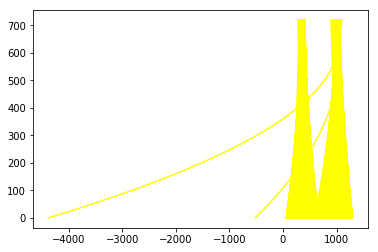

In [51]:
white_output = 'modified_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))